In [1]:
#pip install --upgrade tensorflow

import tensorflow as tensorflow
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from tabulate import tabulate

In [2]:
#preparing data from string to array
#abseq = "EVQLVESGGGLVQPGGSLRLSCAASGRTFSEYAMGWFRQAPGKEREFVATISWSGGSTYYTDSVKGRFTISRDNAKNTVYLQMNSLRPEDTAVYYCAAAGLGTVVSEWDYDYDYWGQGTLVTVSS"
abseq = 'LKWTYQKAVSIGELHKVMQESLCRIGNQTRILSTGGAPSQRSNPEYDMEGHVGDLVHDATLGADEFVVIFSLNKQNKGKVVTTIADAKFAPEADVRDFIALRLPYILCAMLGEFNRSPRLTPSEY'
antigenseq = "RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF"

dictionary = {"D": 0,"E": 1,"C": 2,"N": 3,"F": 4,"Q": 5,"Y": 6,"S": 7, "M": 8,"T": 9,"I": 10,"G": 11,"V": 12,"W": 13,"L": 14,"A": 15,"P": 16,"H": 17,"K": 18,"R": 19}


# function AA sequence into one-hot:

In [4]:
def AAseq(AB_sequence, AA_dictionary):

    seq_array = []
    for i in AB_sequence:
        seq_array.append(i)

    seq_df = pd.DataFrame(seq_array)
    seq_df = seq_df.rename(columns={ seq_df.columns[0]: 'AminoAcid' })


    seq_df = pd.DataFrame({'AminoAcid': seq_array})
    seq_df = pd.get_dummies(seq_df['AminoAcid'], prefix='AminoAcid')


    aa = []
    for i in AA_dictionary:
        aa.append(i)

    amino = []
    for i in seq_df.columns.tolist():
        amino.append(i[10])

    missing = list(set(aa) - set(amino))
    if len(missing) > 0: 
        seq_df['AminoAcid_'] = 0

    seq_df.replace({1: 255}, inplace=True)
    
    return(seq_df)  

# function translate AA sequence into sum of charge compatibilities:

In [5]:
charge_df = pd.read_excel('/Users/adriankaufmann/Desktop/charge_compatibility.xlsx', index_col=0)


def AAcharge(AB_sequence, AG_sequence, AA_dictionary, ChargeComp):

    # translating the aa sequences into numbers for array:
    array_abseq = []
    for i in AB_sequence:
        array_abseq.append(AA_dictionary[i])

    array_antigenseq = []
    for i in AG_sequence:
        array_antigenseq.append(AA_dictionary[i])


    # calculating the average of each aa in AB seq with the whole antigen sequence
    array_avg = []
    for i in array_abseq:
        sum = 0
        for c in array_antigenseq:
            sum += (charge_df.iloc[c][i])
        avg = sum/len(antigenseq)
        array_avg.append(avg)

    charge_avg_df=pd.DataFrame(array_avg)
    charge_avg_df = charge_avg_df.rename(columns={ charge_avg_df.columns[0]: 'ChargeAvg' })


    bins = np.arange(8, 14.1, 0.3)
    charge_avg_df['bin'] = pd.cut(charge_avg_df['ChargeAvg'], bins)

    # one hot encoding of the dataset in which each average is binned
    chargeavg = charge_avg_df['bin']
    charge_avg_df = pd.DataFrame({'ChargeAvg': chargeavg})
    charge_avg_df = pd.get_dummies(charge_avg_df['ChargeAvg'], prefix='bin')
    charge_avg_df.replace({1: 255}, inplace=True)

    return(charge_avg_df)

# function translate AA sequence into sum of hydrophobe compatibilities:

In [6]:
hydroph_df = pd.read_excel('/Users/adriankaufmann/Desktop/hydroph_compatibility.xlsx', index_col=0)

def AAhydroph(AB_sequence, AG_sequence, AA_dictionary, HydrophComp):
    
    # translating the aa sequences into numbers for array:
    array_abseq = []
    for i in AB_sequence:
        array_abseq.append(dictionary[i])

    array_antigenseq = []
    for i in antigenseq:
        array_antigenseq.append(dictionary[i])


    # calculating the average of each aa in AB seq with the whole antigen sequence
    hydroph_array_avg = []
    for i in array_abseq:
        sum = 0
        for c in array_antigenseq:
            sum += (hydroph_df.iloc[c][i])
        avg = sum/len(antigenseq)
        hydroph_array_avg.append(avg)

    hydroph_avg_df=pd.DataFrame(hydroph_array_avg)
    hydroph_avg_df = hydroph_avg_df.rename(columns={ hydroph_avg_df.columns[0]: 'HydrophAvg' })


    bins = np.arange(7, 25.1, 0.9)
    hydroph_avg_df['bin'] = pd.cut(hydroph_avg_df['HydrophAvg'], bins)


    # one hot encoding of the dataset in which each average is binned
    hydrophavg = hydroph_avg_df['bin']
    hydroph_avg_df = pd.DataFrame({'HydrophAvg': hydrophavg})
    hydroph_avg_df = pd.get_dummies(hydroph_avg_df['HydrophAvg'], prefix='bin')
    hydroph_avg_df.replace({1: 255}, inplace=True)

    return(hydroph_avg_df)

# function turn the three one-hot matrices into one RGB image:

In [7]:
def RGBimage(seqDF, chargeDF, hydrophDF):

    seq_df = seqDF.astype(int)
    charge_avg_df = chargeDF.astype(int)
    hydroph_avg_df = hydrophDF.astype(int)


    R = seq_df.to_numpy()
    G = charge_avg_df.to_numpy()
    B = hydroph_avg_df.to_numpy()


    import matplotlib.pyplot as plt

    image = np.dstack((R,G,B))

    
    
    plt.figure(figsize = (100,10))
   
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image, interpolation='nearest')
    
    
    #return(image, plt)
    return(plt)

In [8]:
training = pd.read_excel('/Users/adriankaufmann/Desktop/dataset_train_num330_lenall.xlsx')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


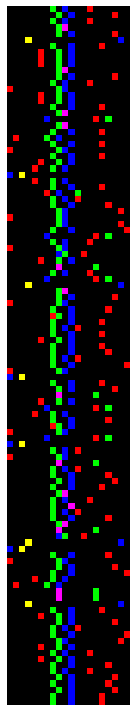

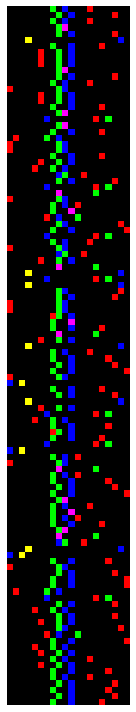

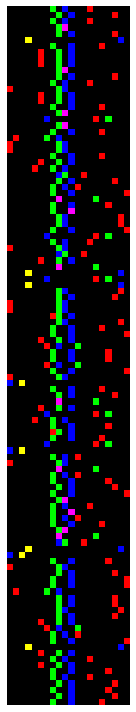

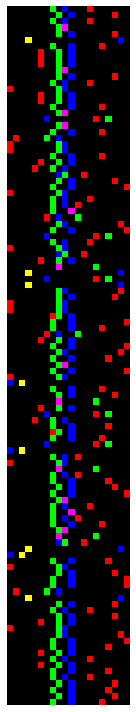

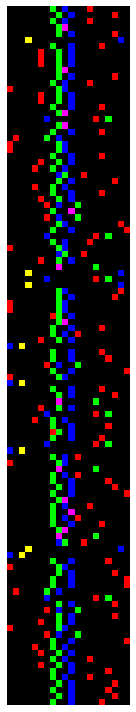

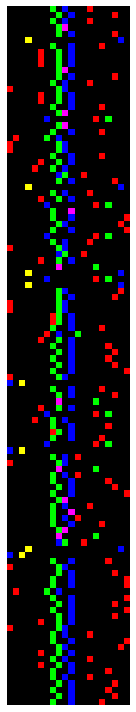

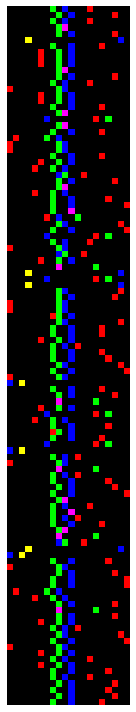

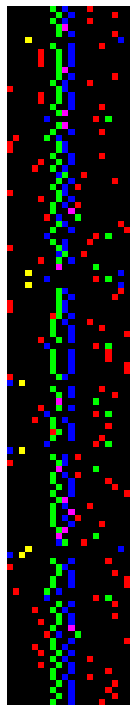

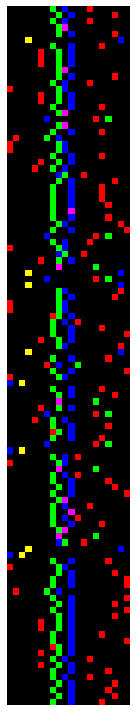

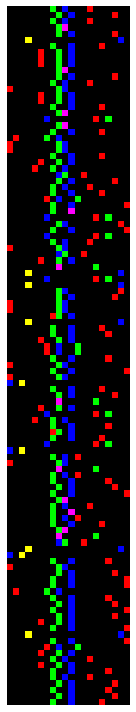

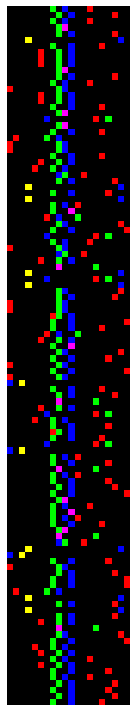

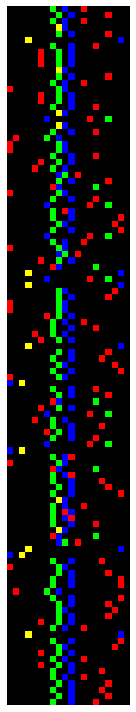

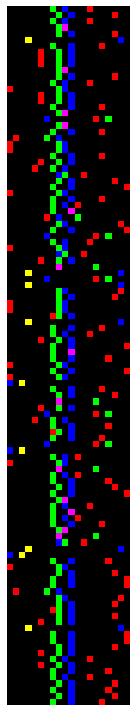

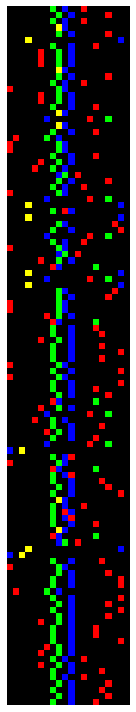

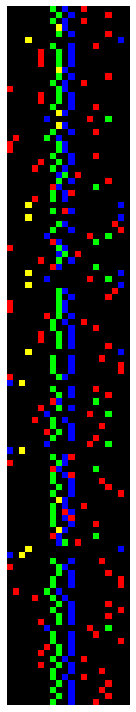

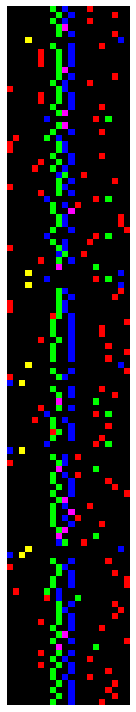

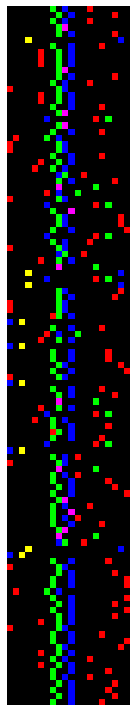

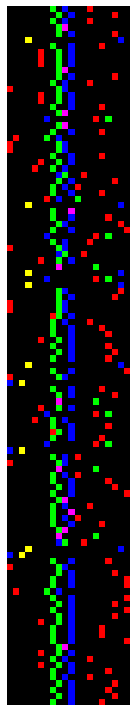

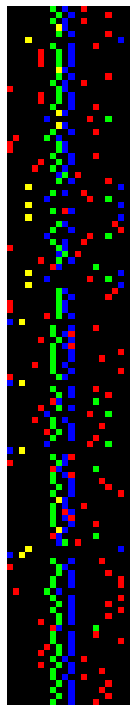

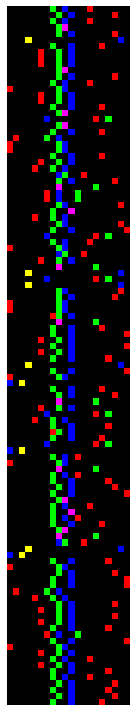

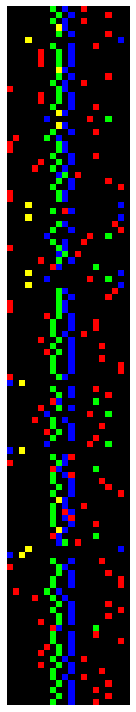

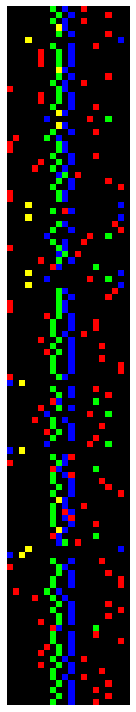

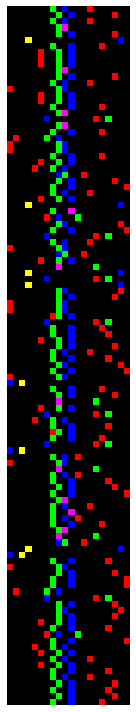

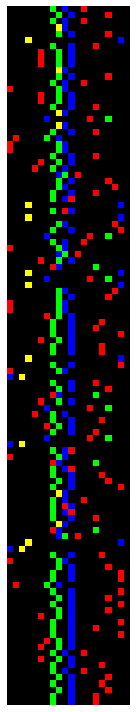

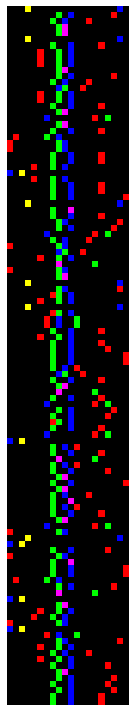

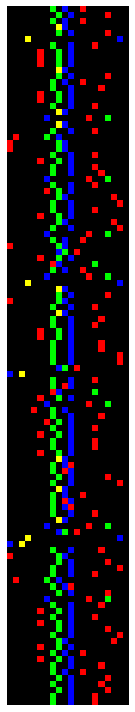

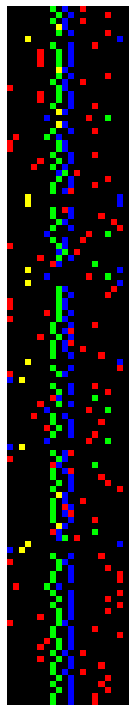

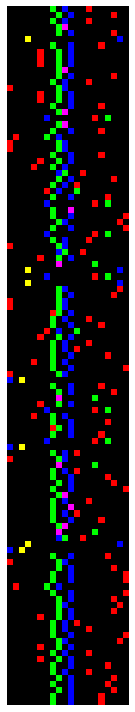

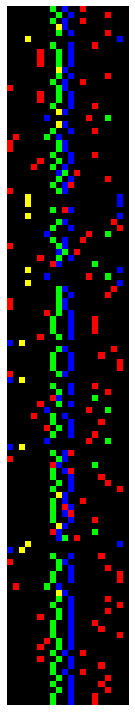

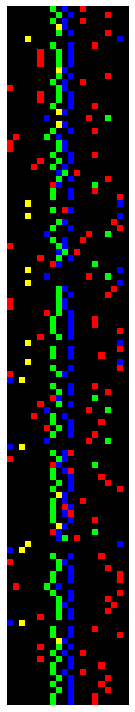

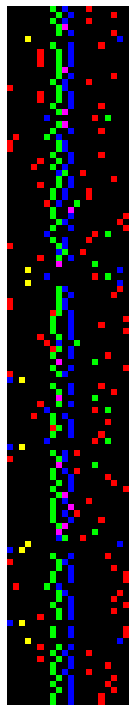

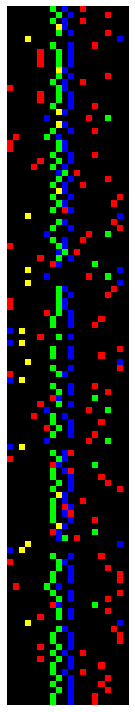

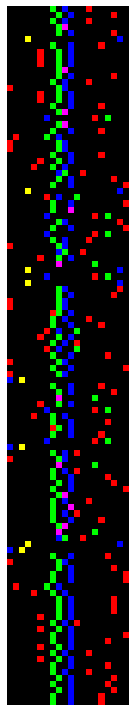

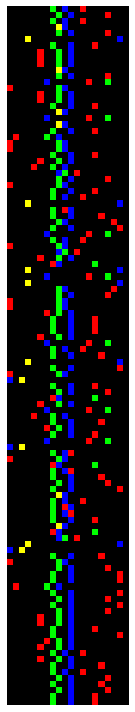

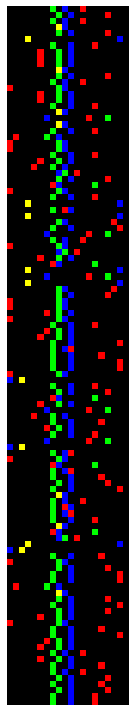

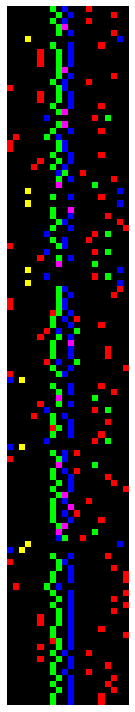

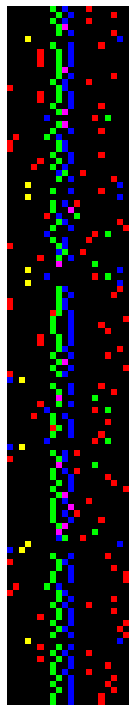

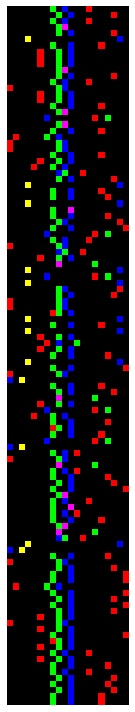

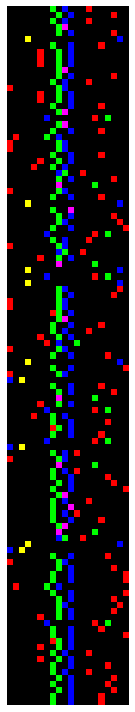

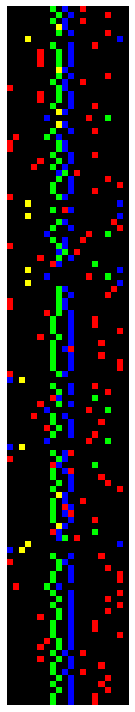

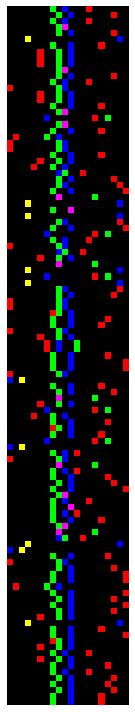

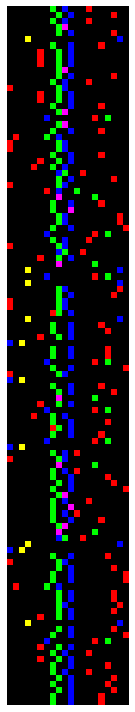

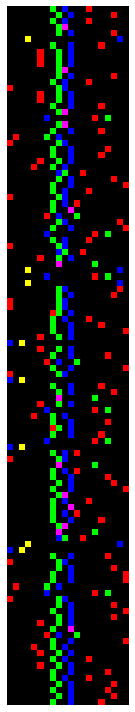

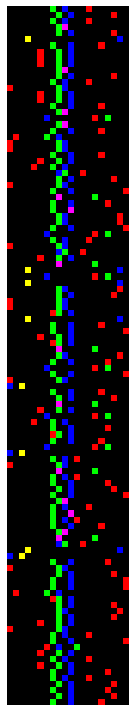

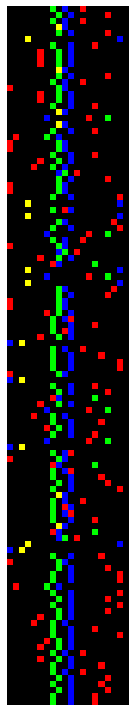

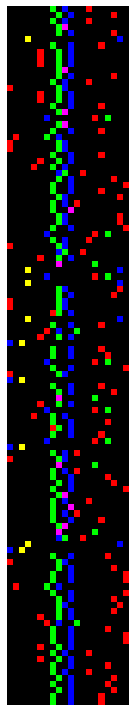

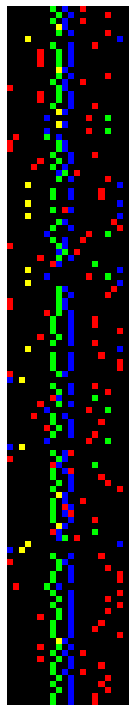

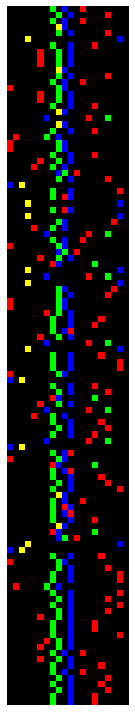

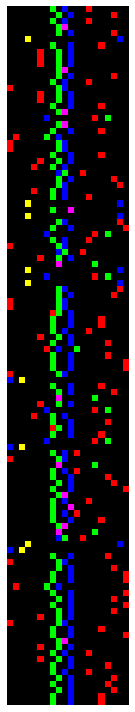

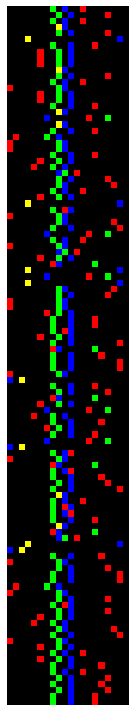

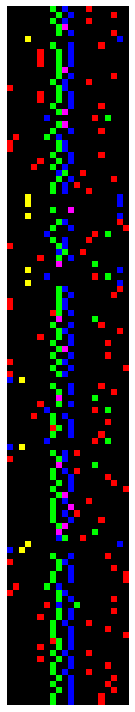

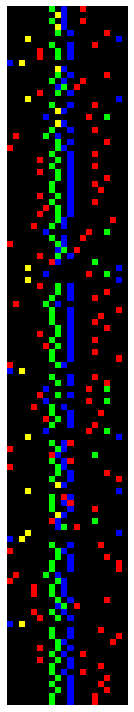

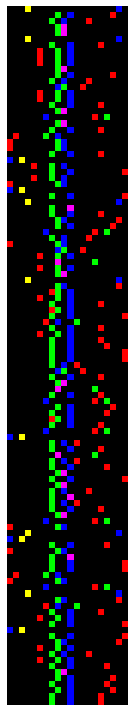

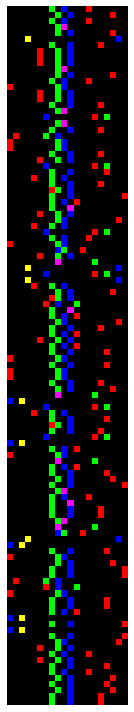

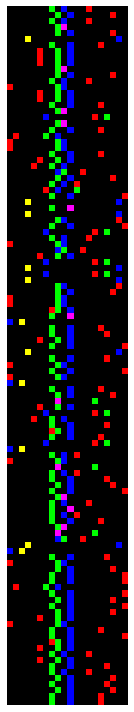

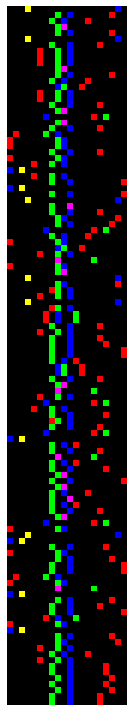

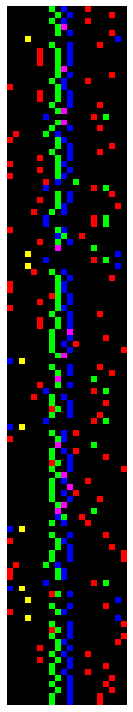

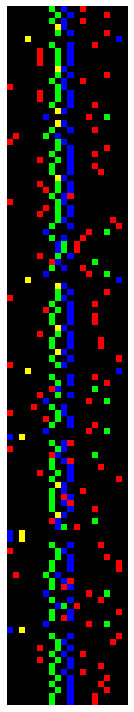

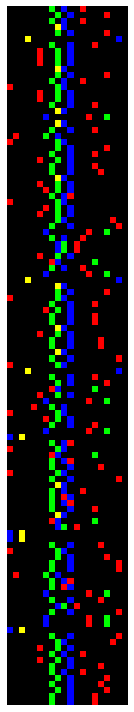

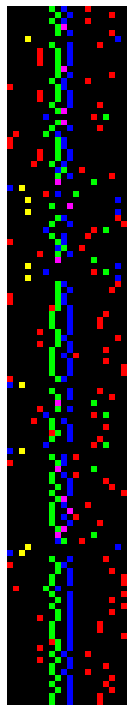

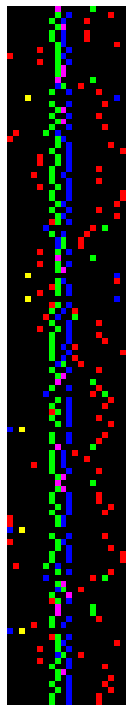

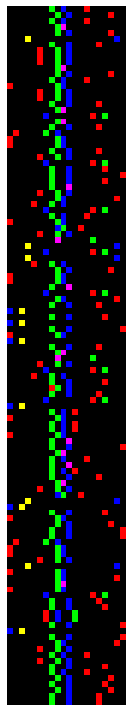

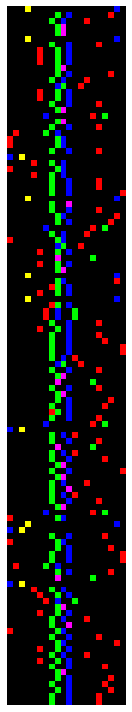

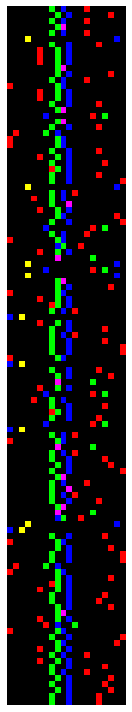

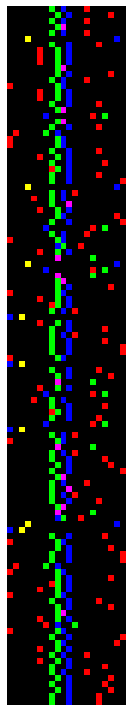

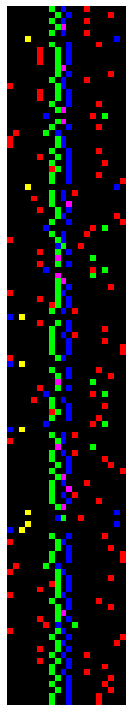

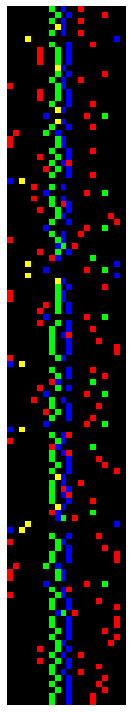

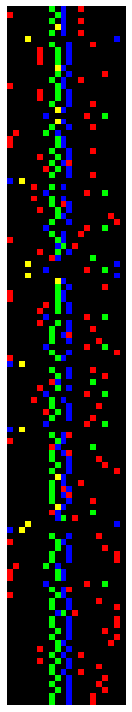

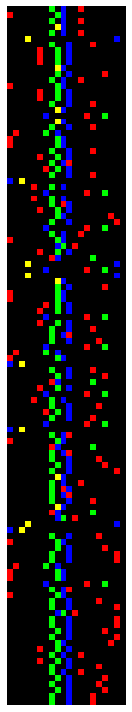

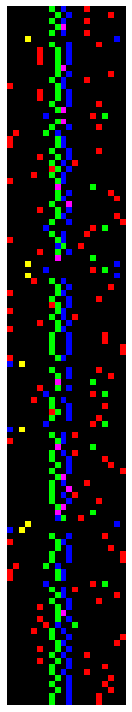

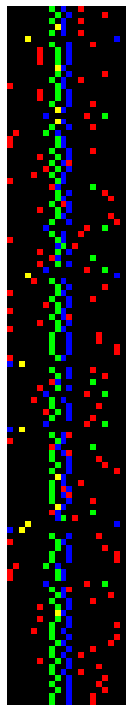

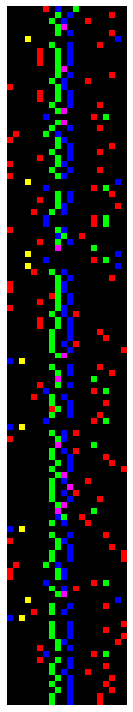

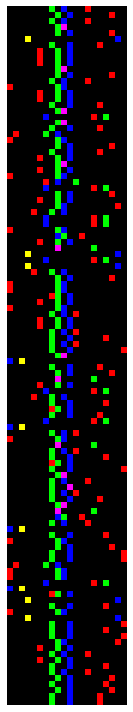

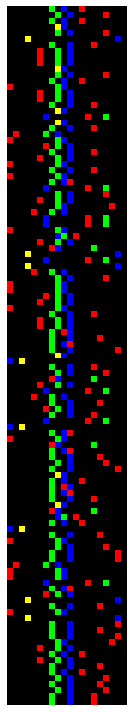

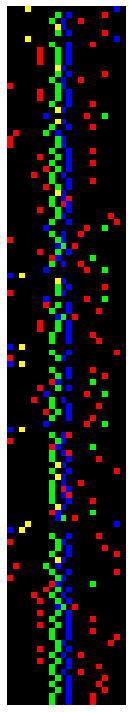

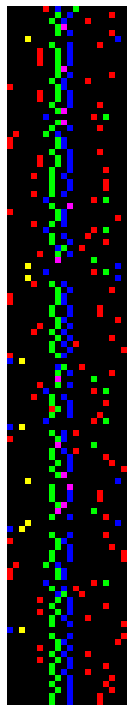

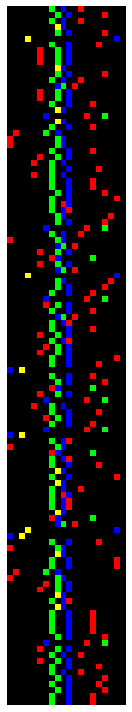

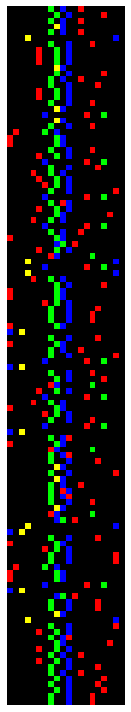

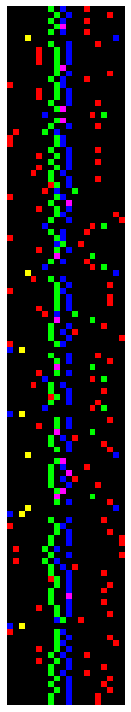

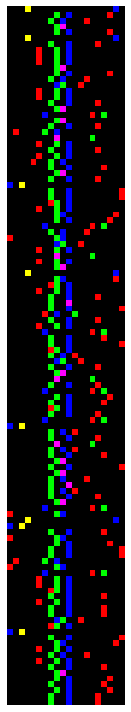

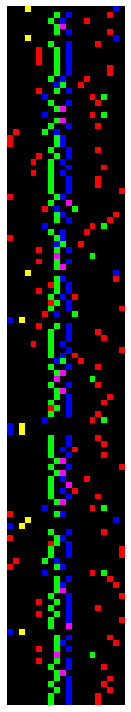

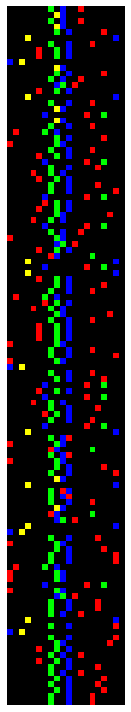

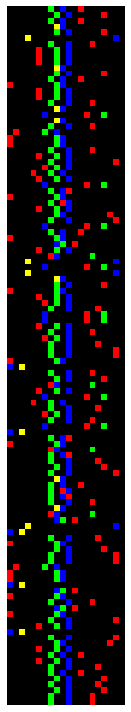

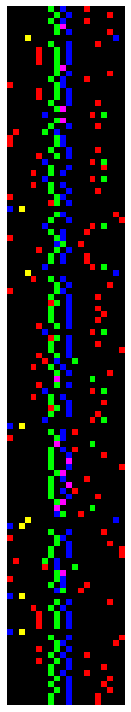

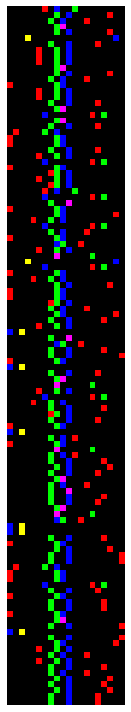

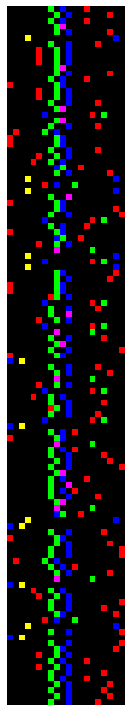

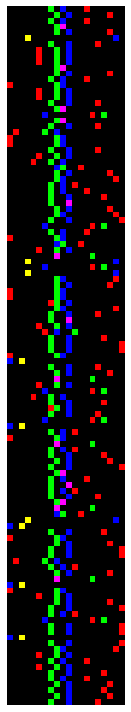

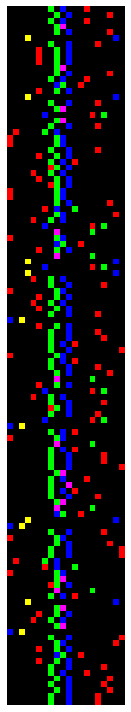

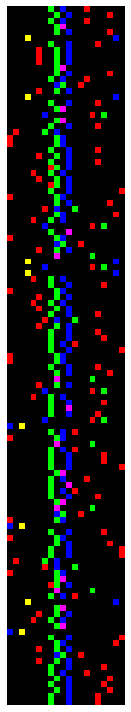

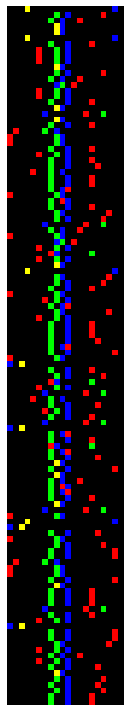

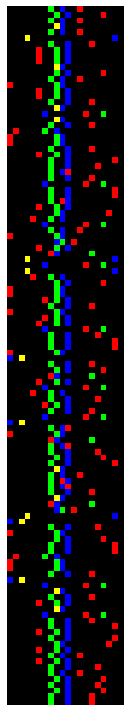

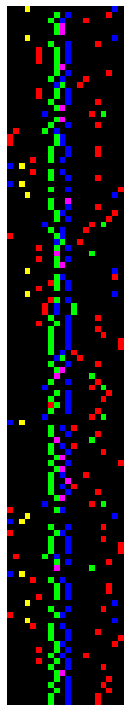

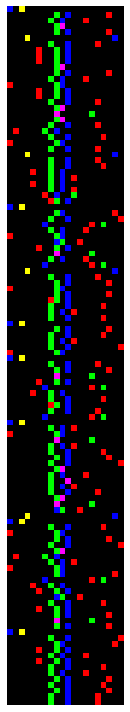

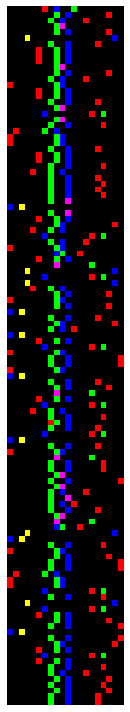

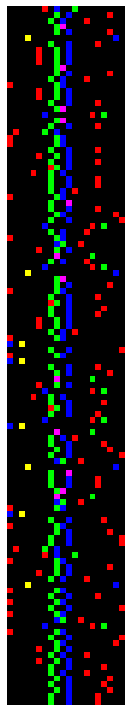

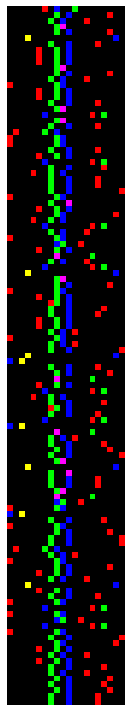

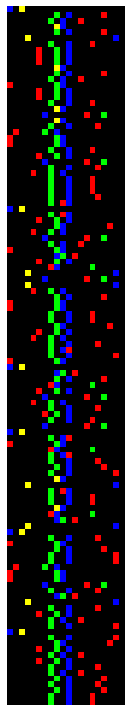

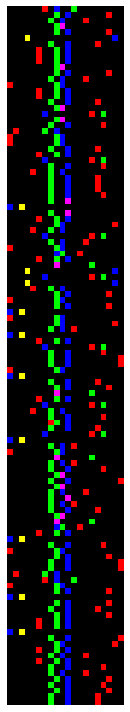

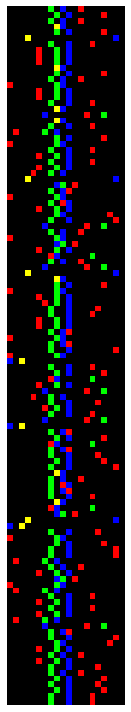

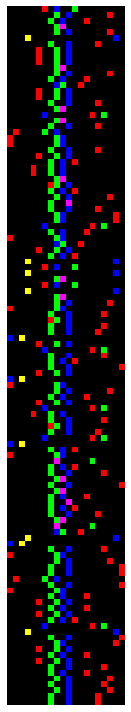

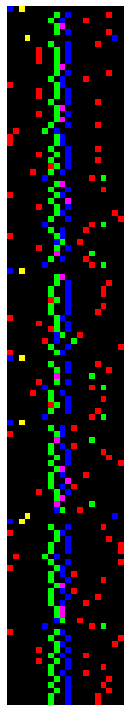

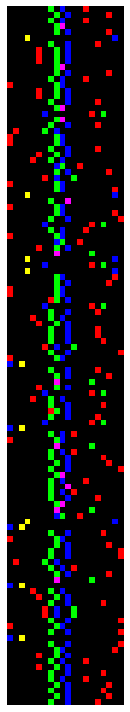

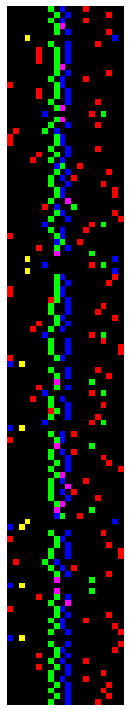

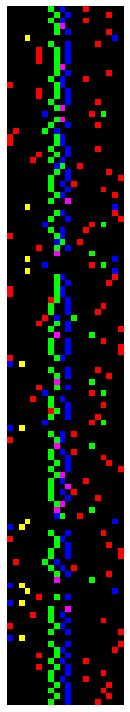

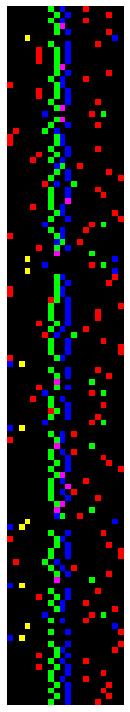

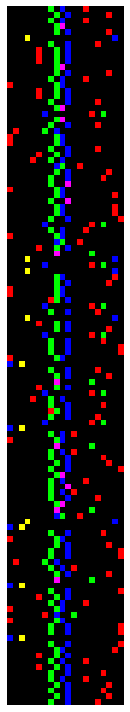

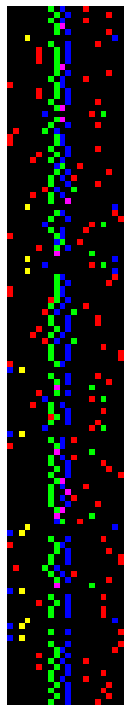

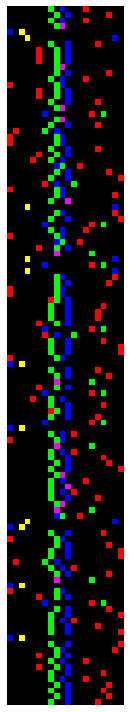

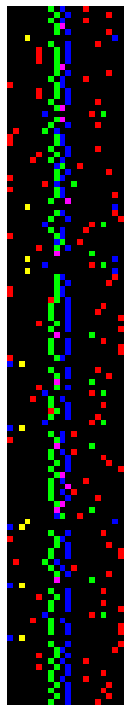

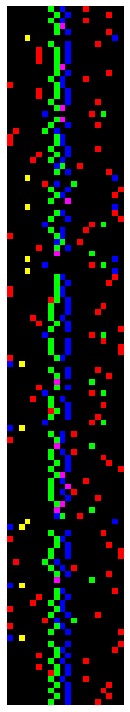

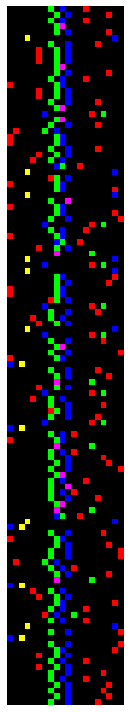

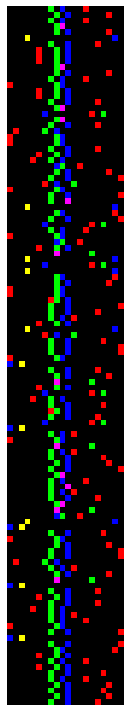

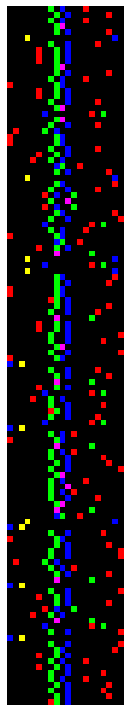

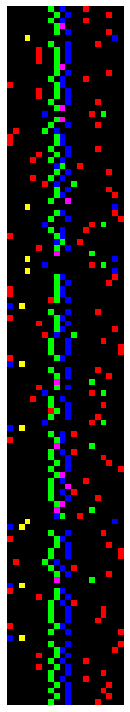

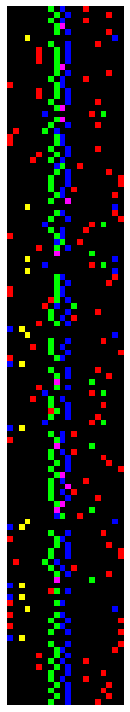

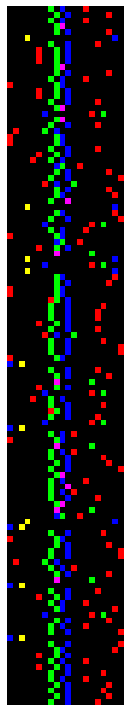

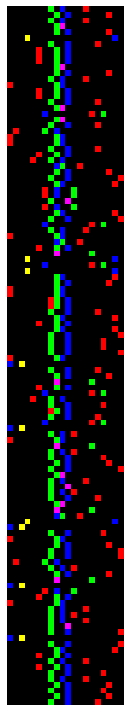

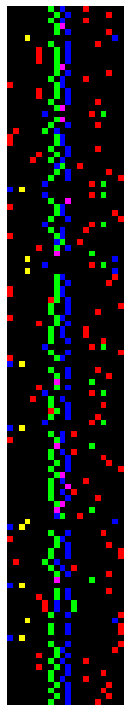

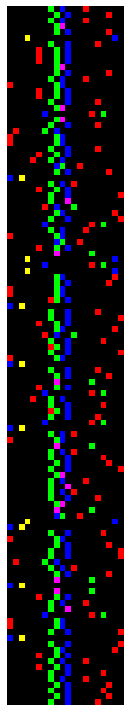

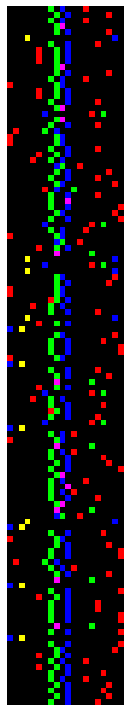

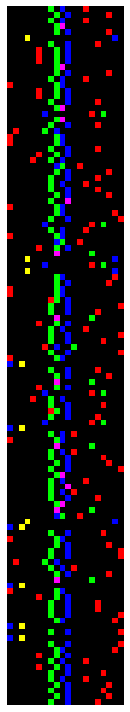

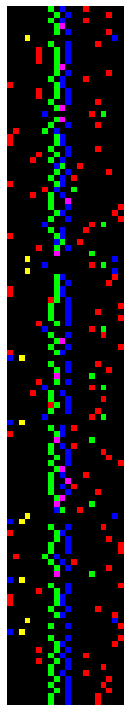

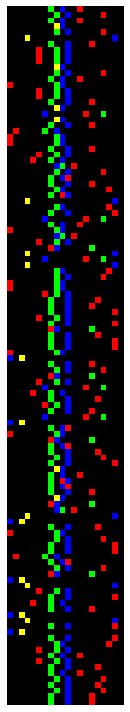

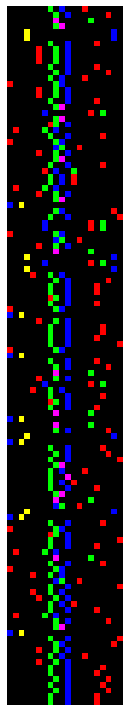

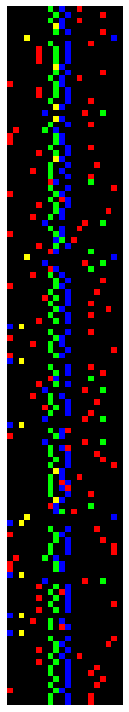

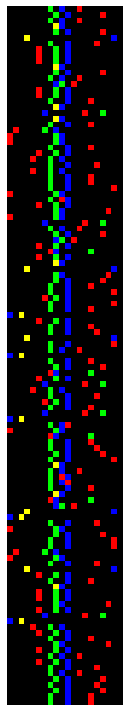

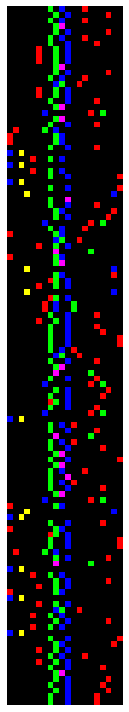

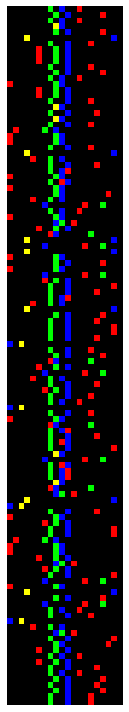

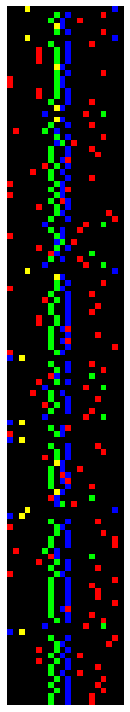

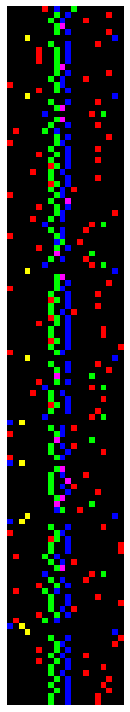

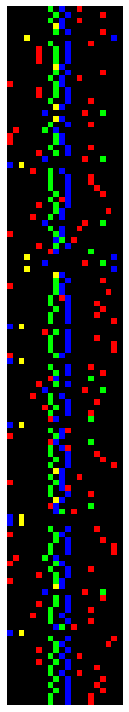

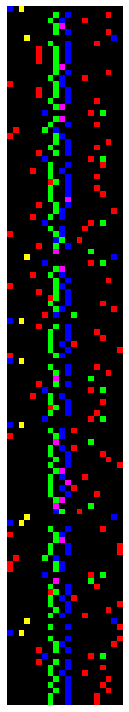

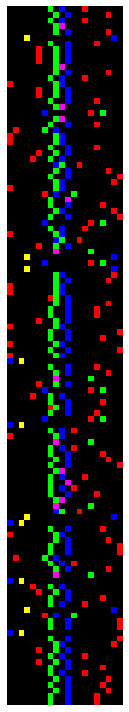

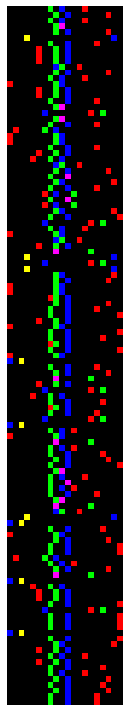

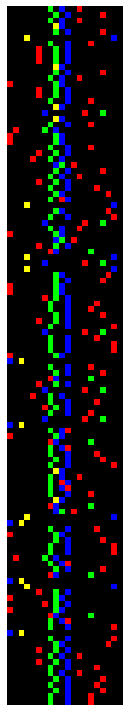

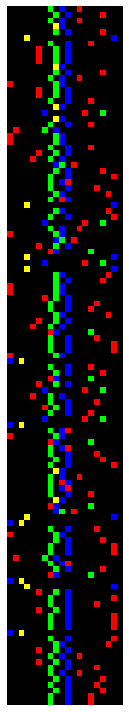

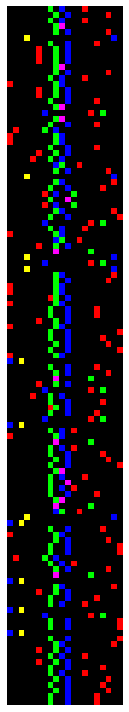

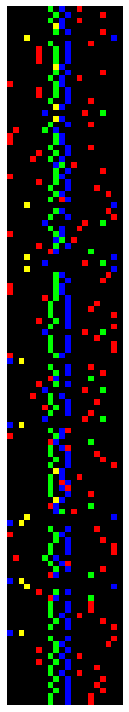

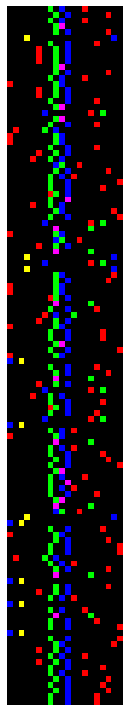

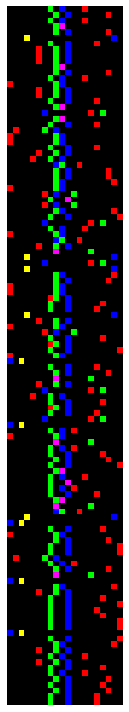

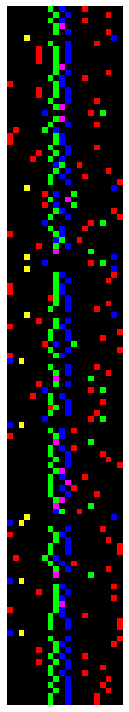

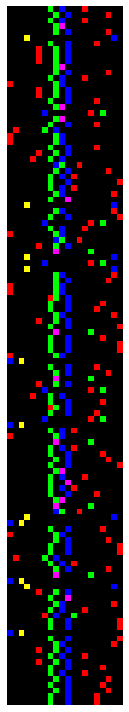

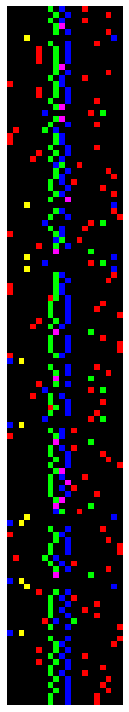

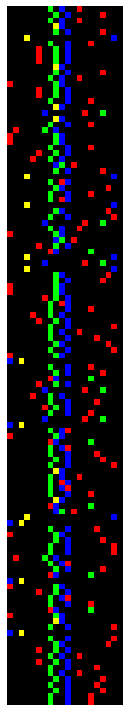

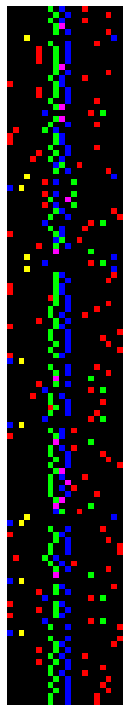

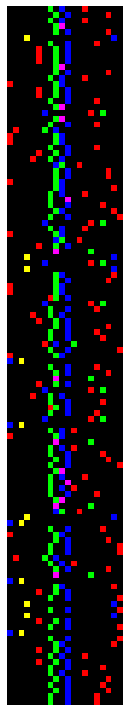

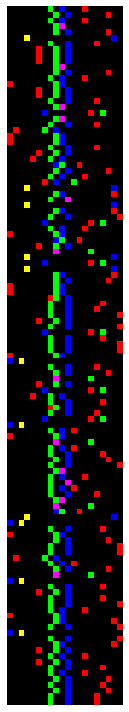

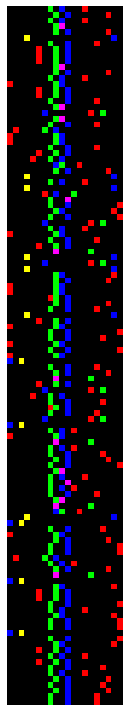

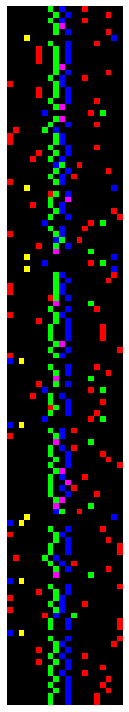

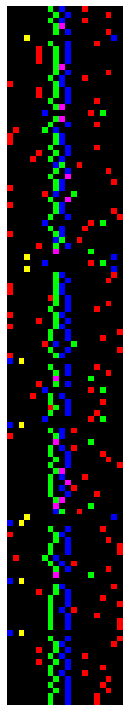

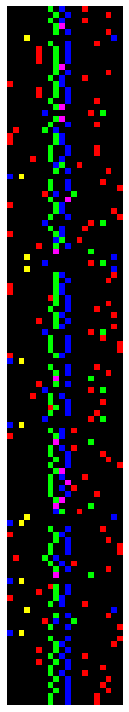

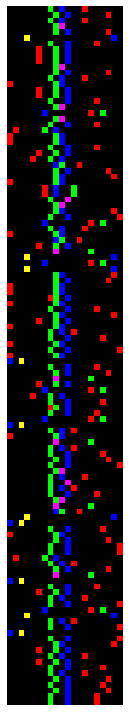

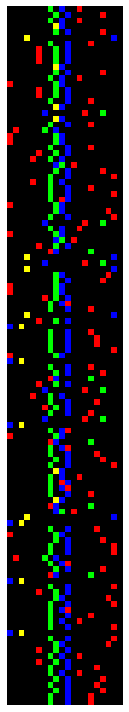

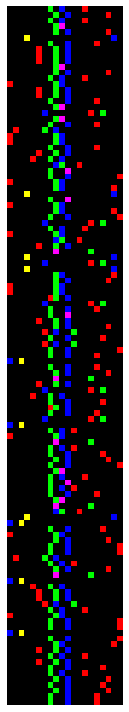

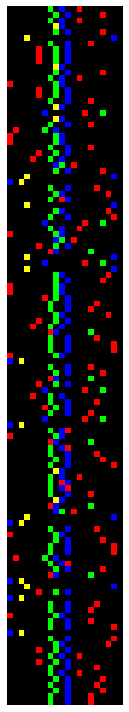

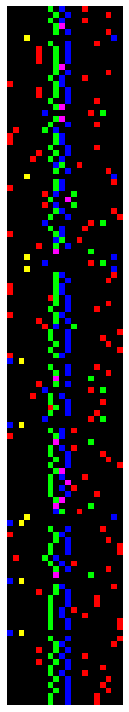

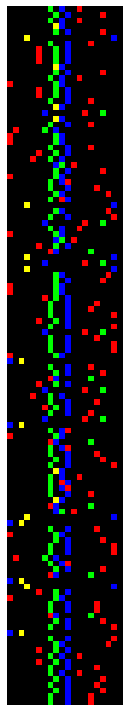

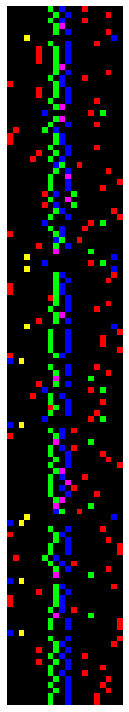

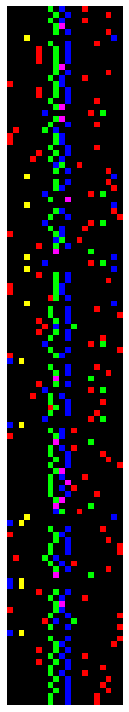

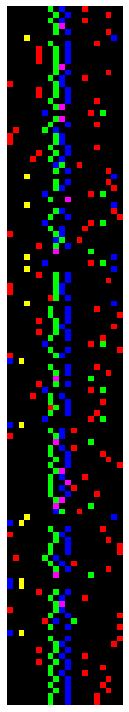

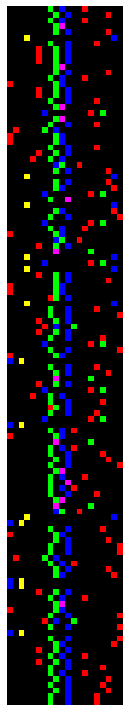

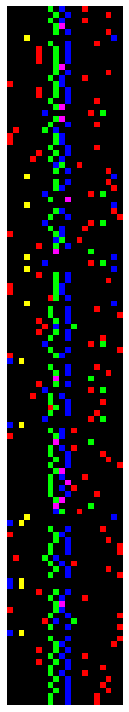

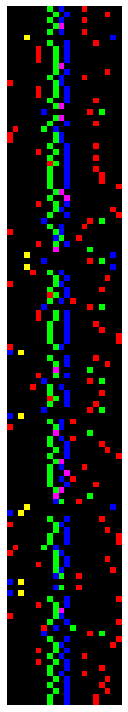

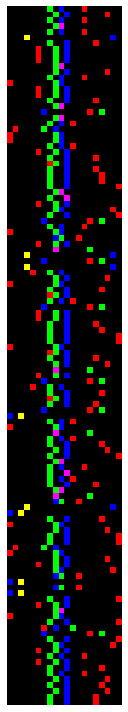

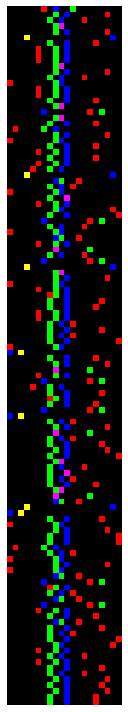

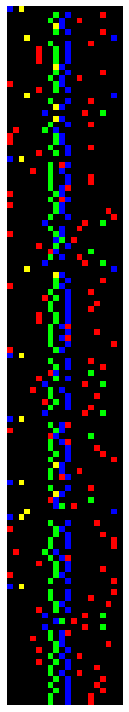

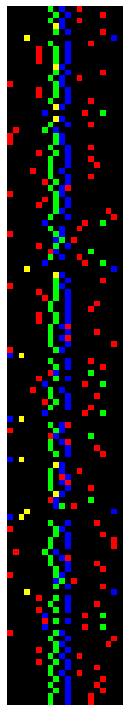

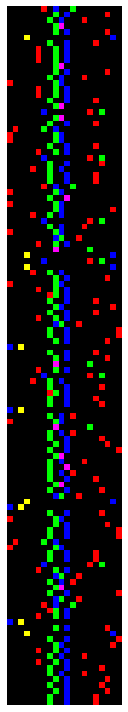

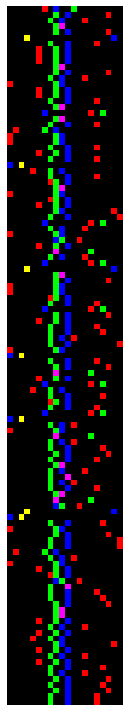

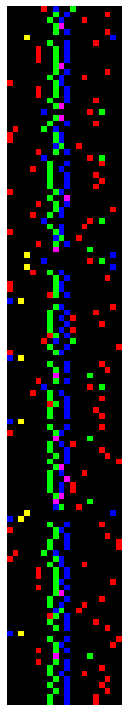

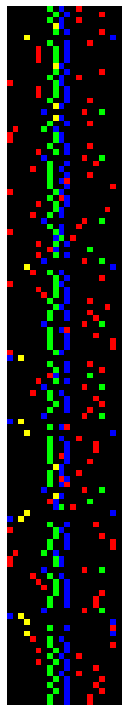

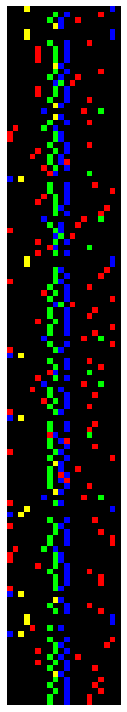

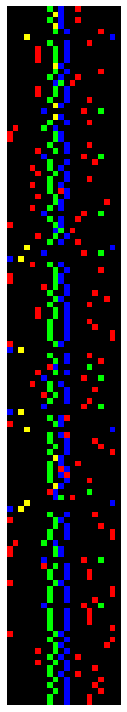

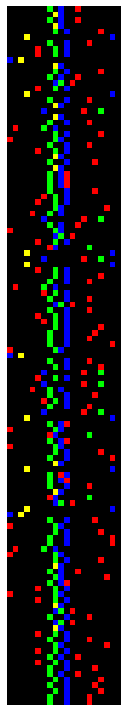

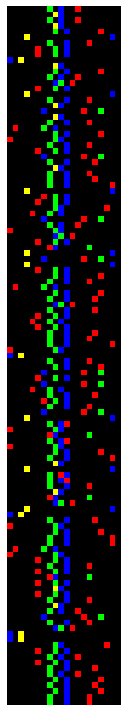

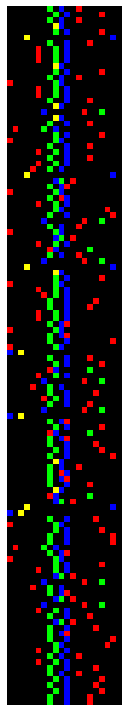

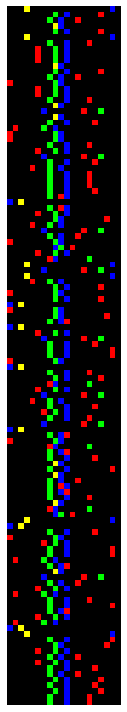

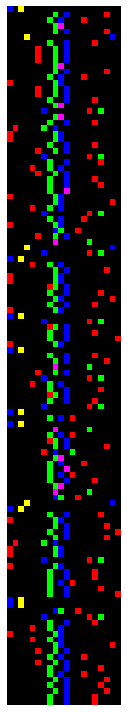

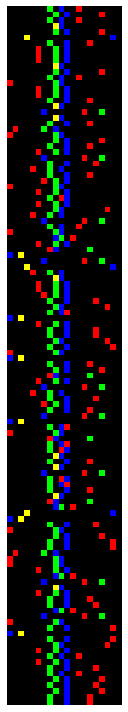

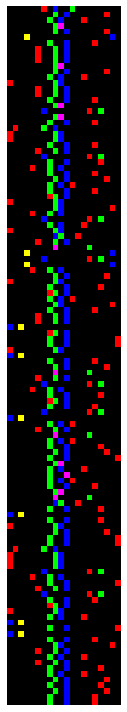

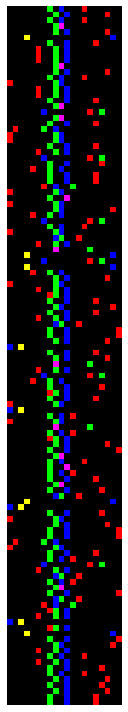

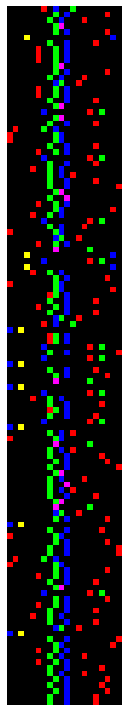

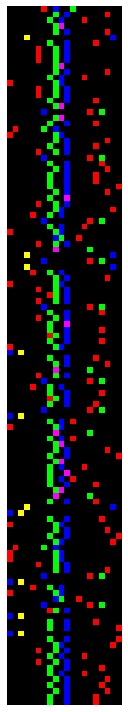

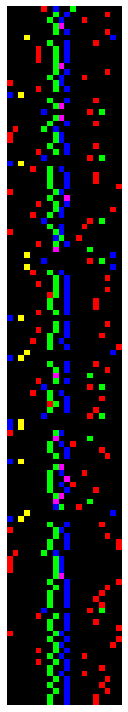

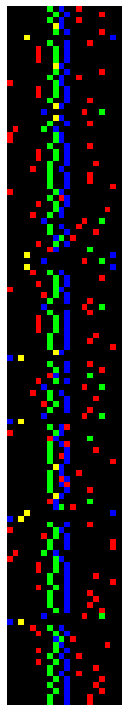

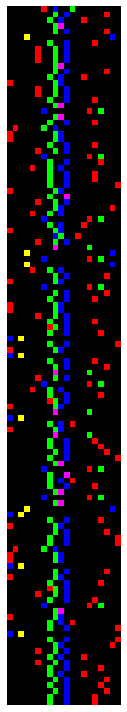

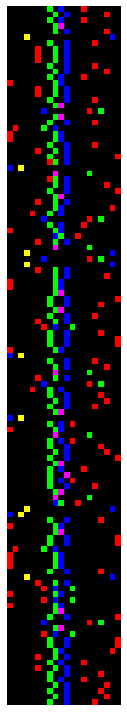

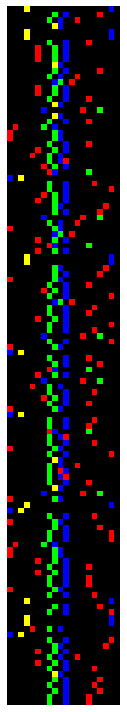

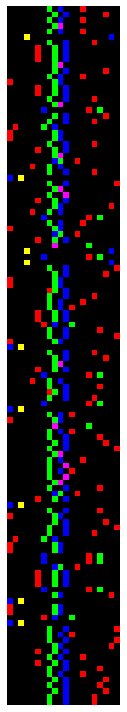

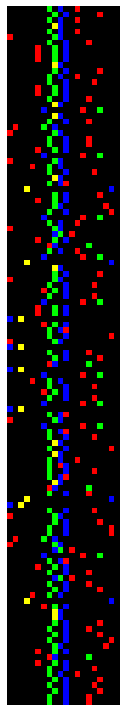

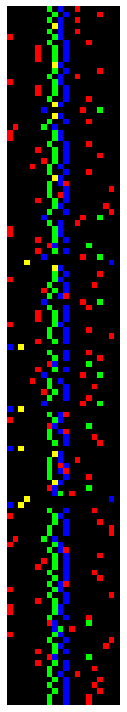

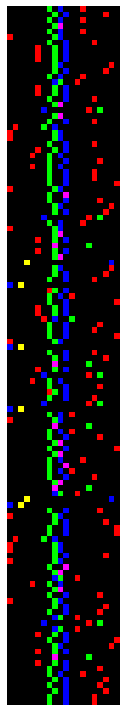

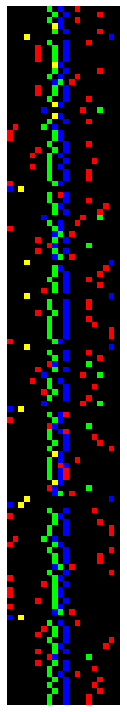

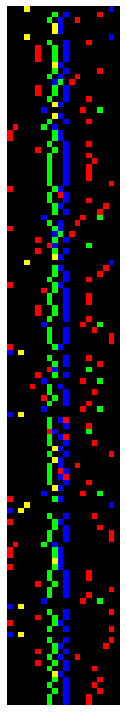

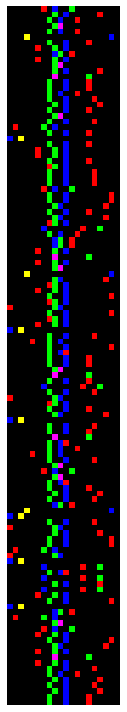

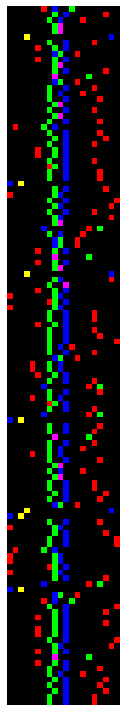

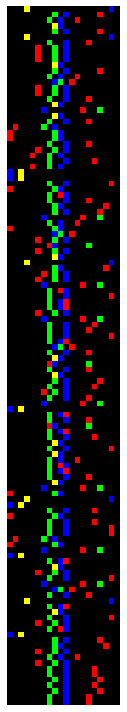

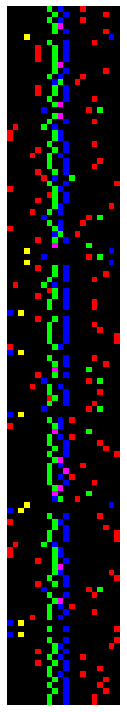

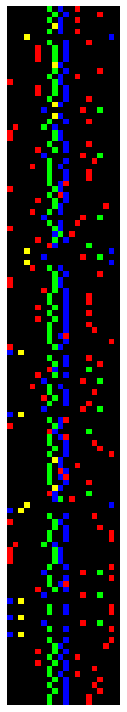

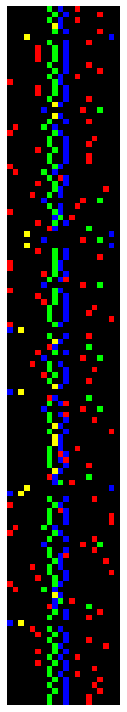

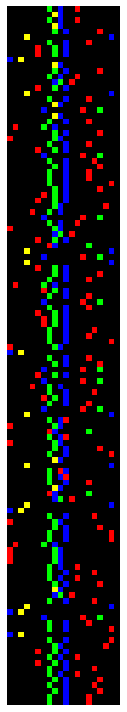

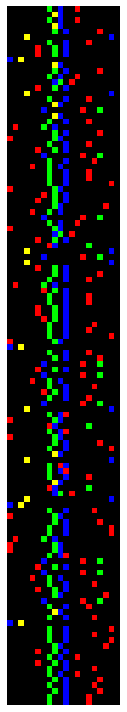

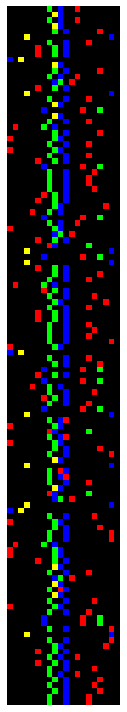

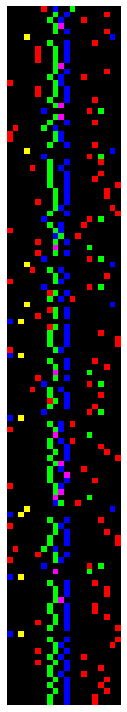

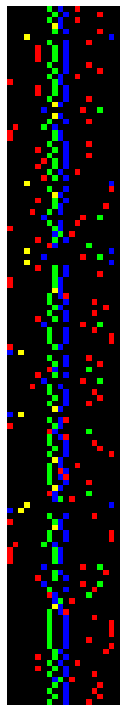

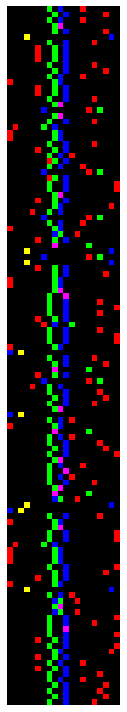

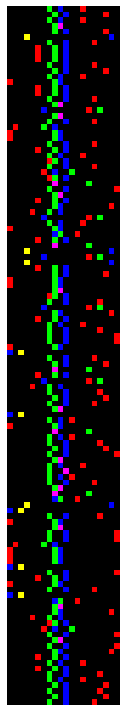

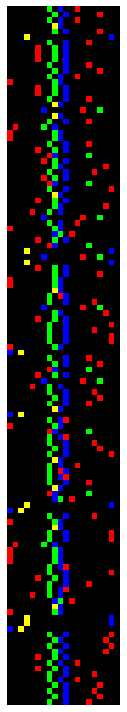

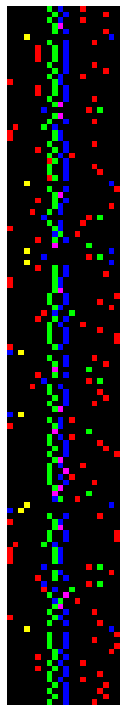

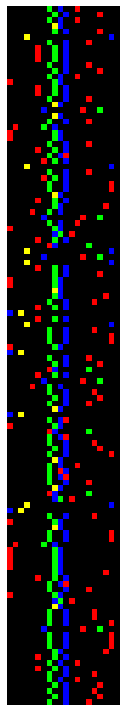

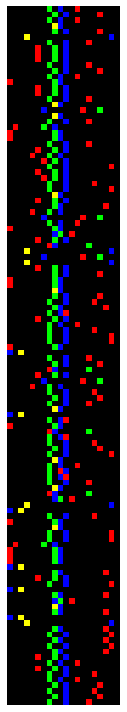

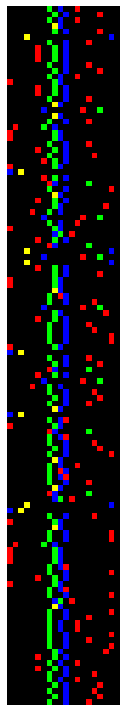

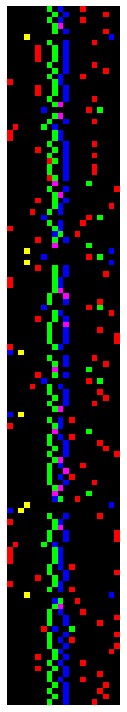

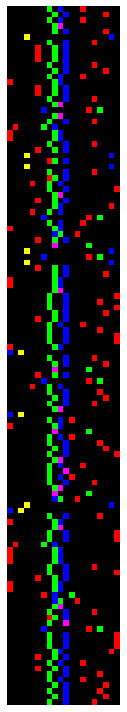

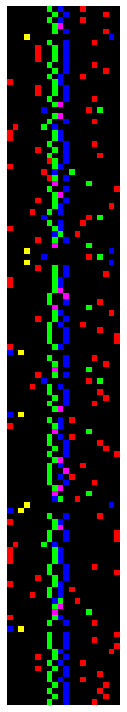

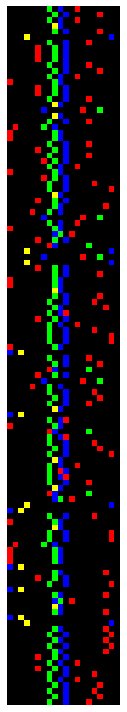

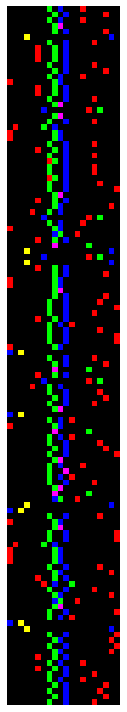

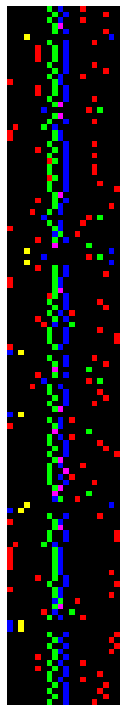

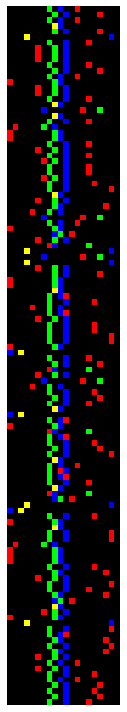

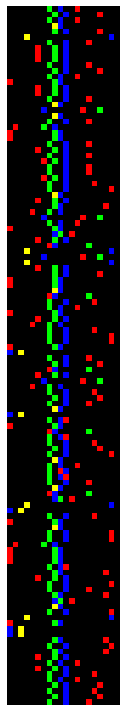

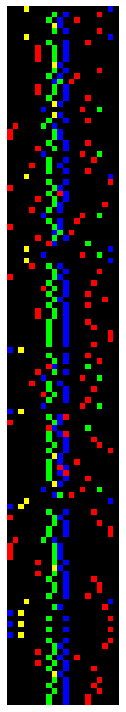

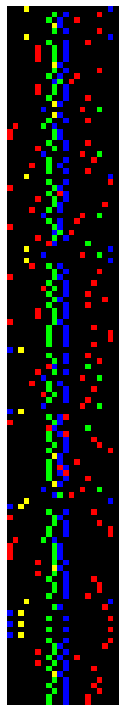

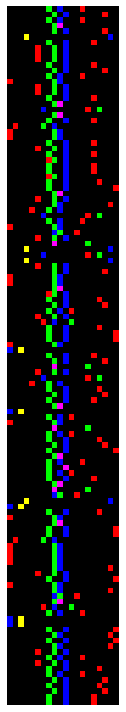

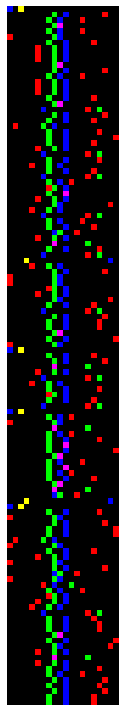

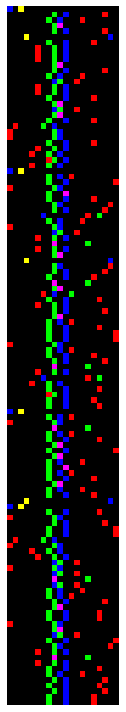

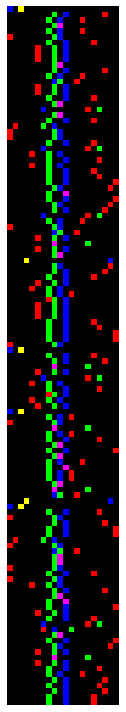

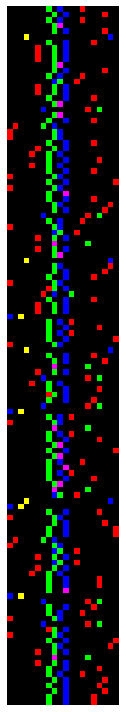

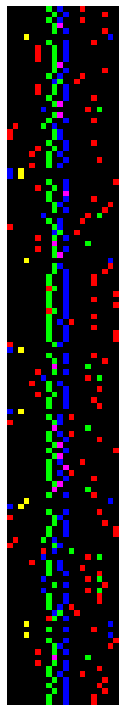

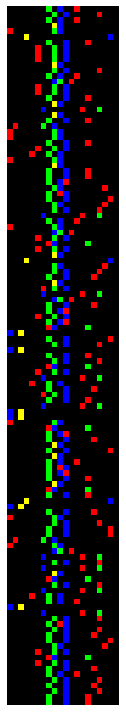

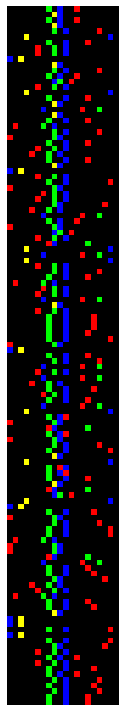

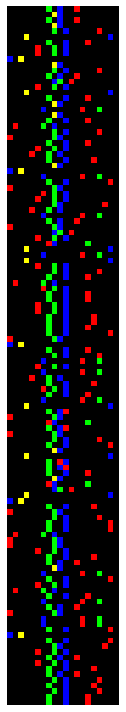

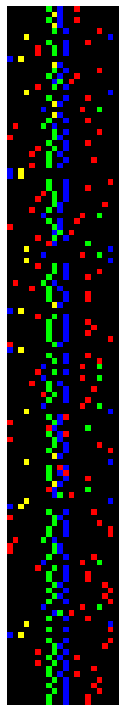

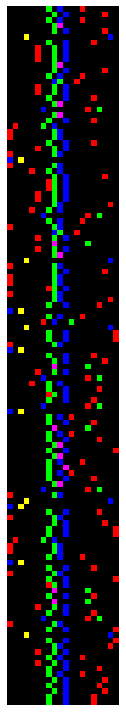

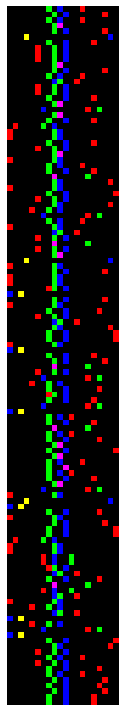

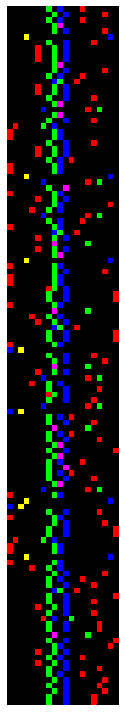

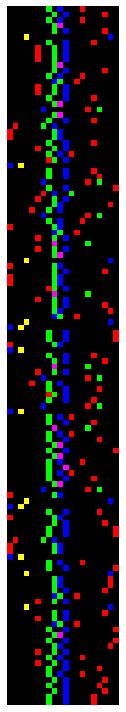

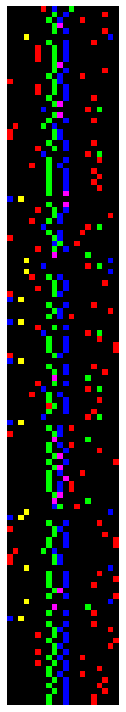

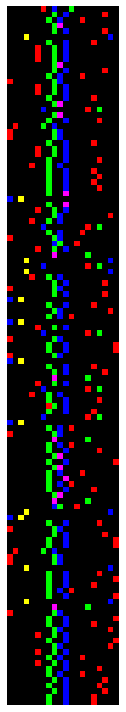

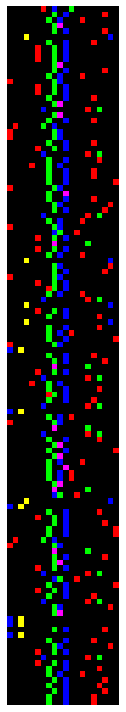

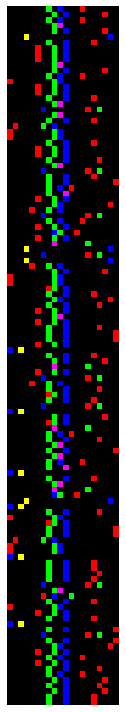

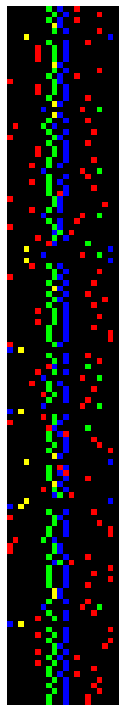

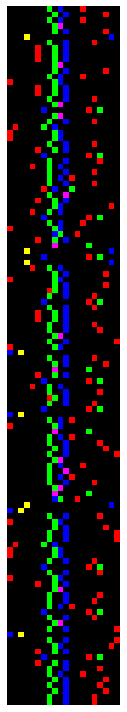

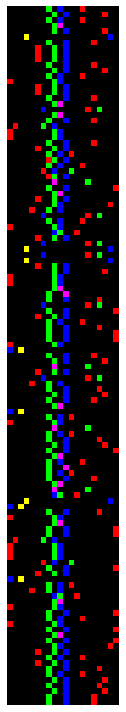

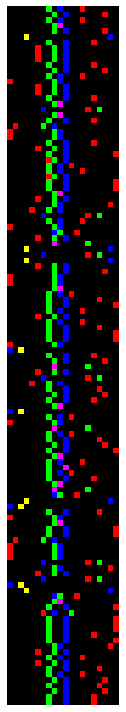

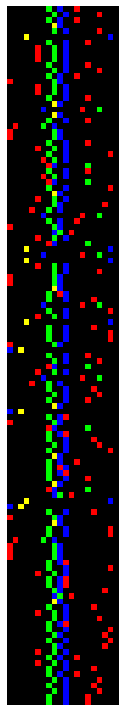

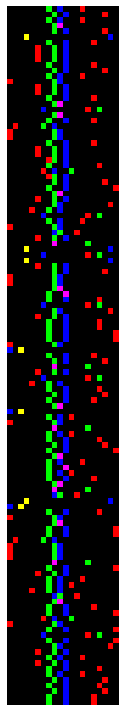

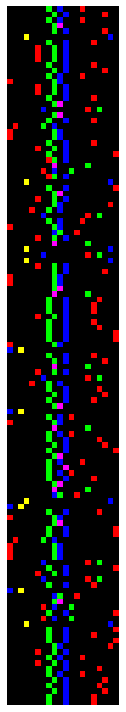

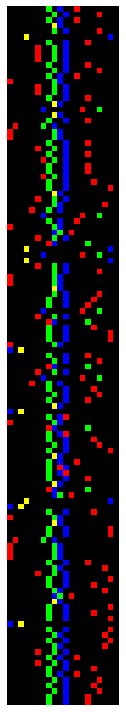

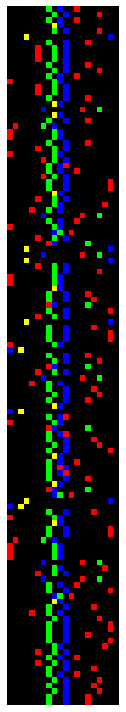

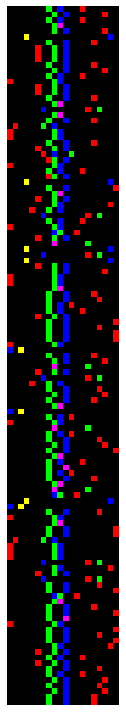

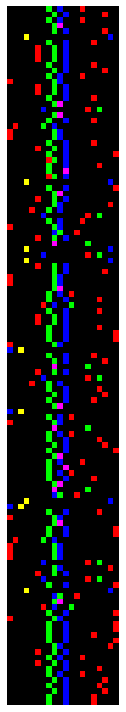

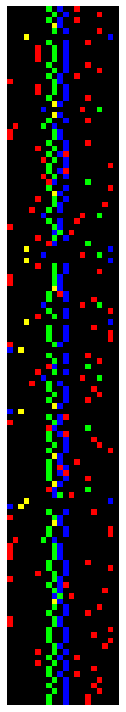

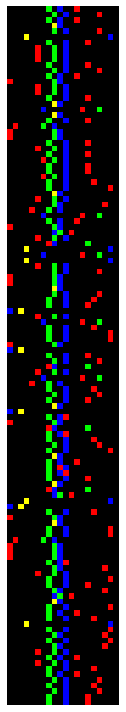

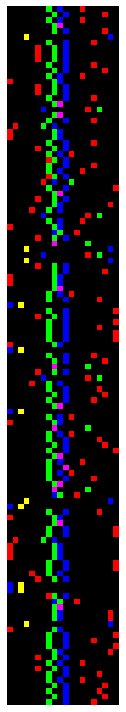

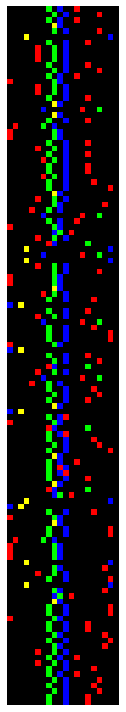

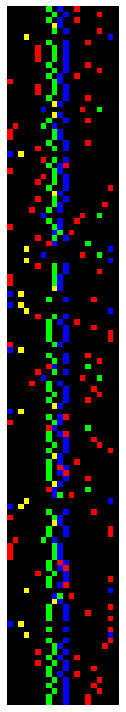

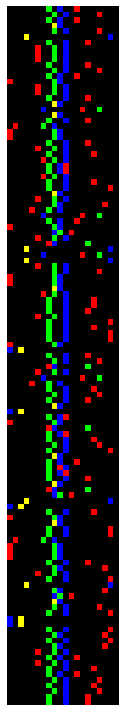

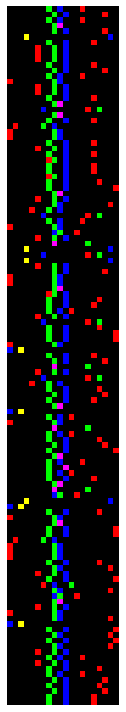

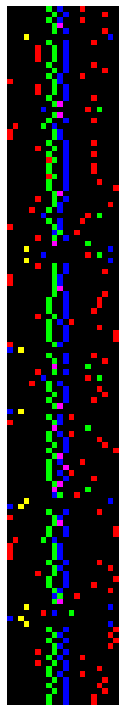

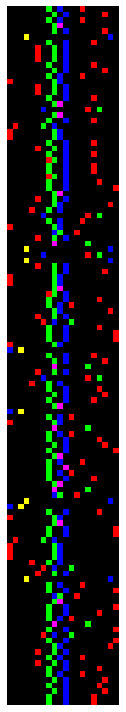

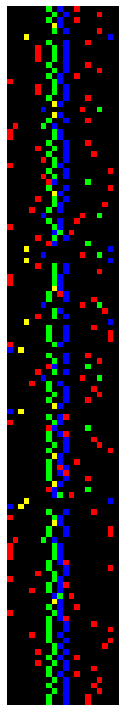

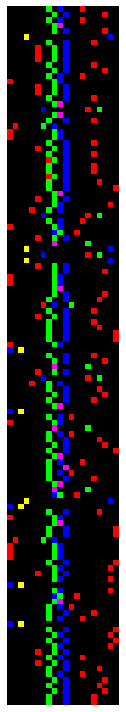

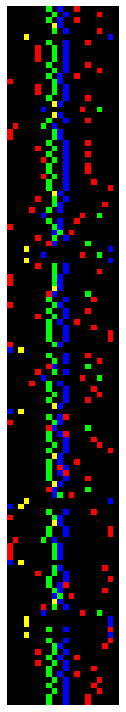

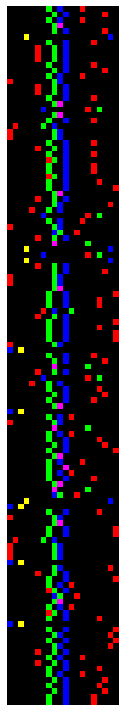

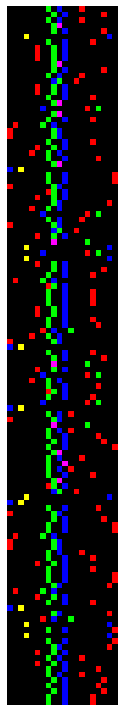

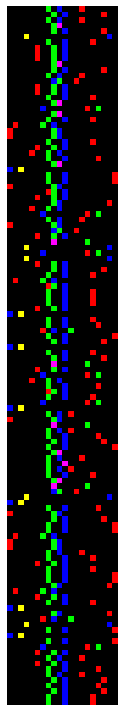

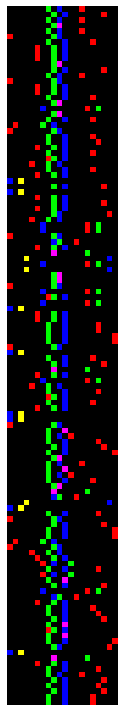

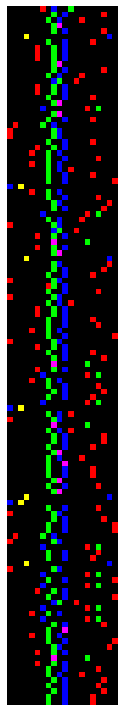

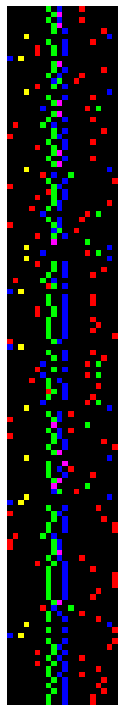

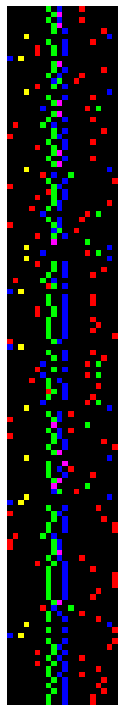

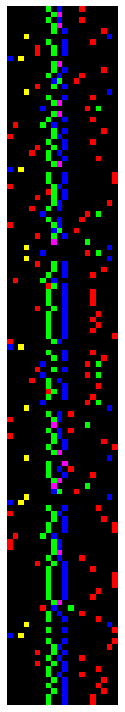

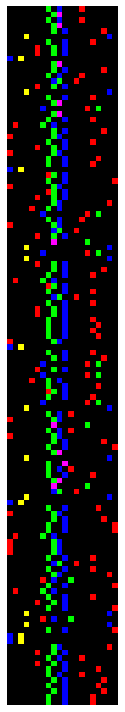

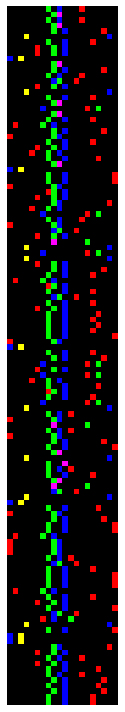

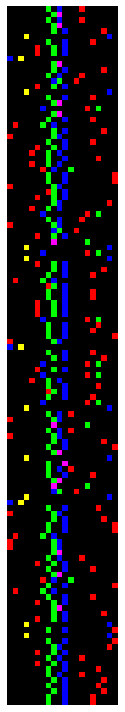

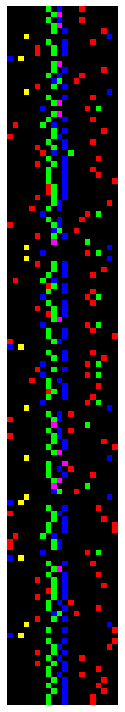

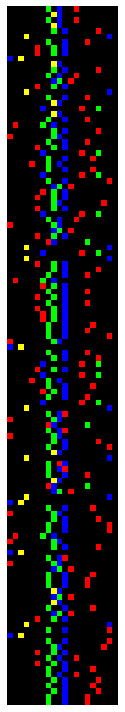

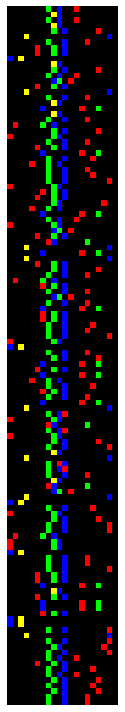

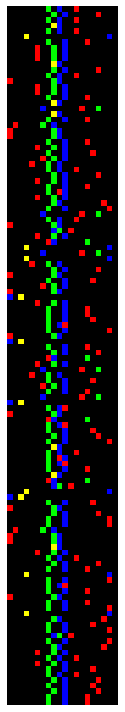

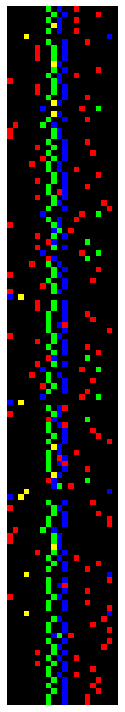

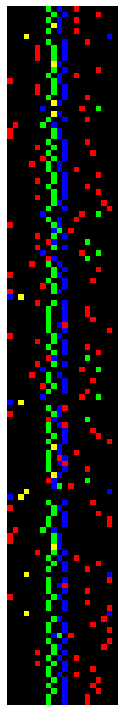

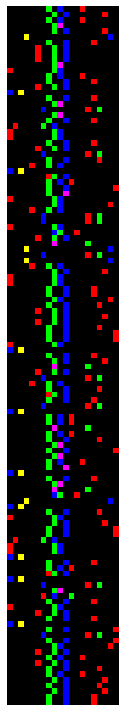

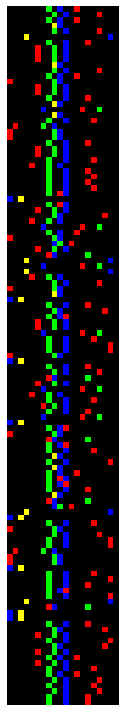

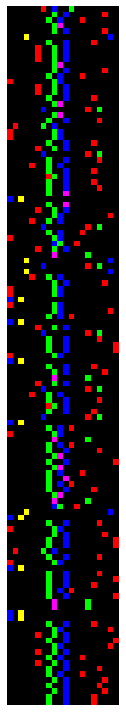

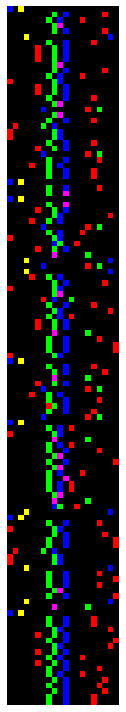

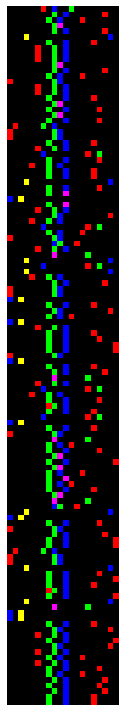

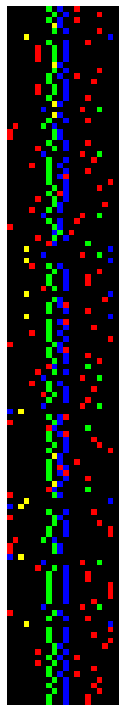

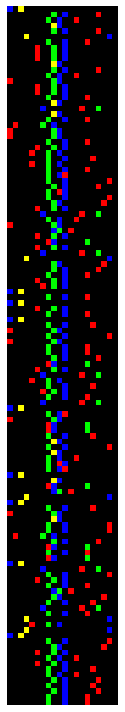

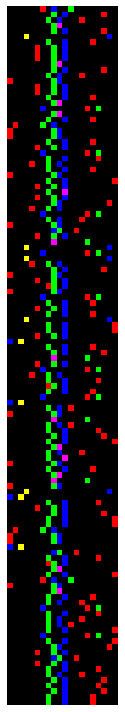

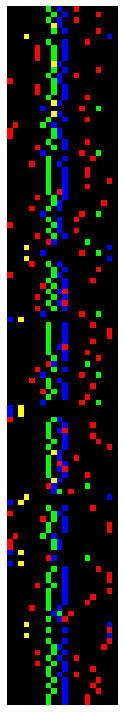

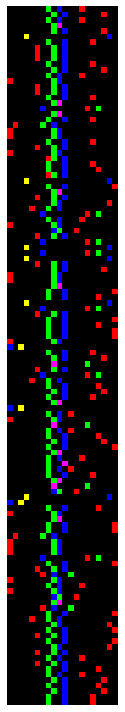

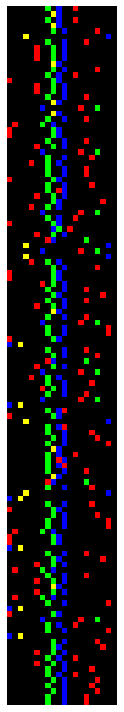

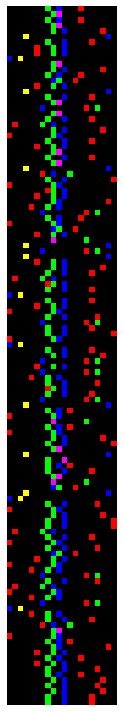

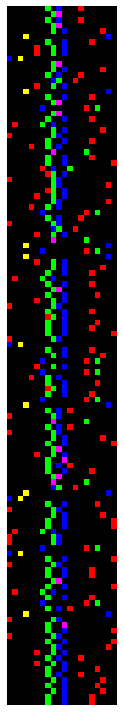

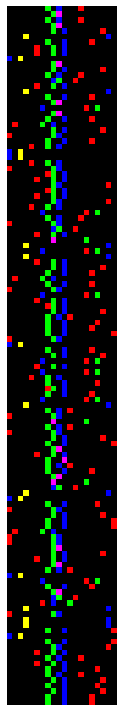

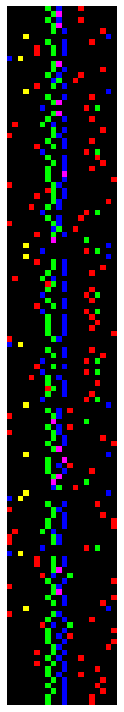

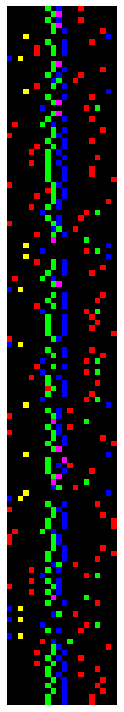

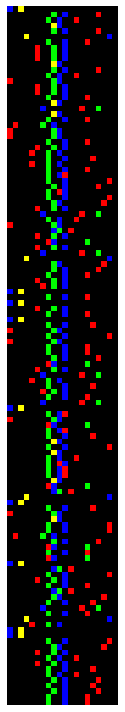

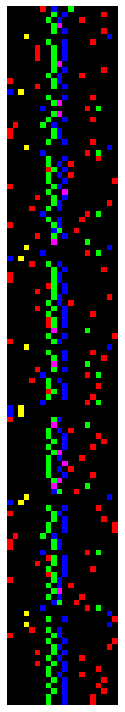

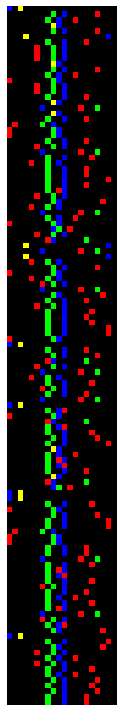

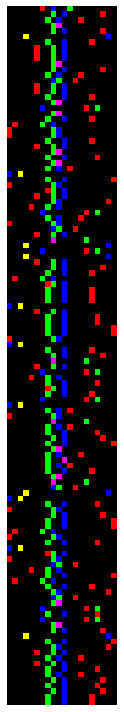

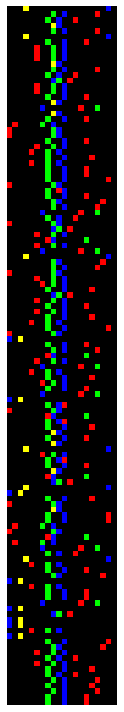

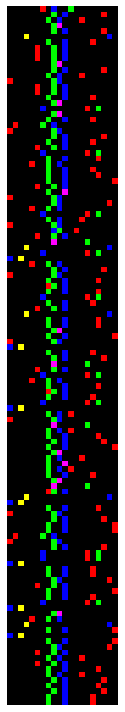

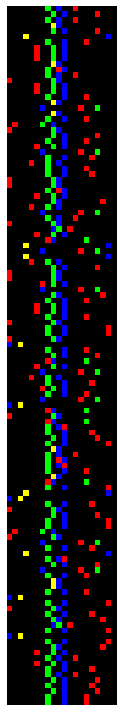

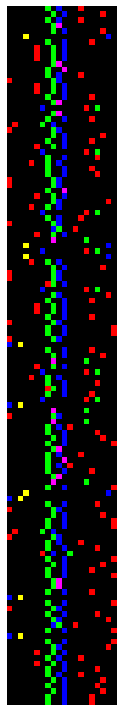

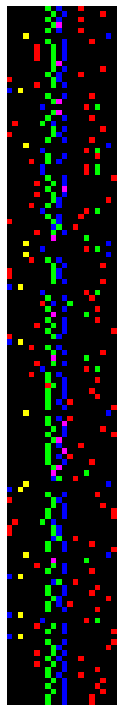

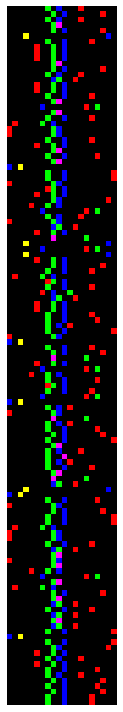

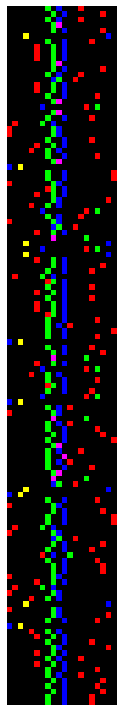

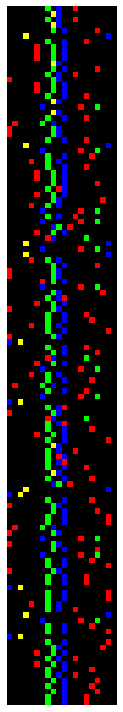

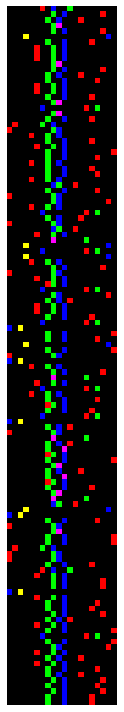

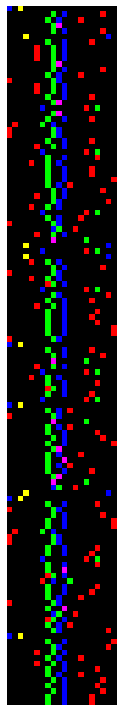

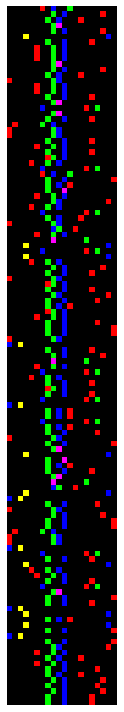

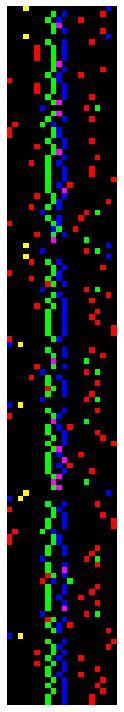

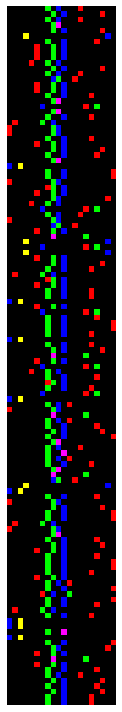

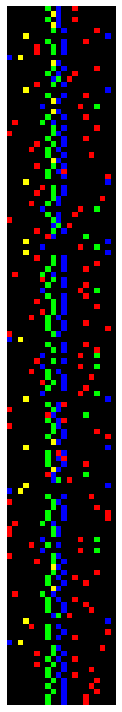

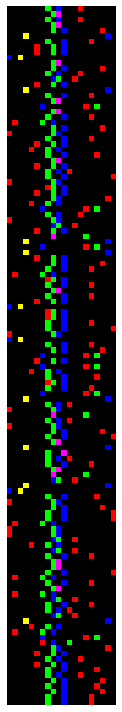

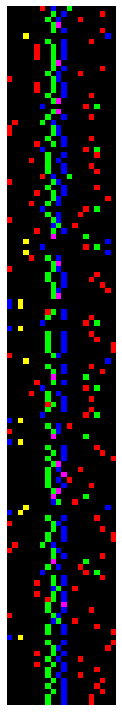

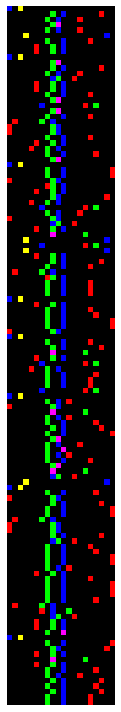

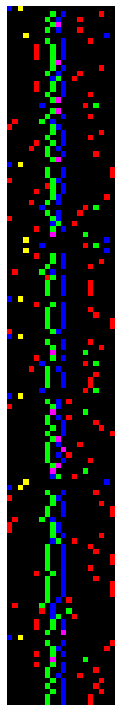

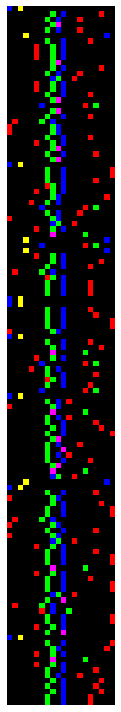

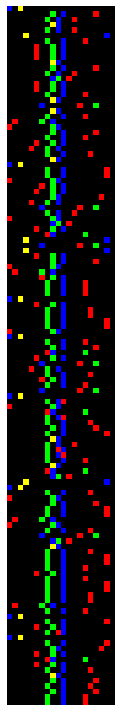

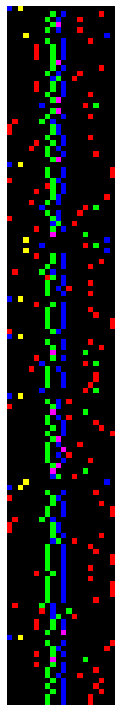

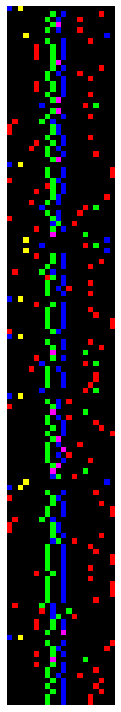

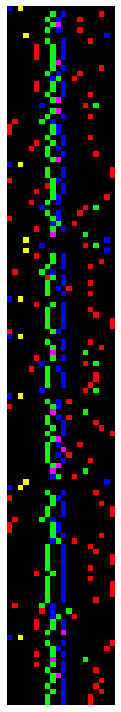

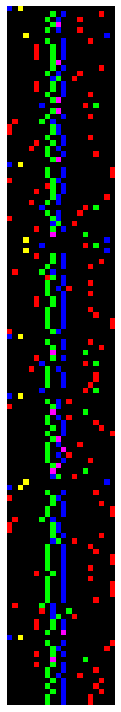

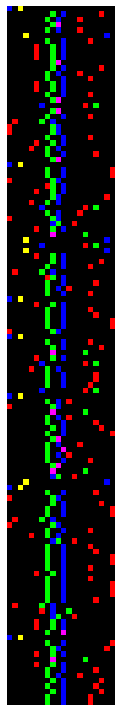

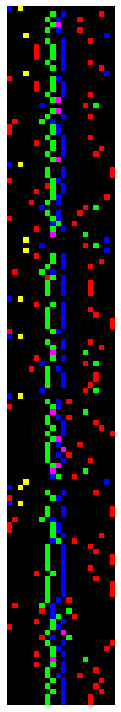

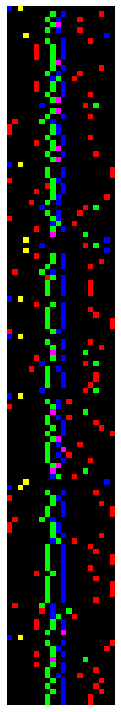

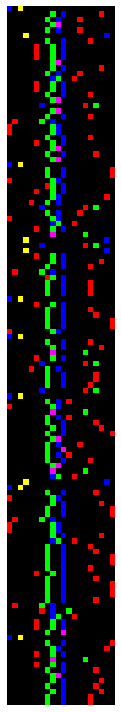

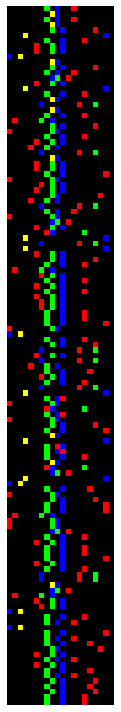

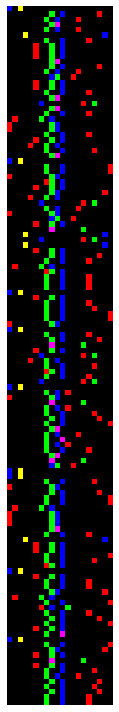

In [42]:
for c, i in enumerate(training['VHH']):
    seq_onehot = AAseq(i, dictionary)
    charge_onehot = AAcharge(i, antigenseq, dictionary, charge_df)
    hydroph_onehot = AAhydroph(i, antigenseq, dictionary, hydroph_df)
    RGBimage(seq_onehot, charge_onehot, hydroph_onehot)
    plt.savefig('/Users/adriankaufmann/Desktop/RGBimages_trainingset/positive_all/%s.png' %training['Name'][c], 
                bbox_inches='tight', pad_inches=0)
    
    

# Shuffling positive sequences:

In [43]:
# import positive sequences (meaning binding sequences)
positive = pd.read_excel('/Users/adriankaufmann/Desktop/dataset_train_num330_lenall.xlsx')

In [46]:
import random

shuffled = []
for i in positive['VHH']:
    result = ''.join(random.sample(i,len(i)))
    shuffled.append(result)
    
positive['shuffledVHH'] = shuffled

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


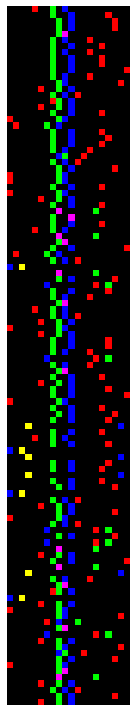

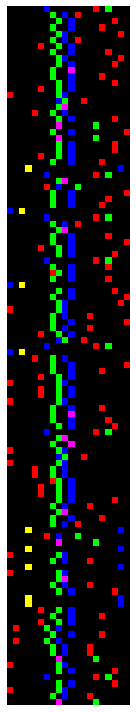

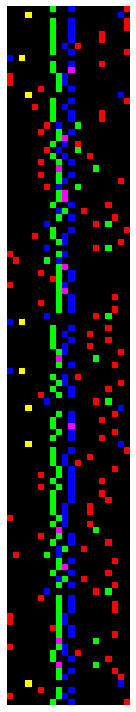

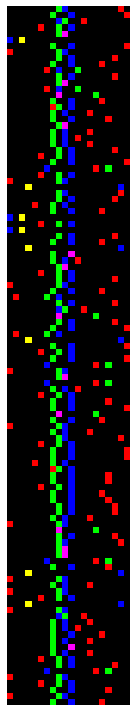

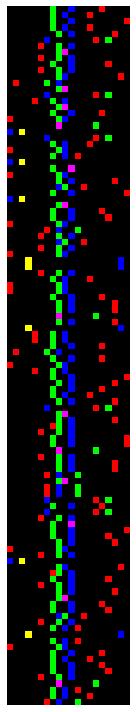

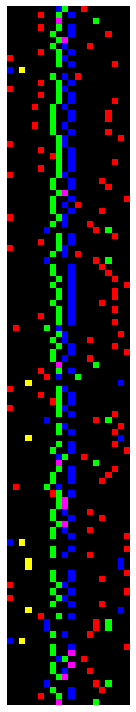

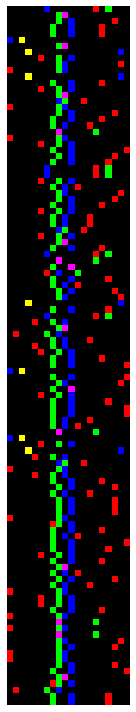

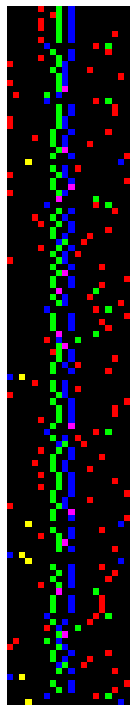

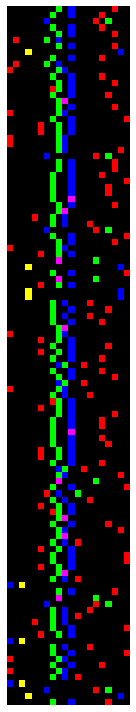

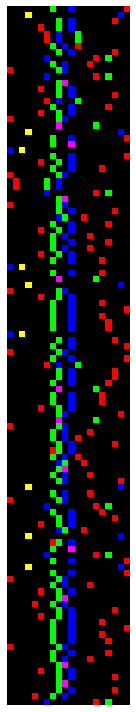

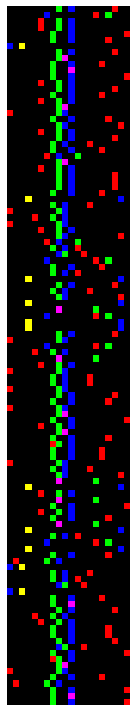

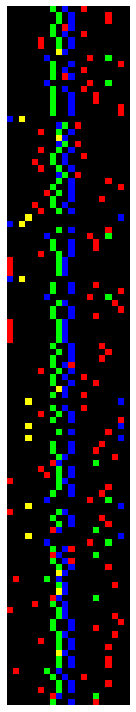

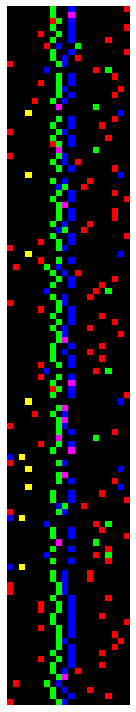

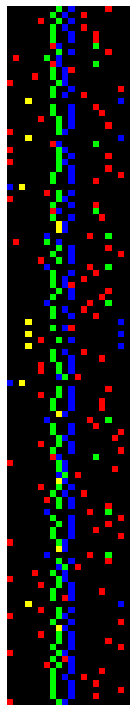

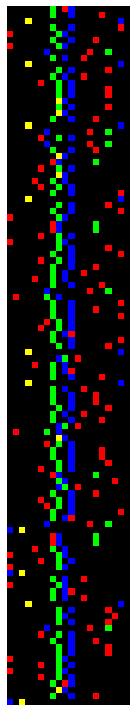

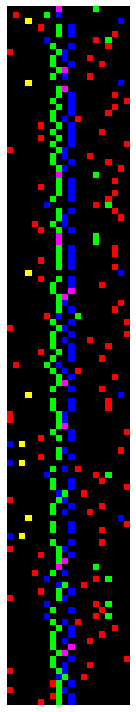

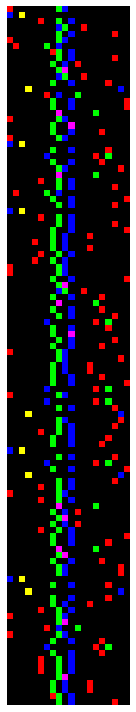

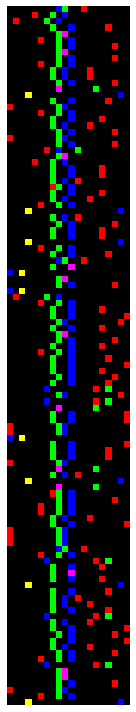

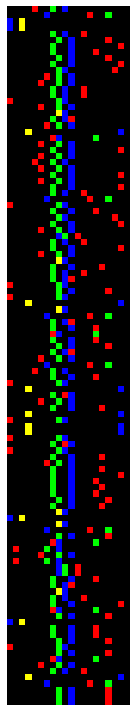

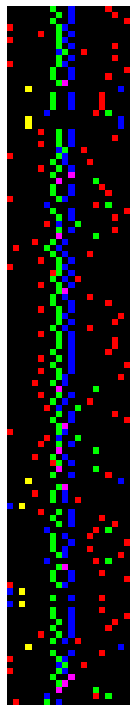

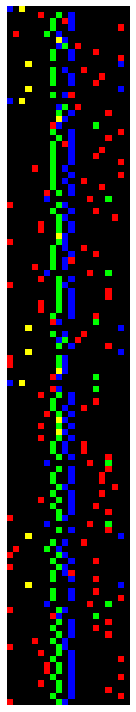

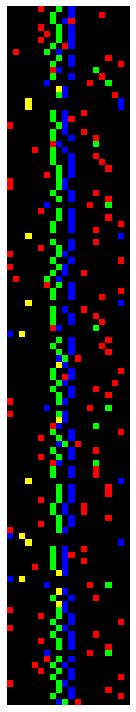

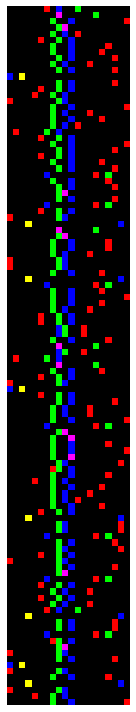

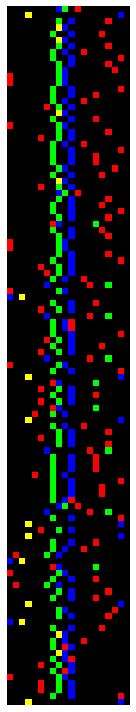

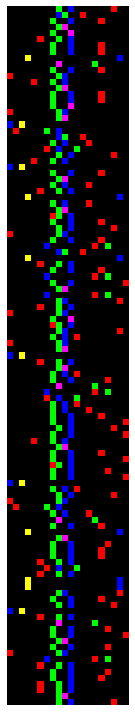

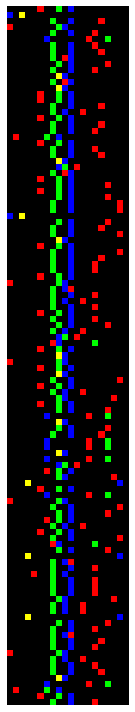

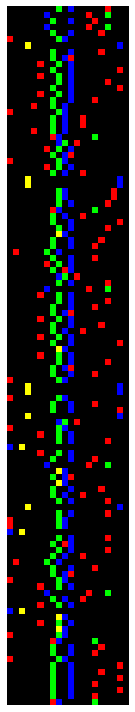

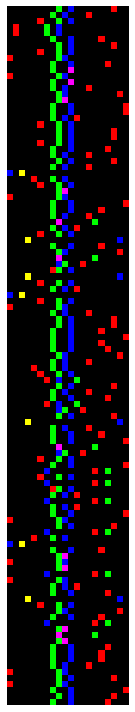

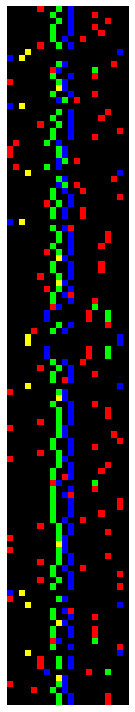

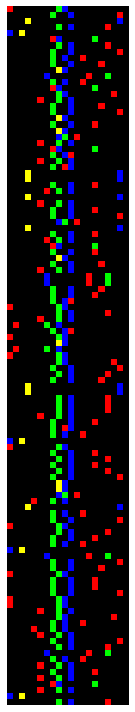

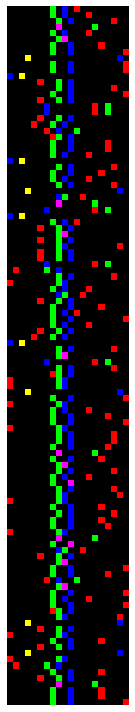

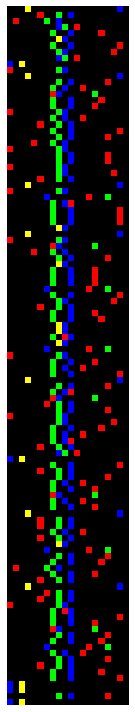

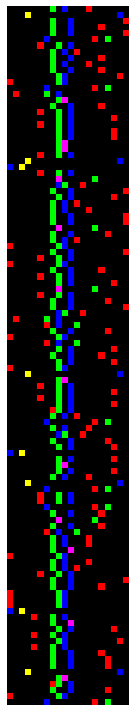

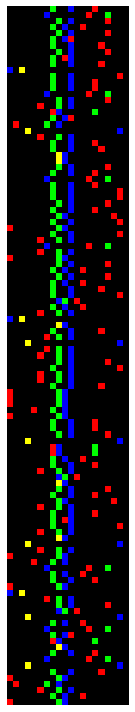

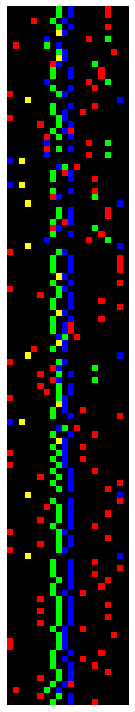

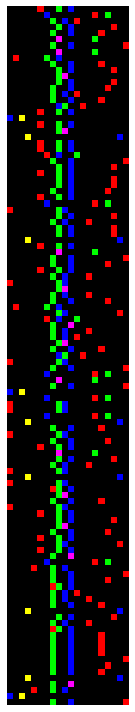

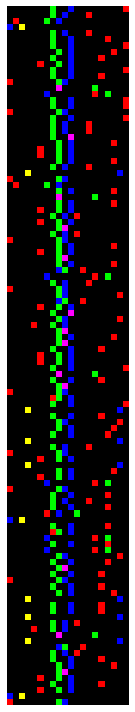

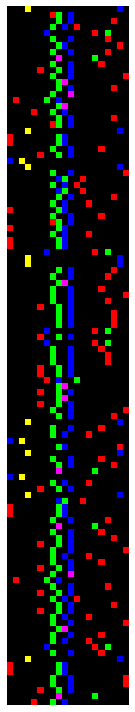

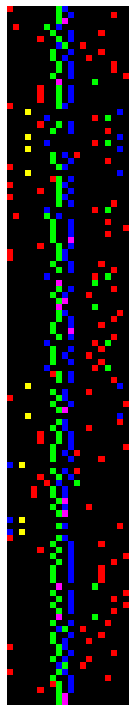

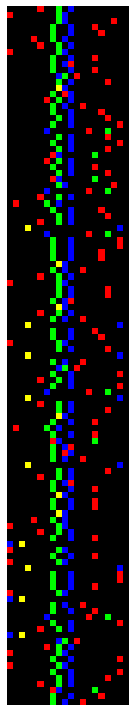

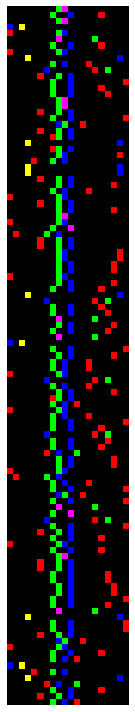

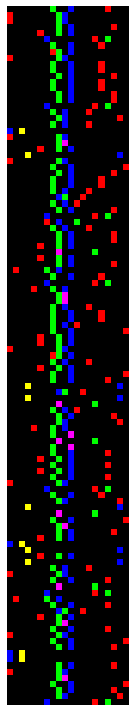

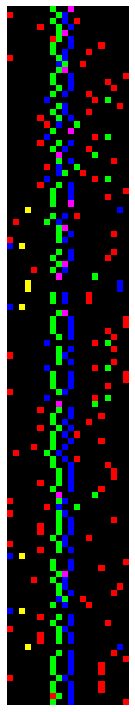

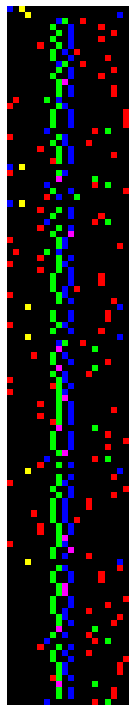

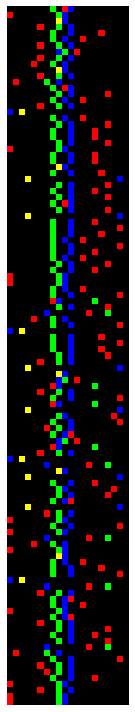

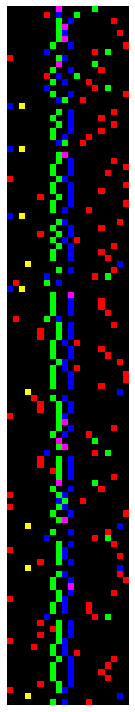

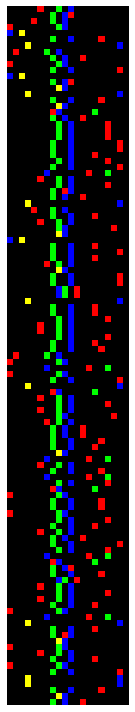

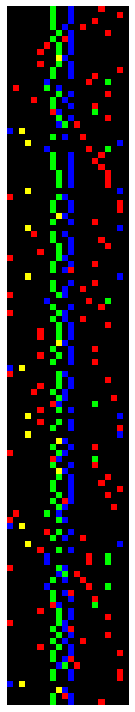

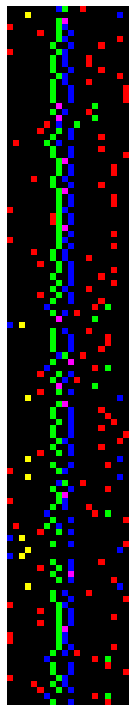

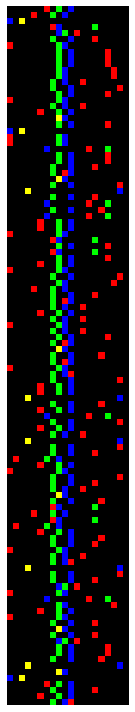

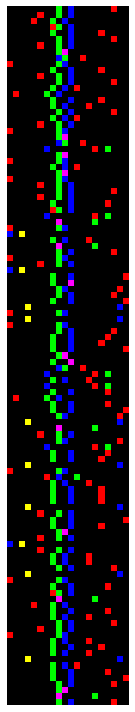

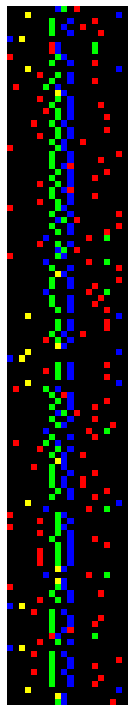

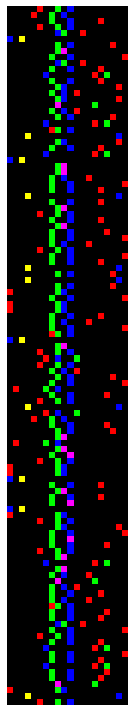

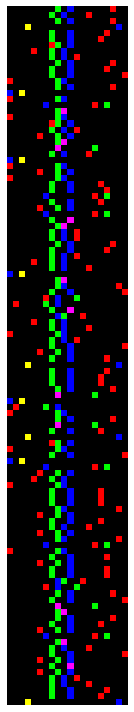

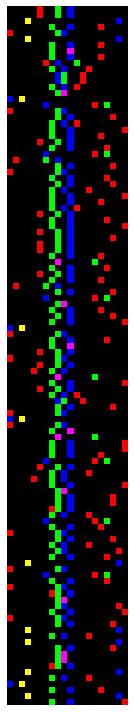

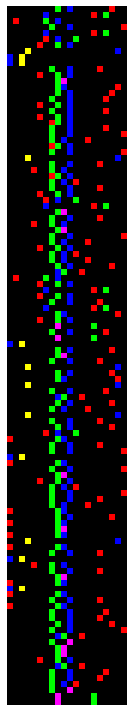

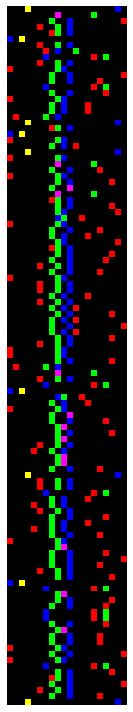

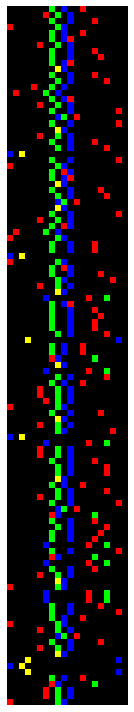

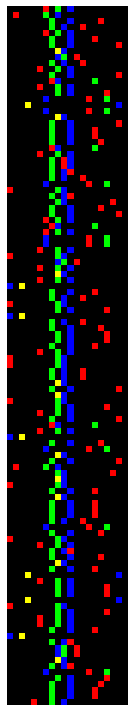

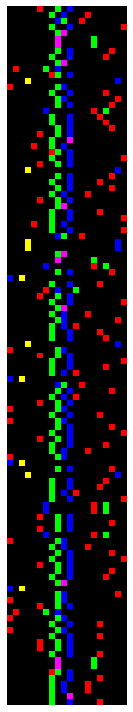

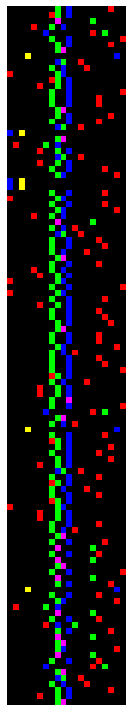

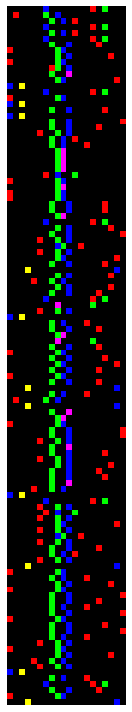

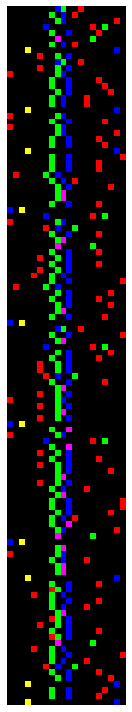

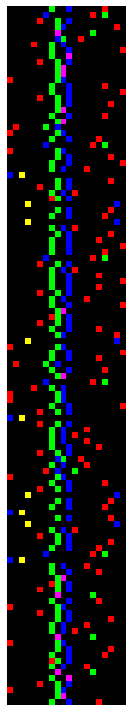

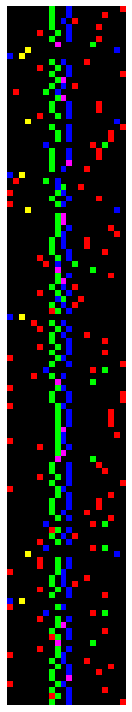

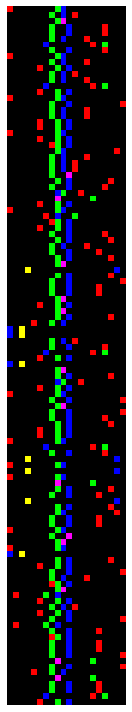

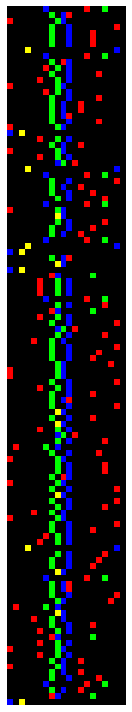

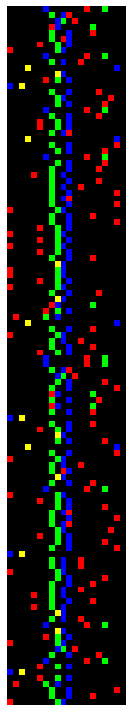

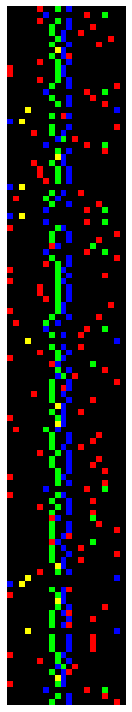

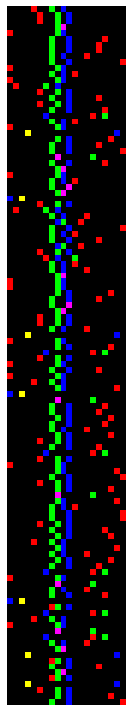

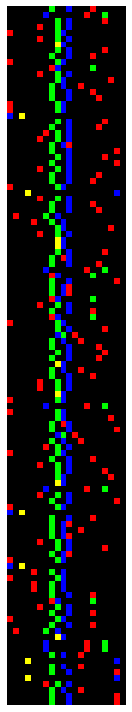

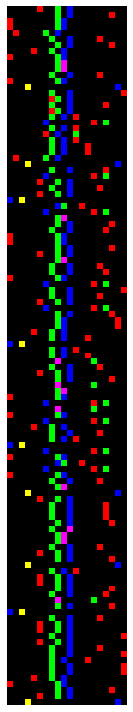

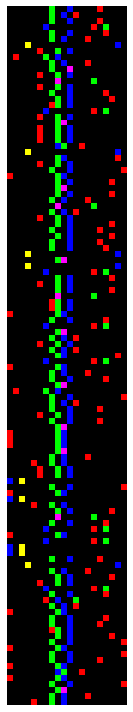

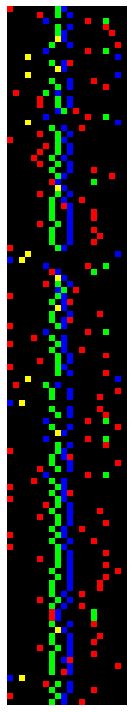

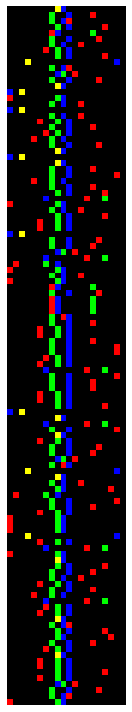

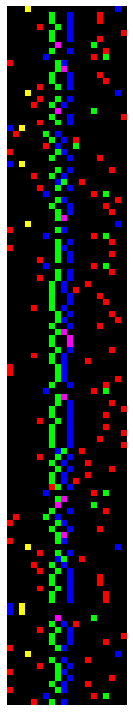

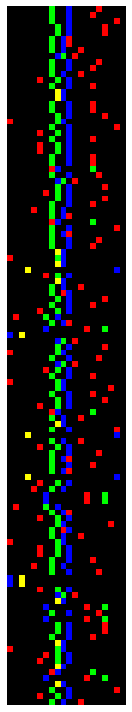

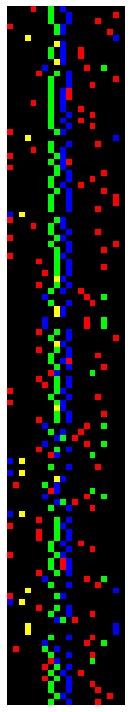

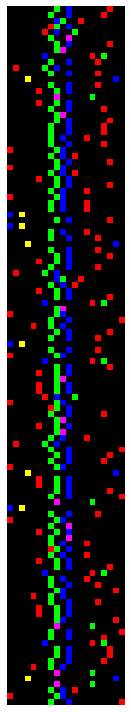

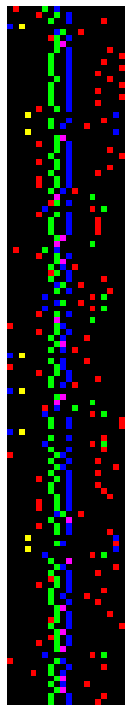

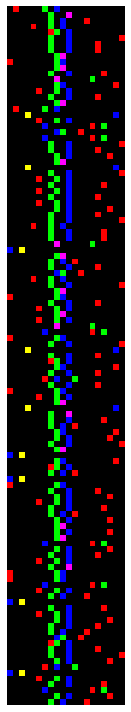

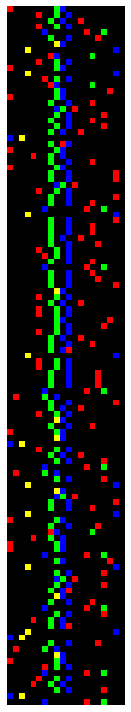

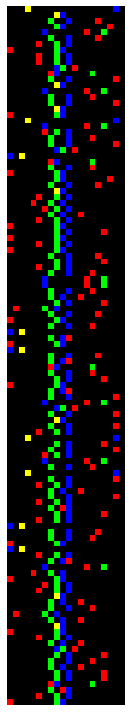

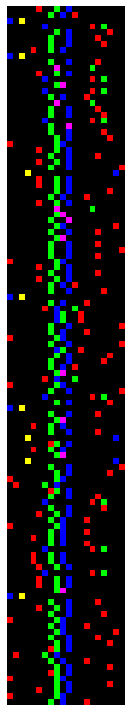

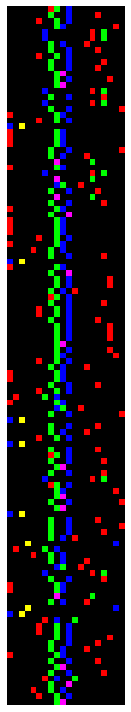

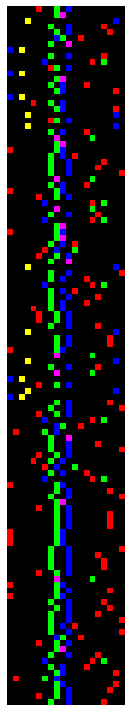

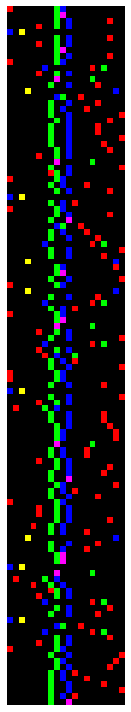

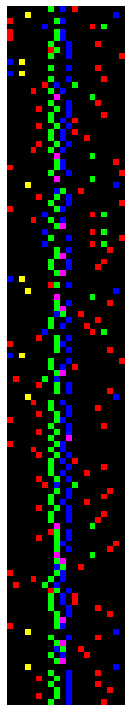

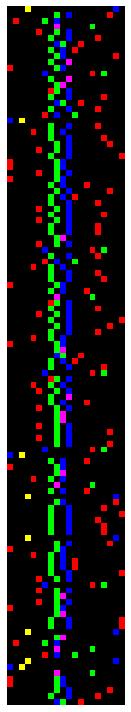

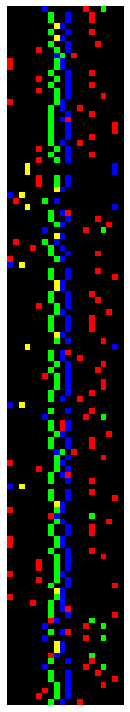

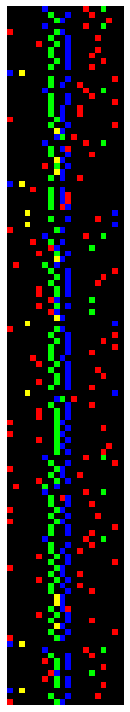

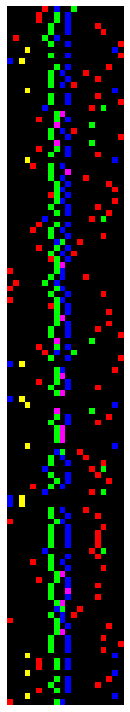

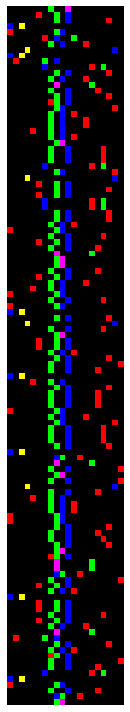

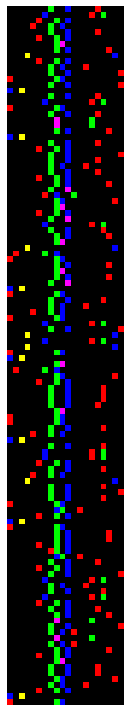

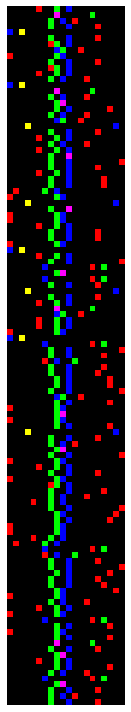

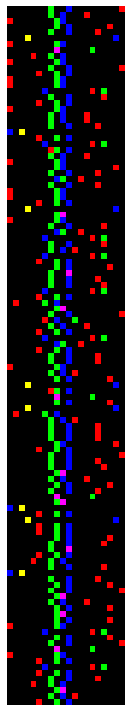

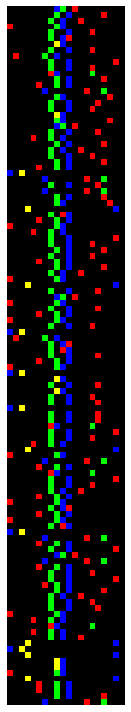

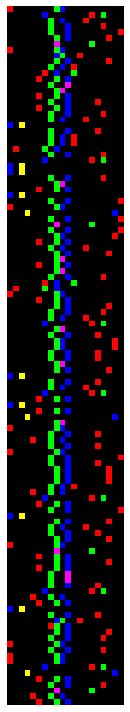

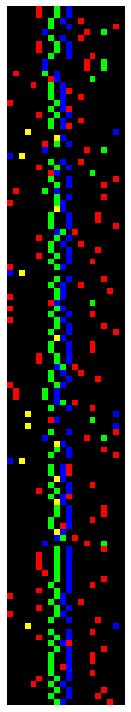

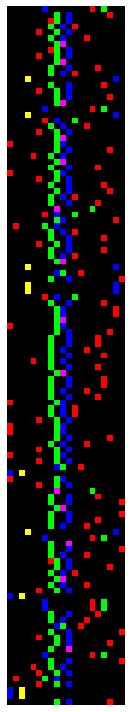

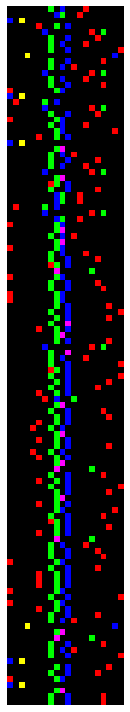

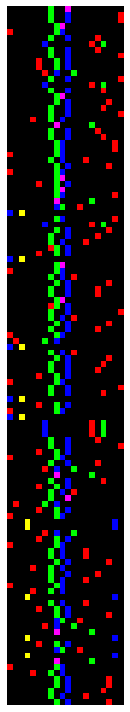

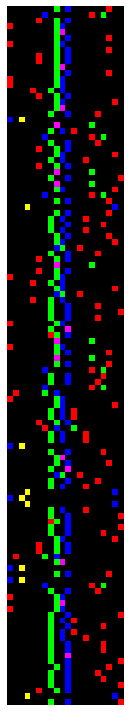

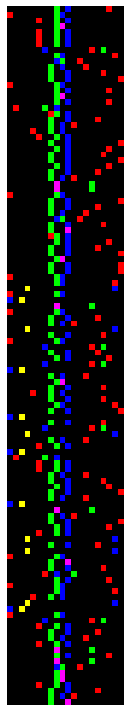

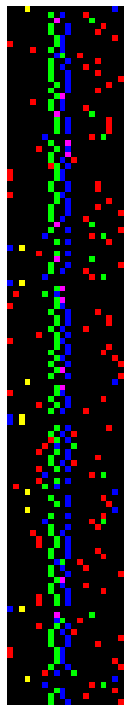

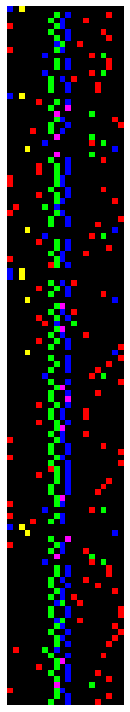

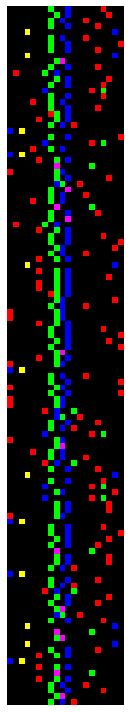

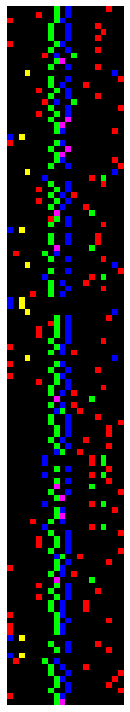

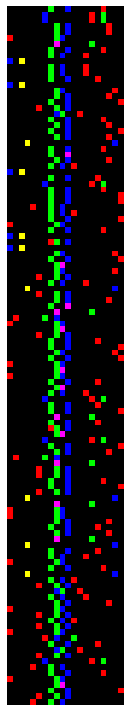

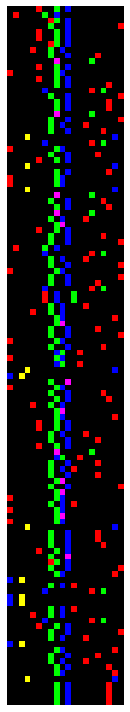

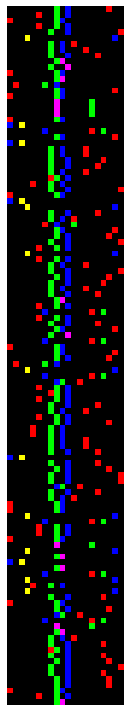

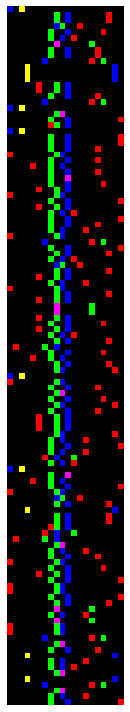

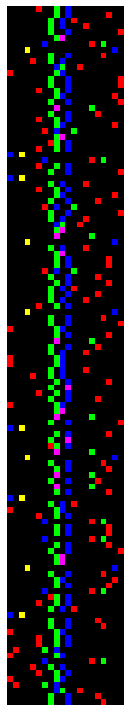

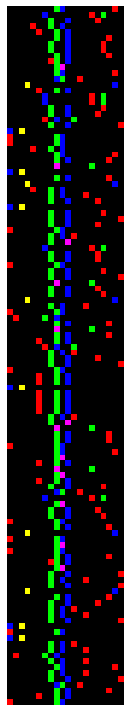

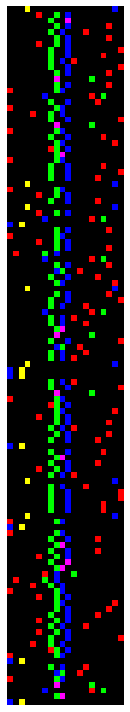

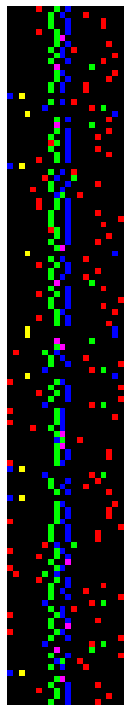

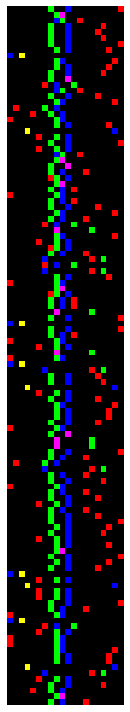

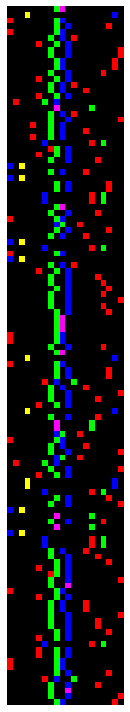

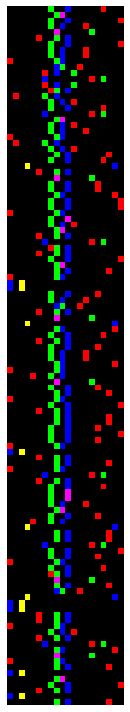

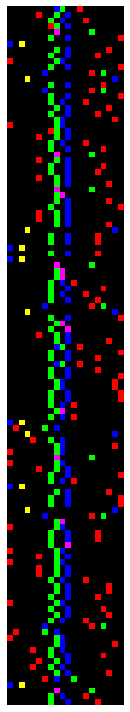

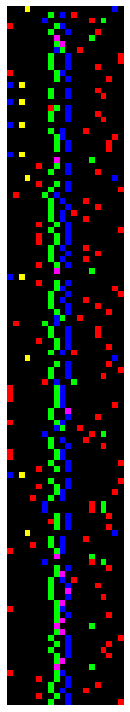

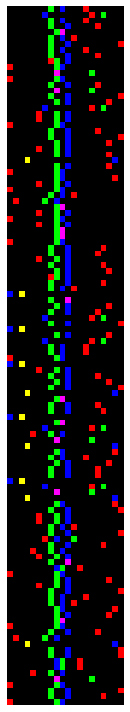

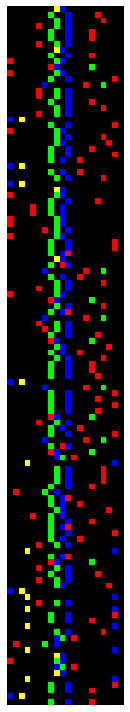

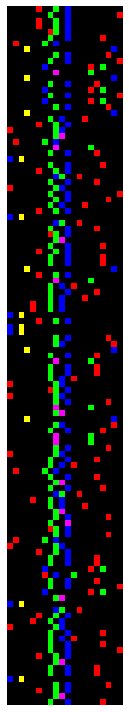

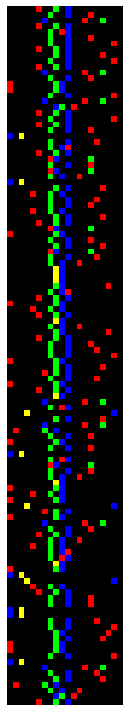

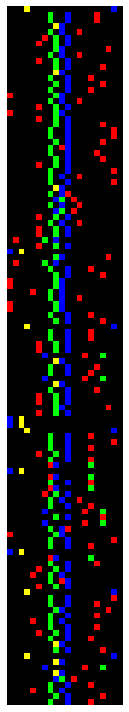

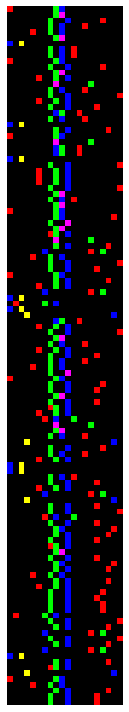

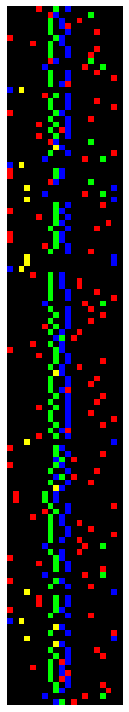

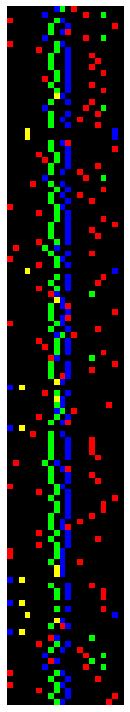

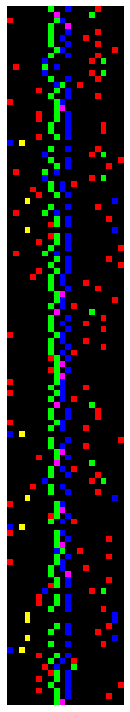

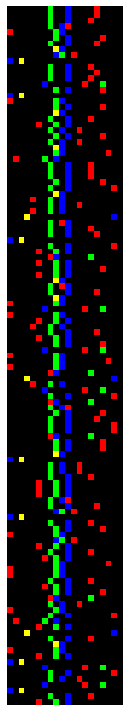

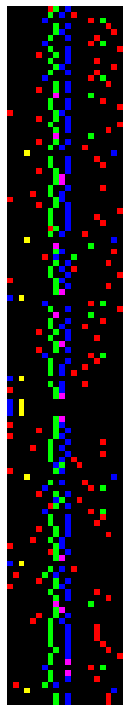

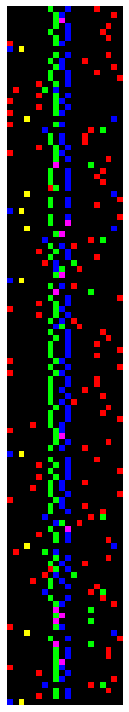

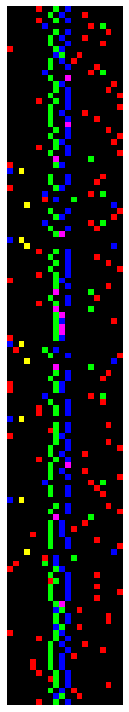

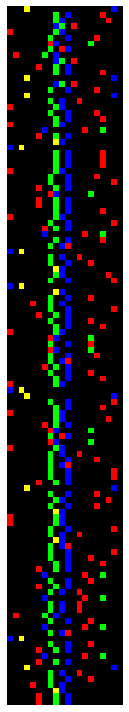

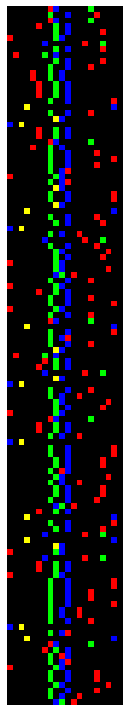

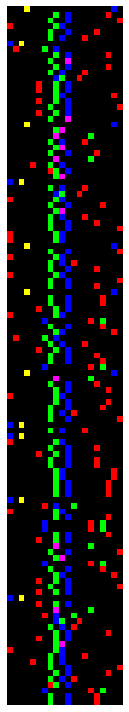

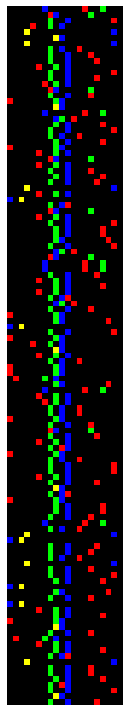

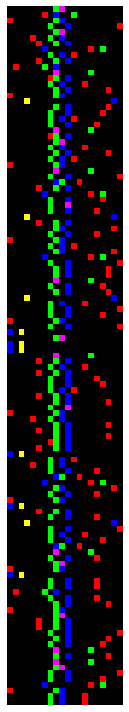

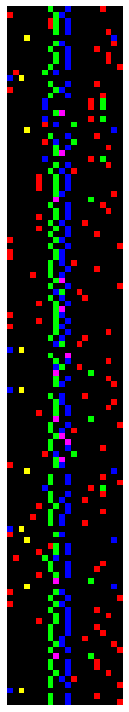

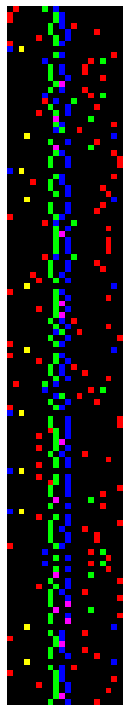

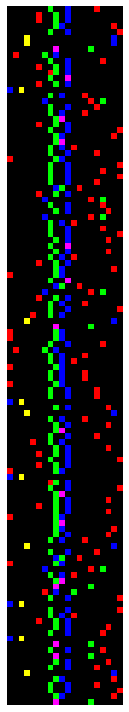

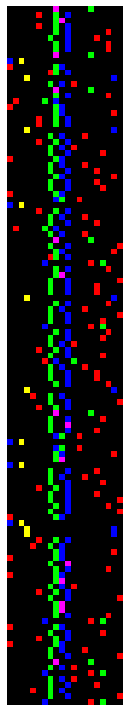

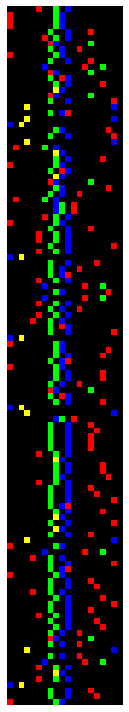

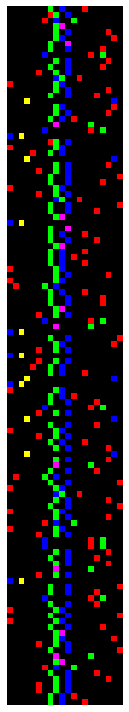

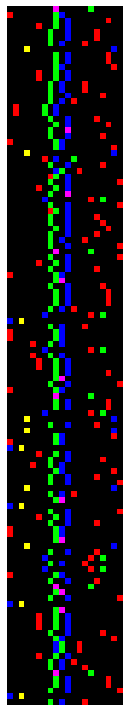

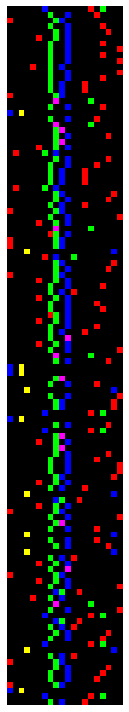

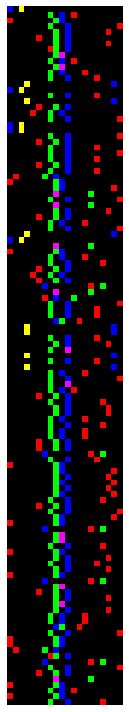

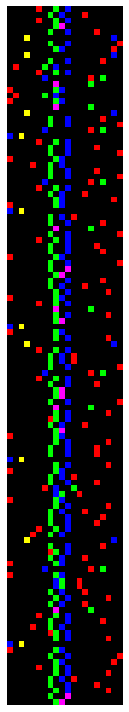

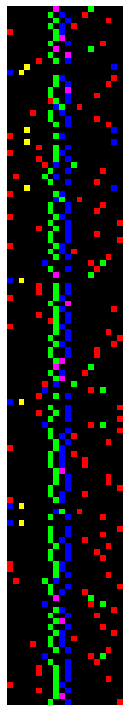

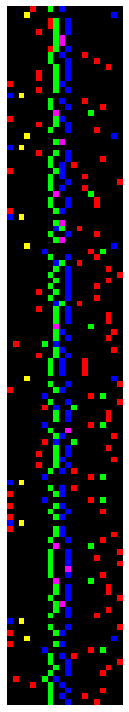

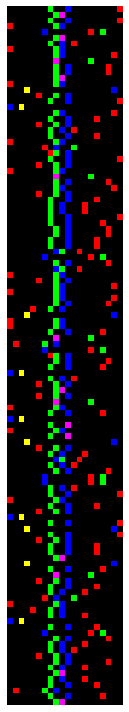

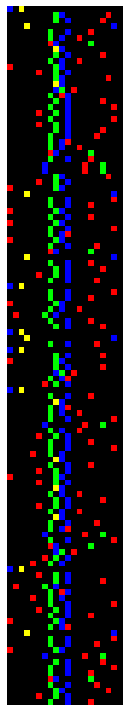

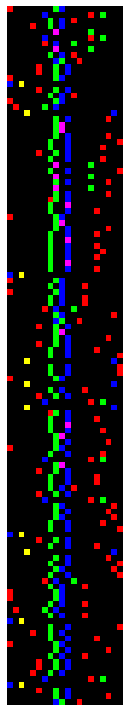

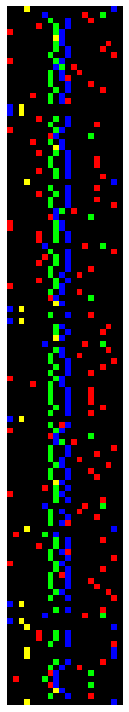

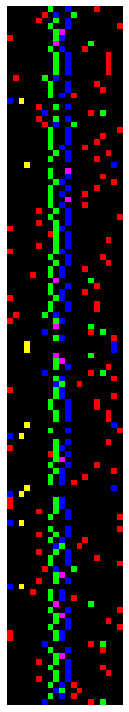

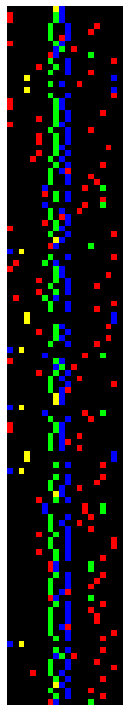

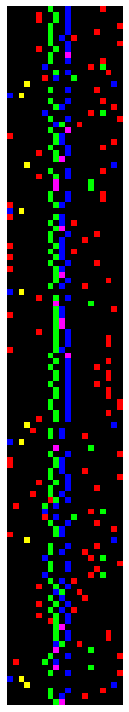

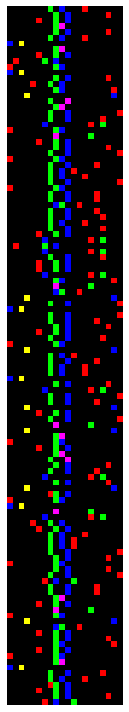

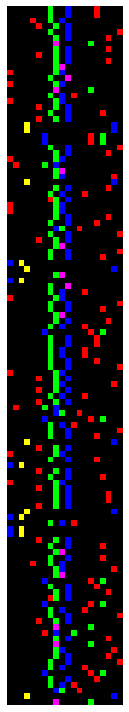

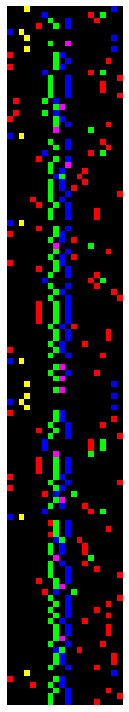

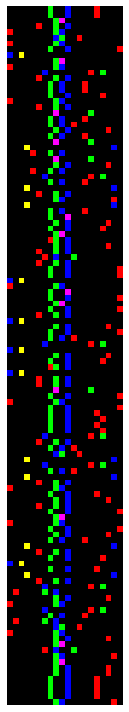

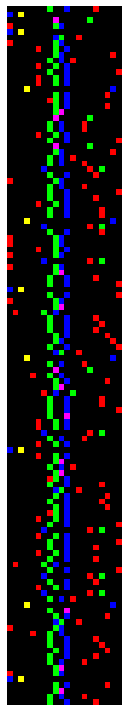

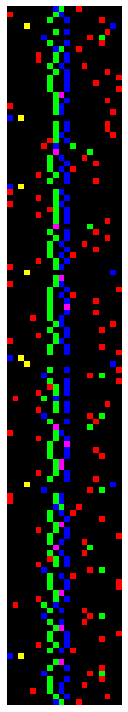

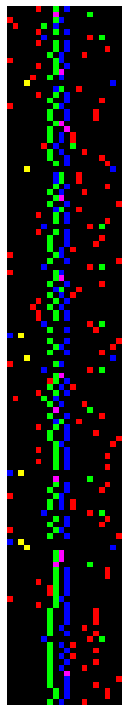

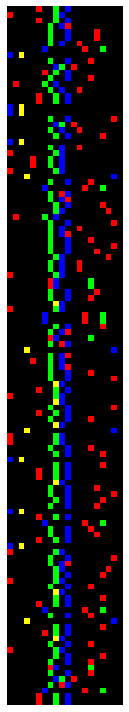

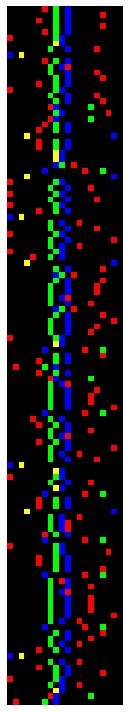

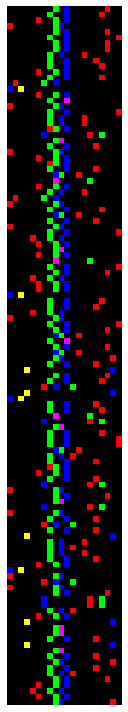

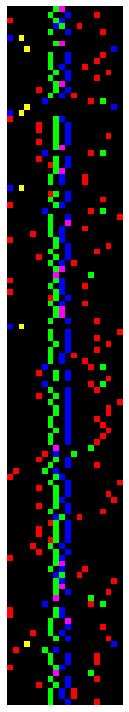

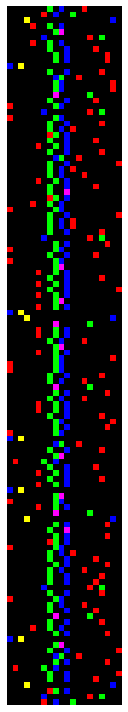

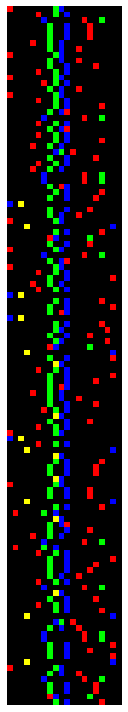

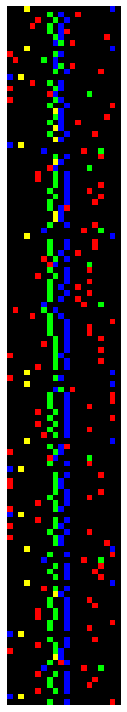

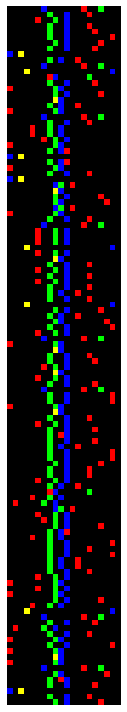

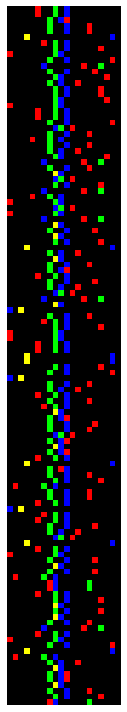

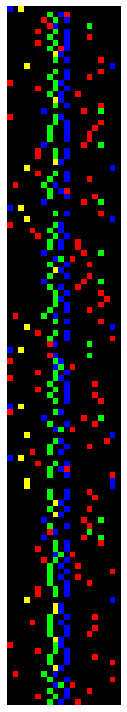

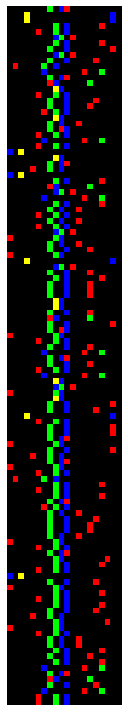

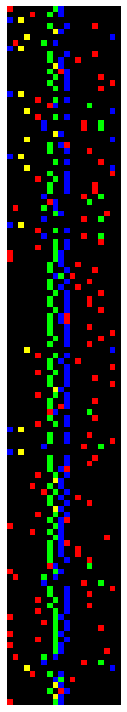

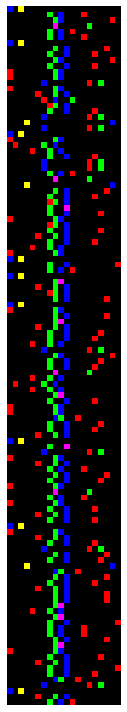

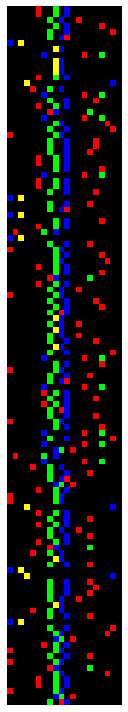

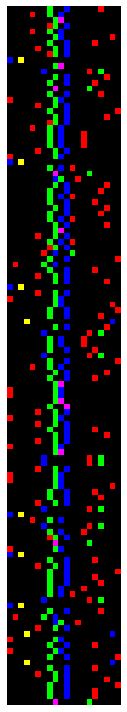

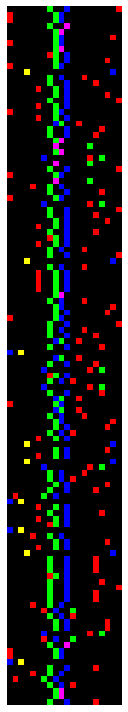

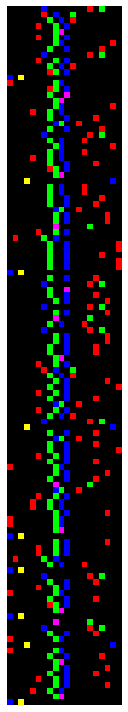

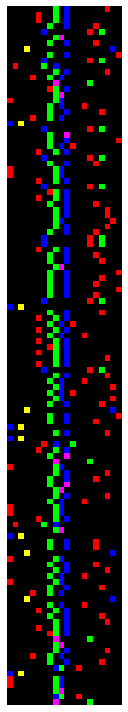

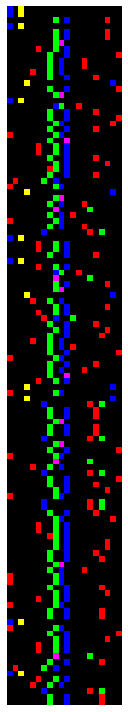

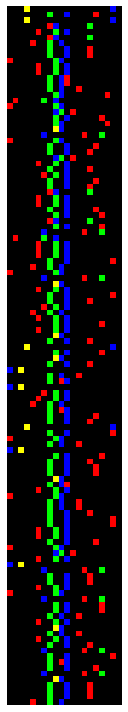

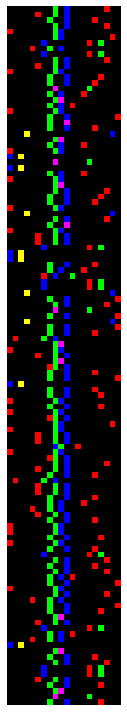

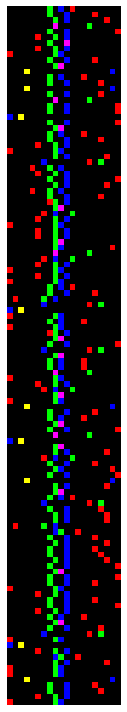

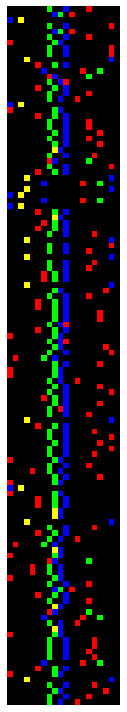

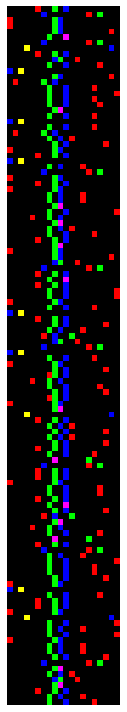

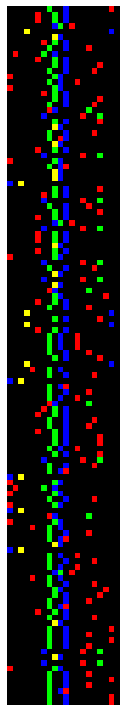

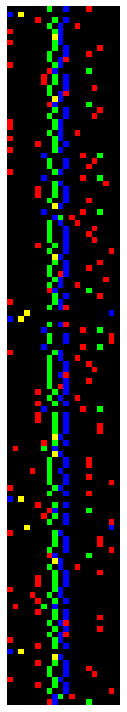

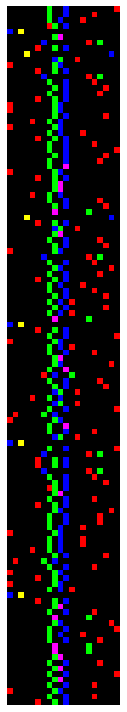

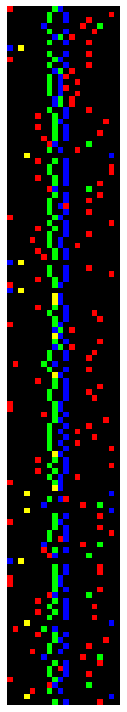

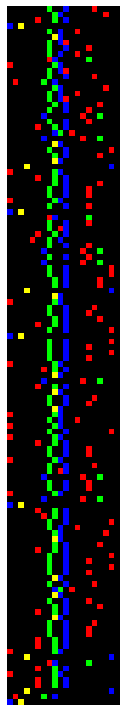

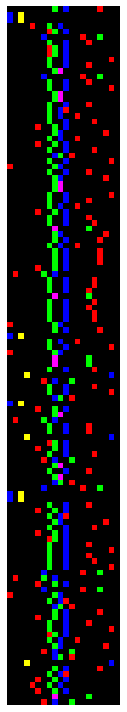

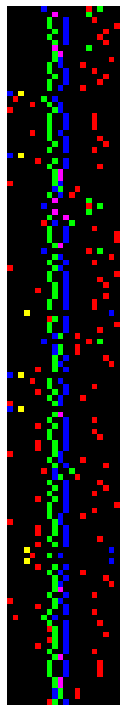

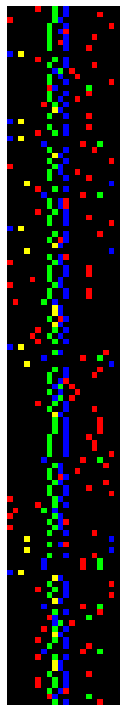

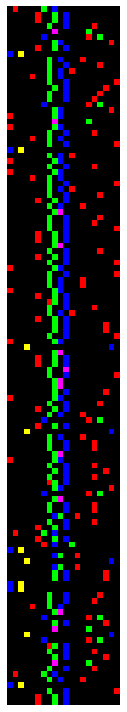

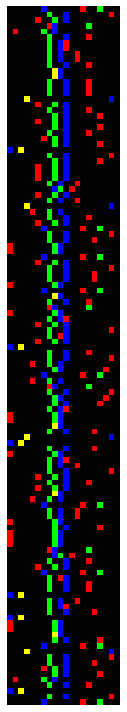

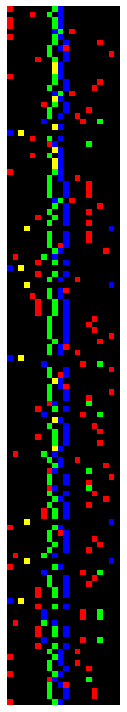

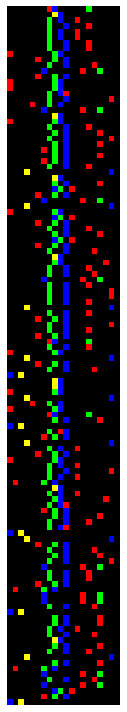

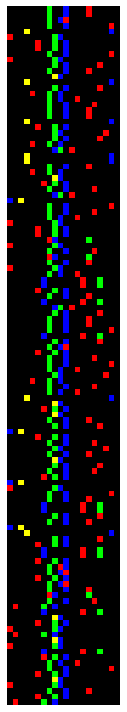

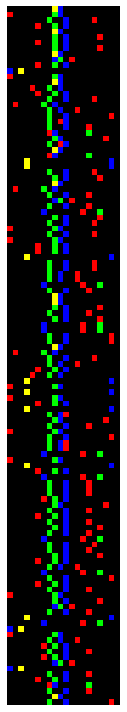

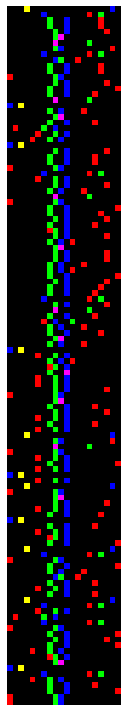

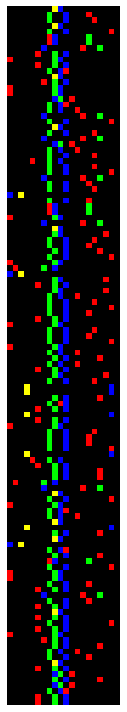

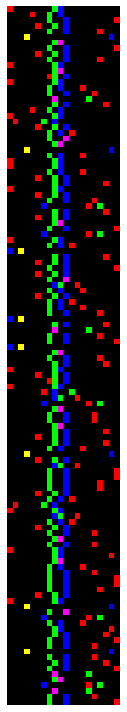

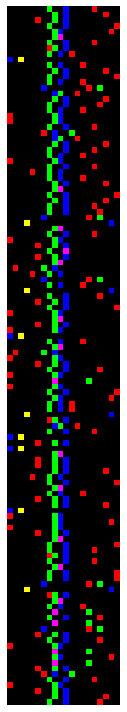

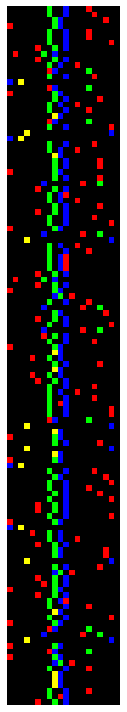

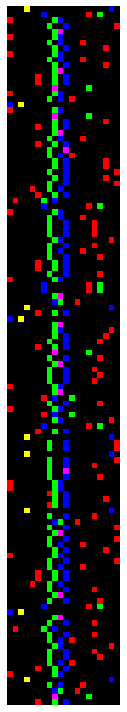

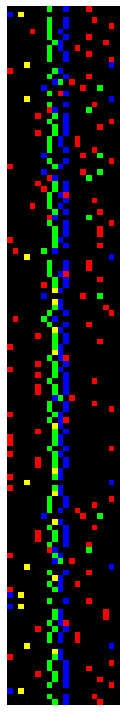

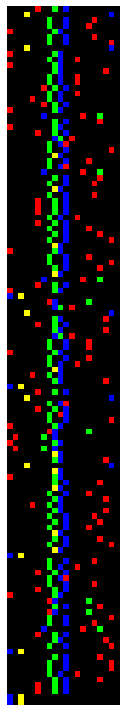

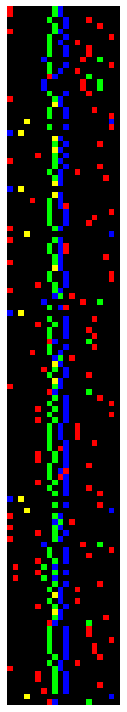

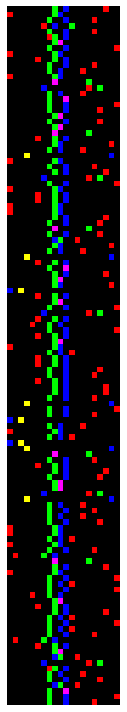

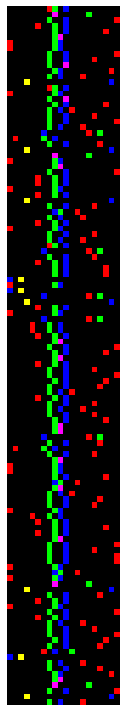

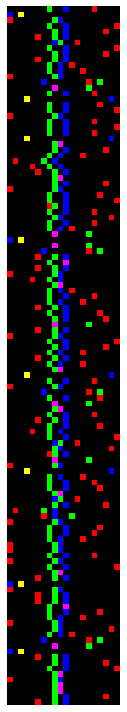

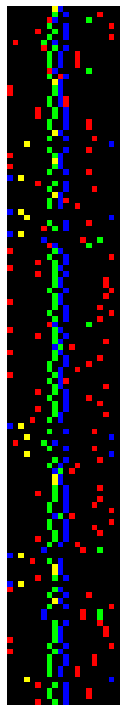

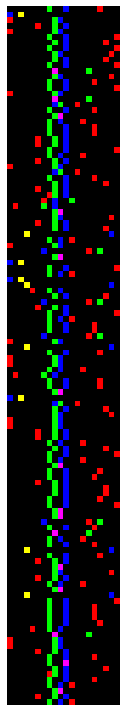

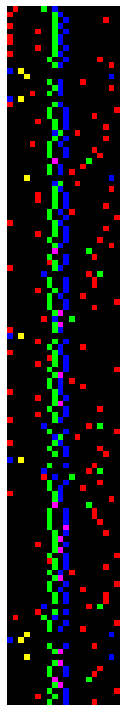

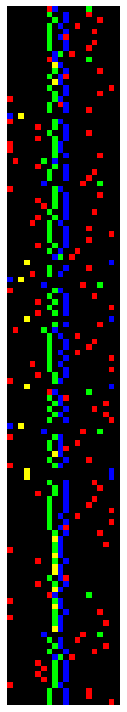

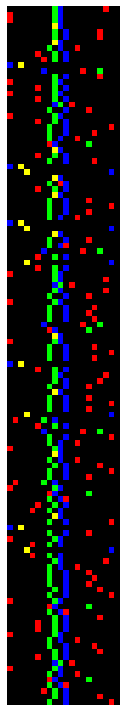

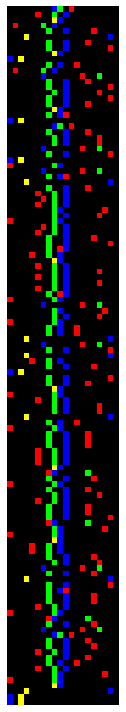

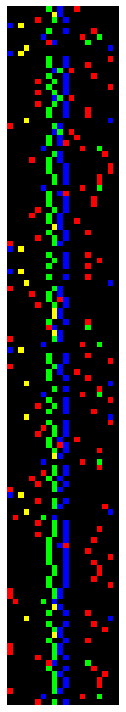

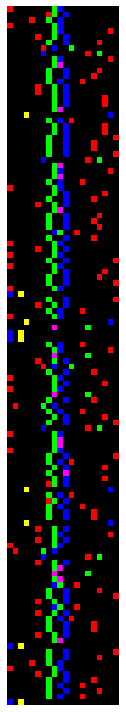

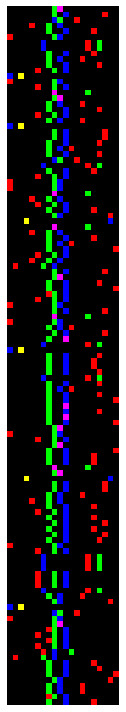

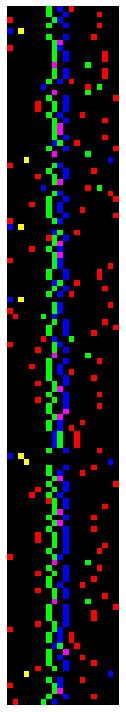

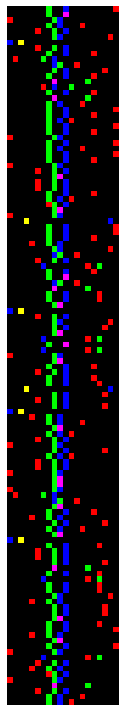

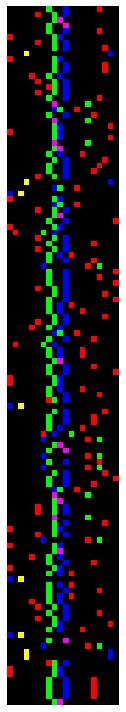

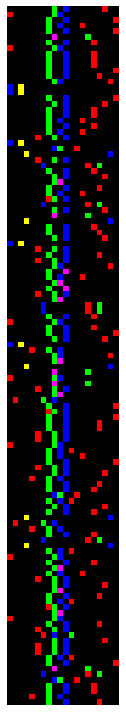

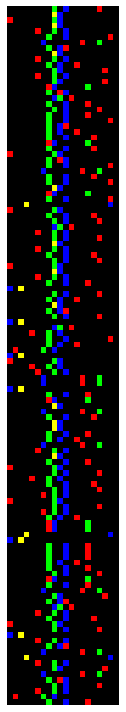

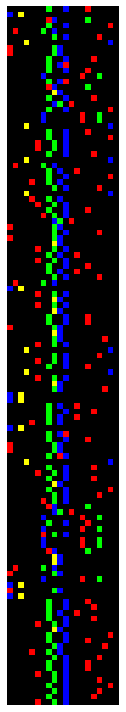

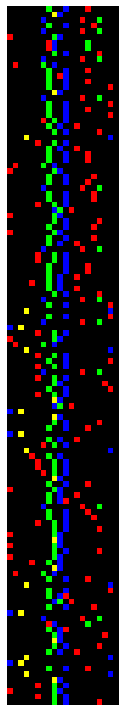

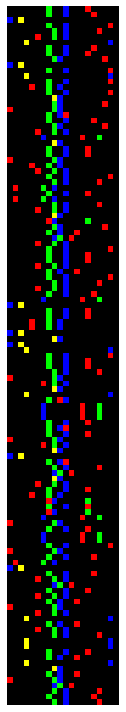

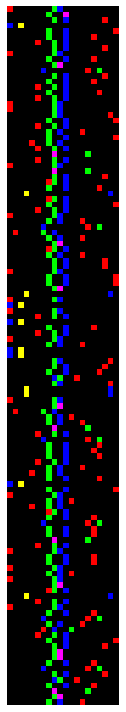

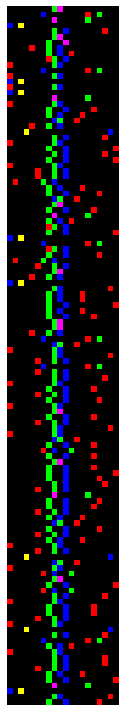

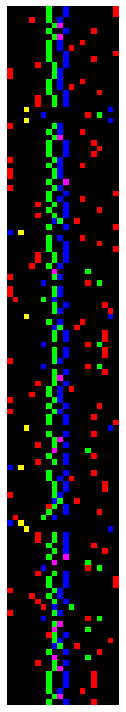

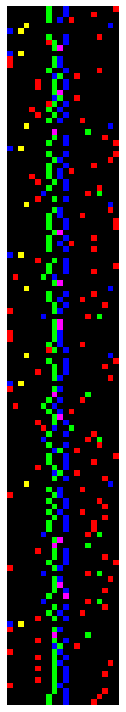

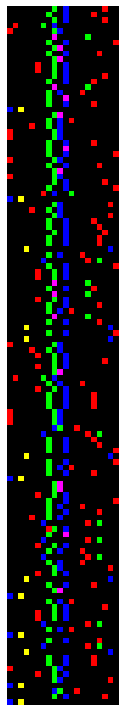

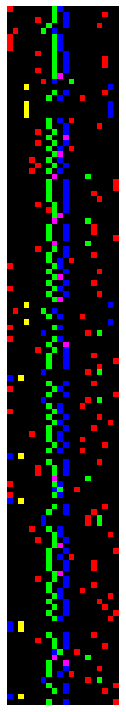

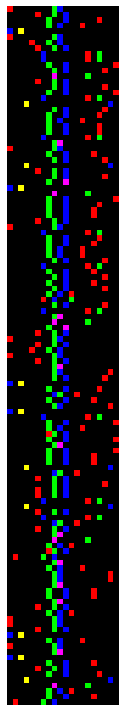

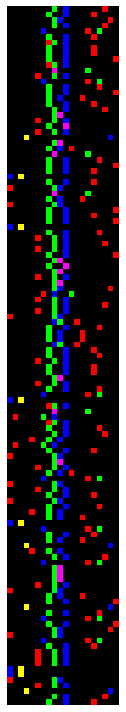

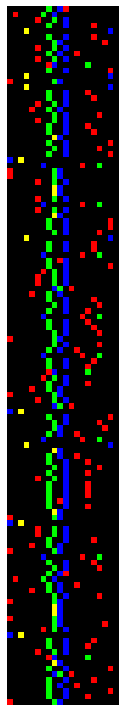

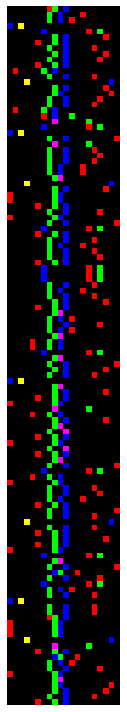

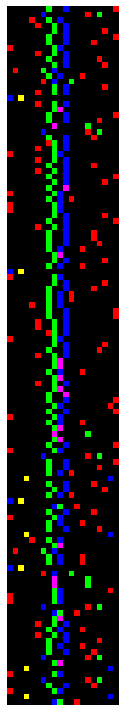

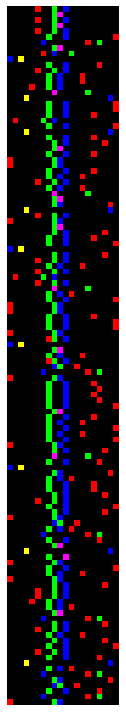

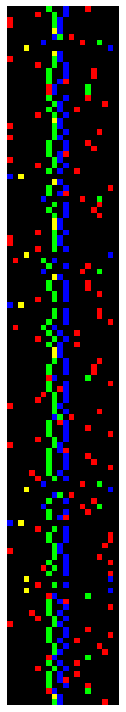

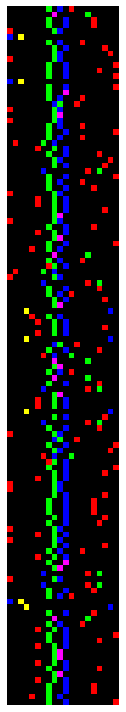

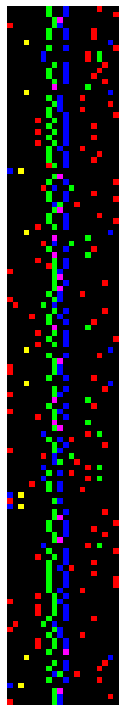

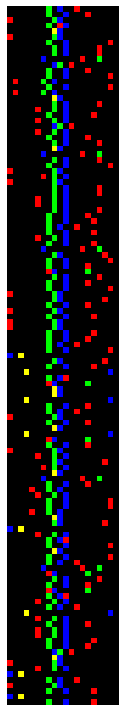

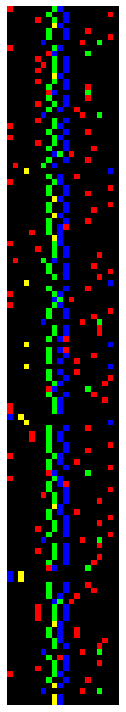

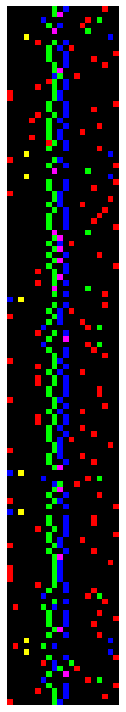

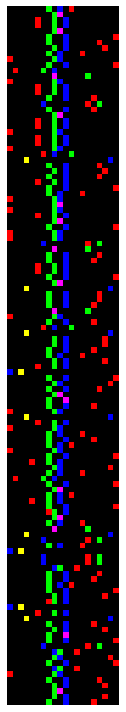

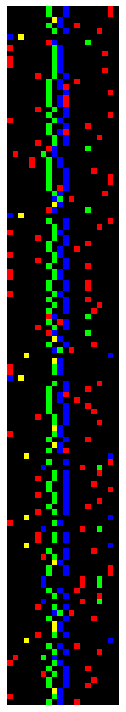

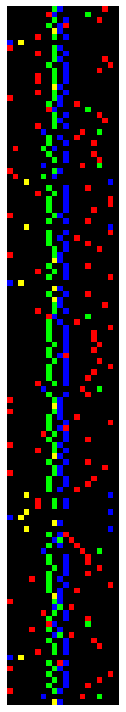

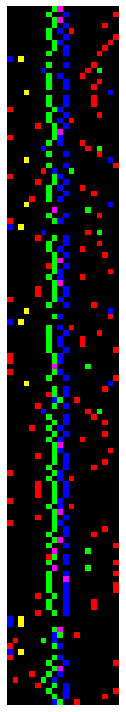

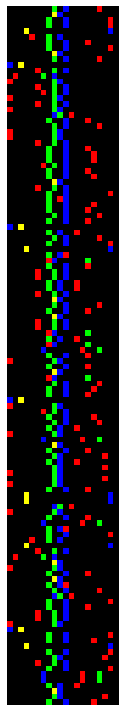

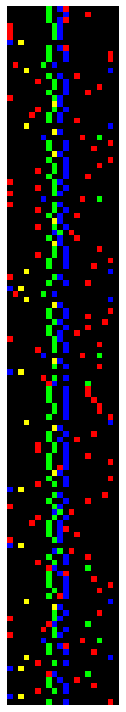

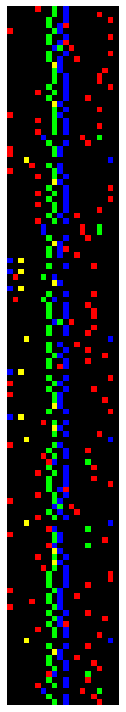

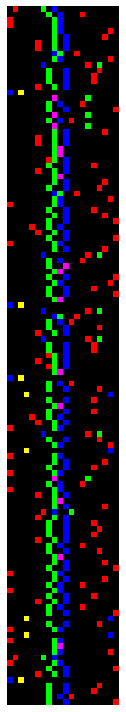

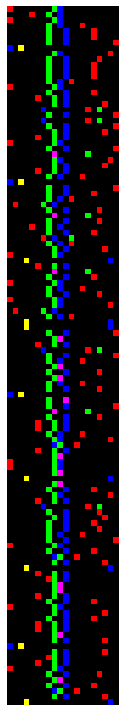

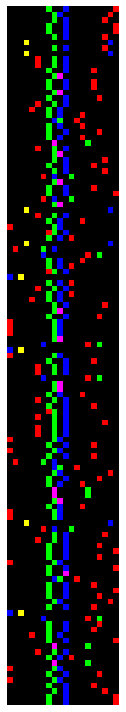

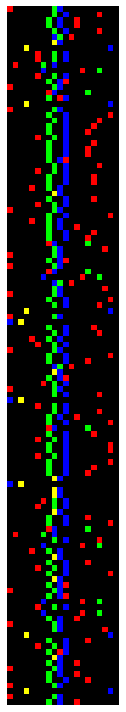

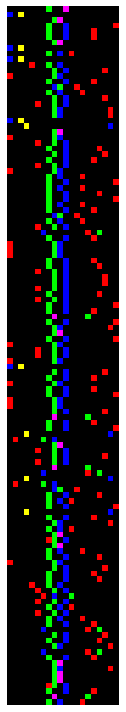

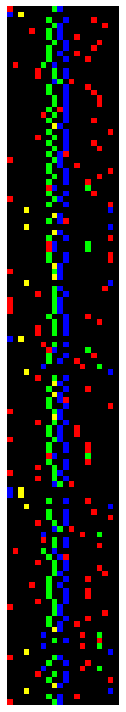

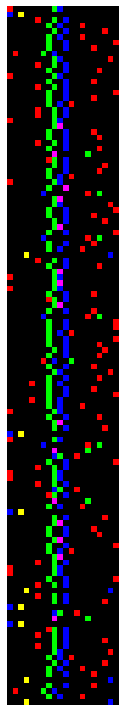

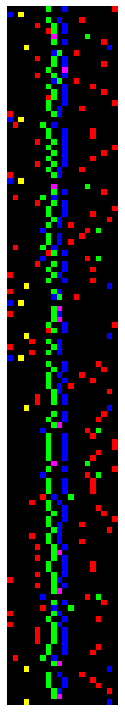

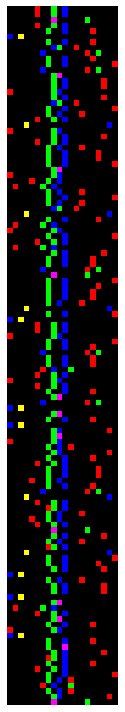

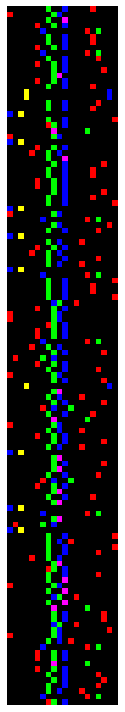

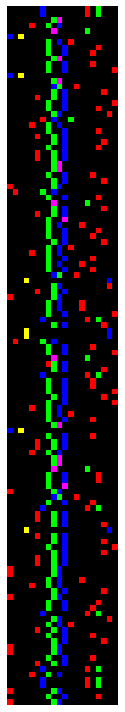

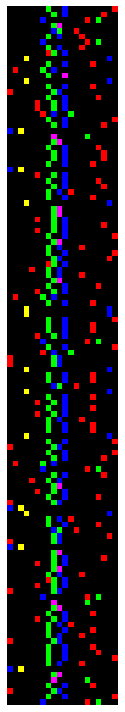

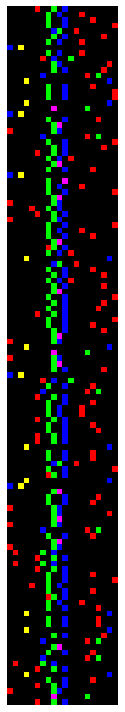

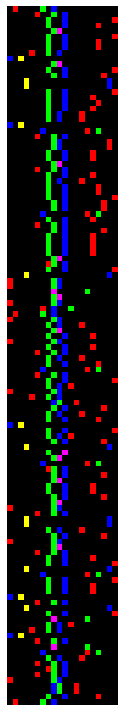

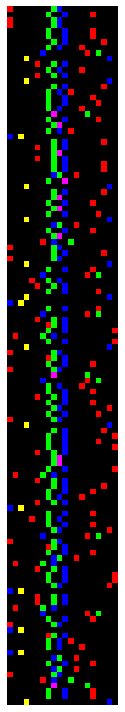

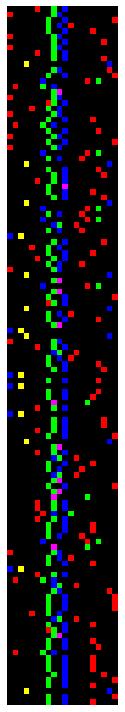

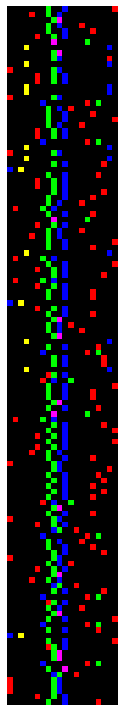

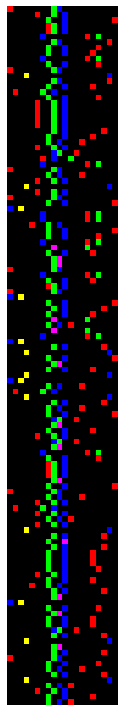

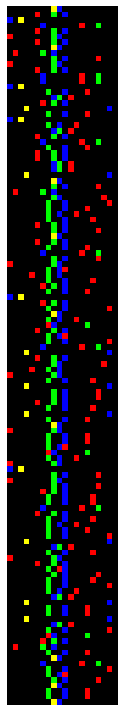

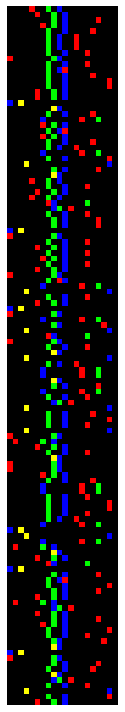

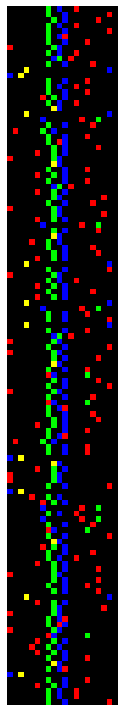

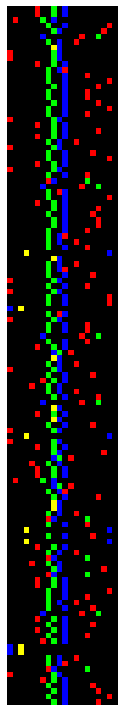

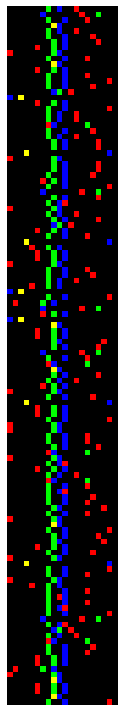

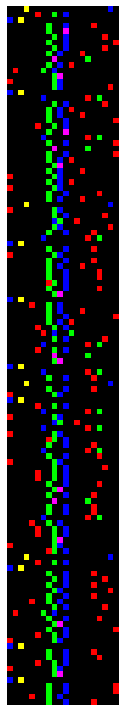

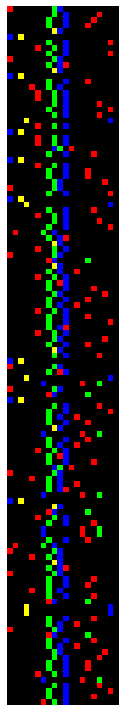

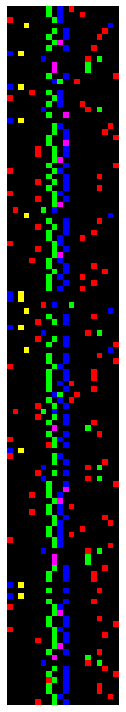

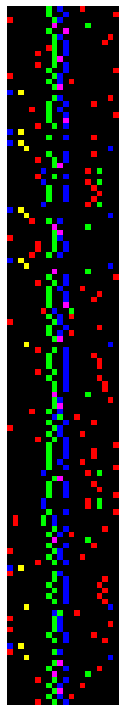

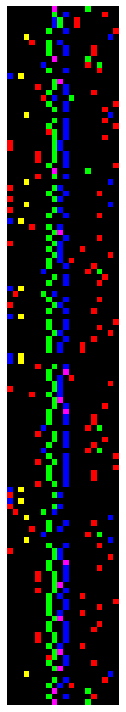

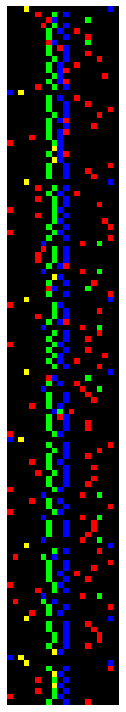

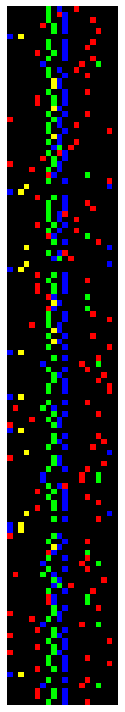

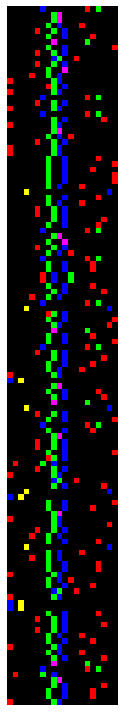

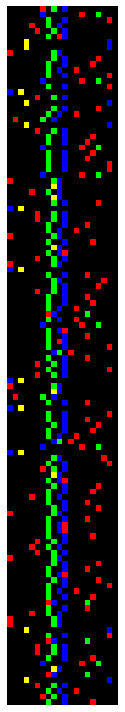

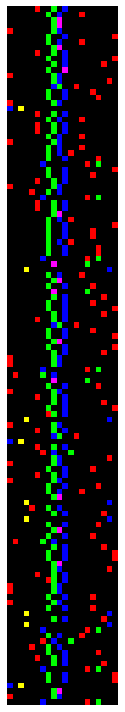

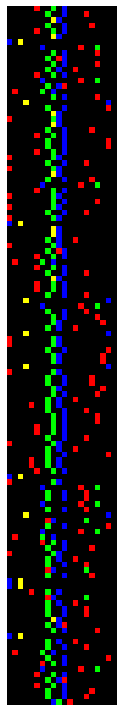

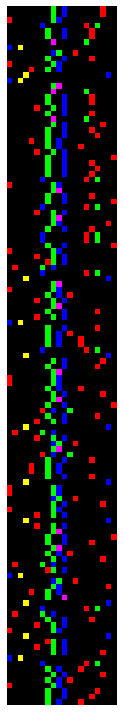

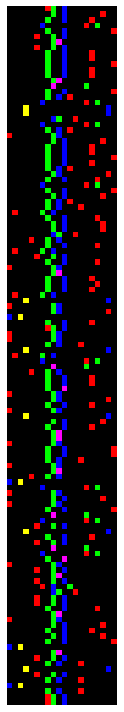

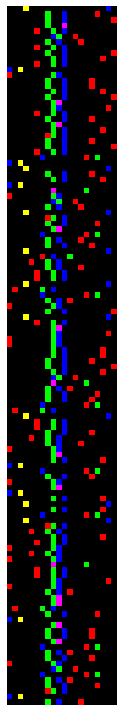

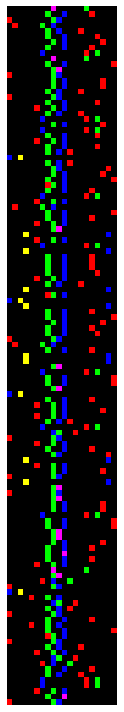

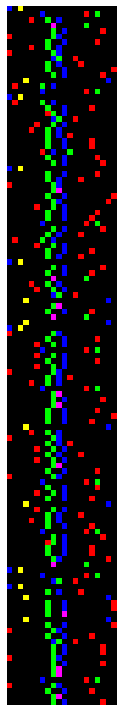

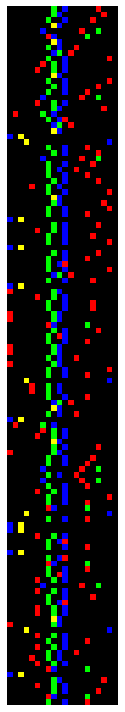

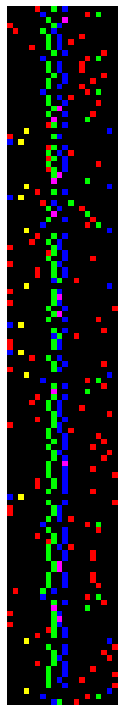

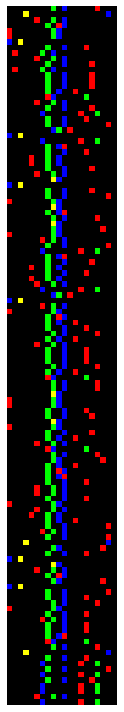

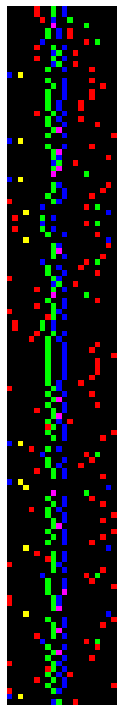

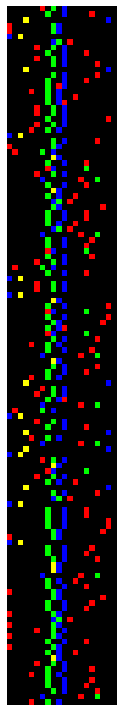

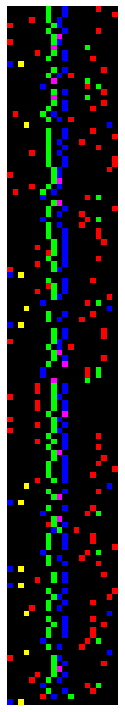

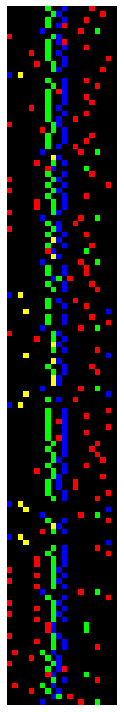

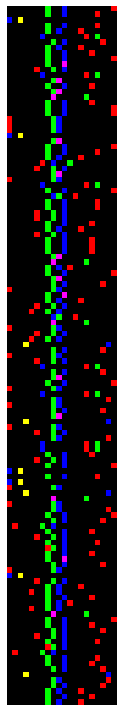

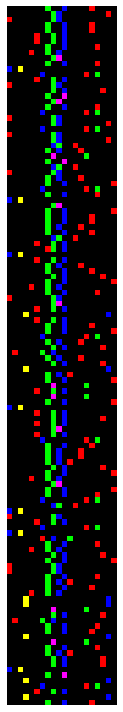

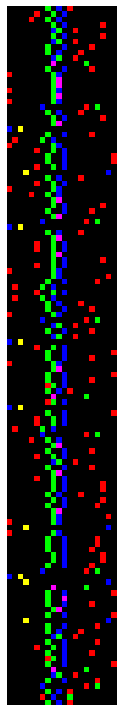

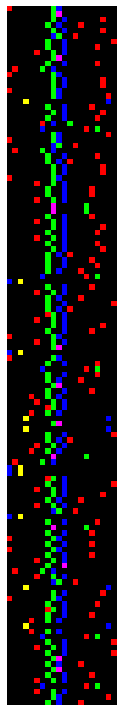

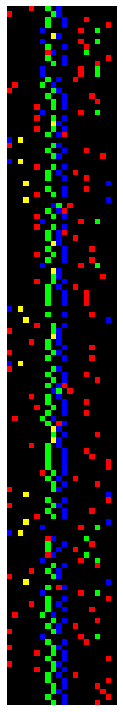

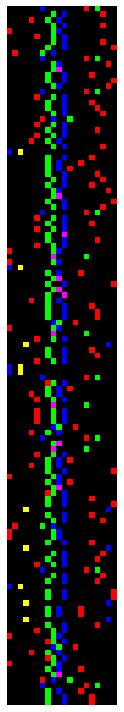

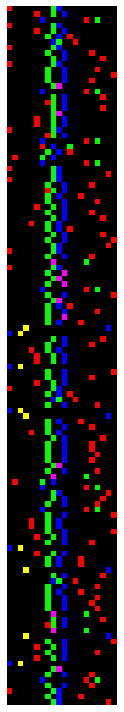

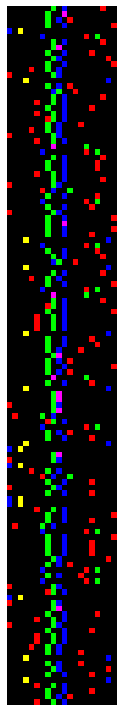

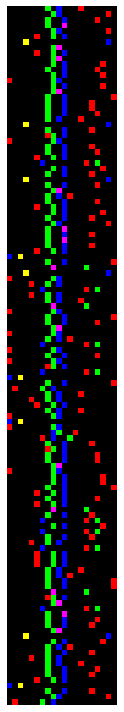

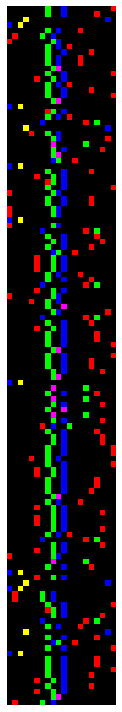

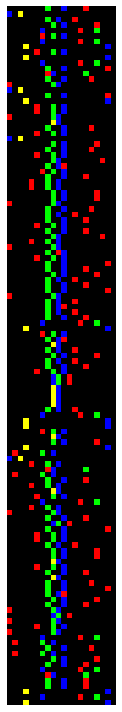

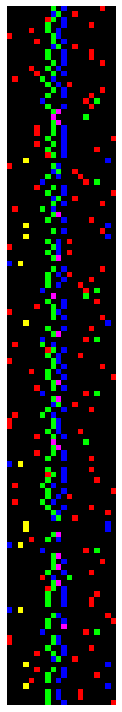

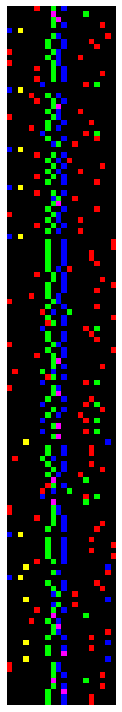

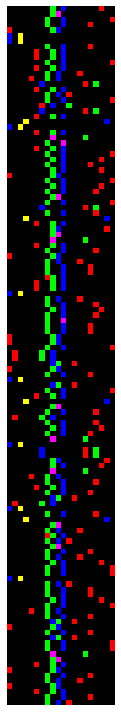

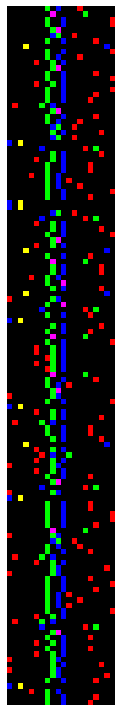

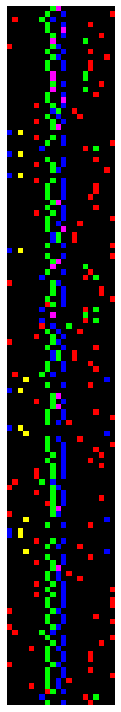

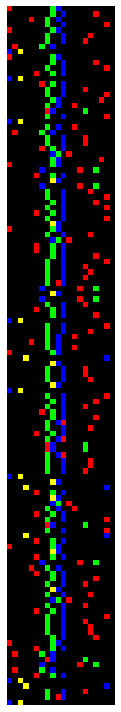

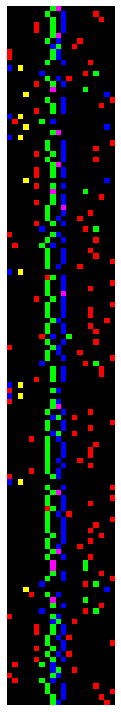

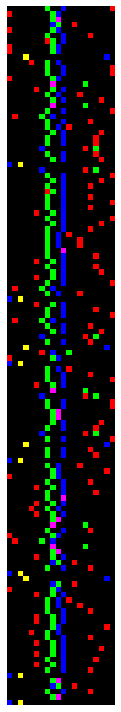

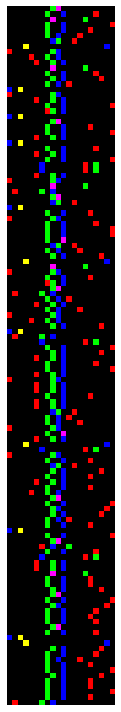

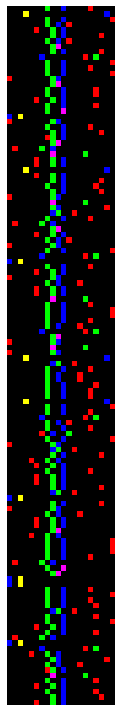

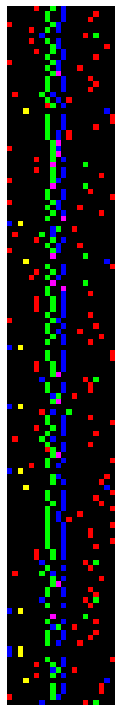

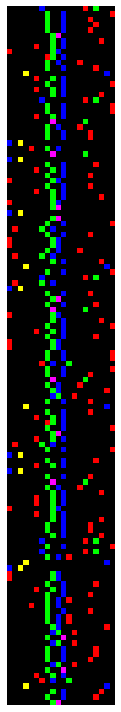

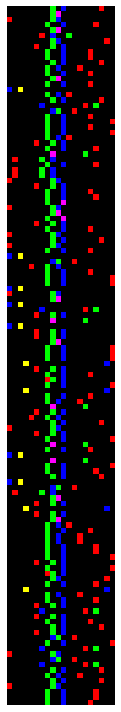

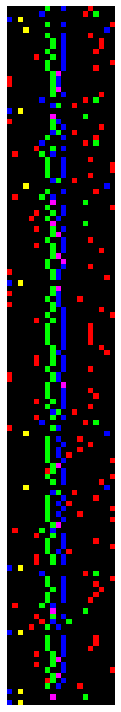

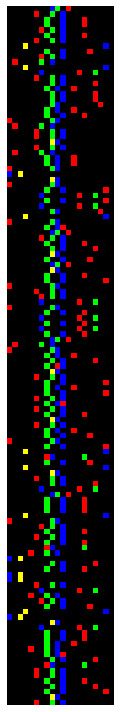

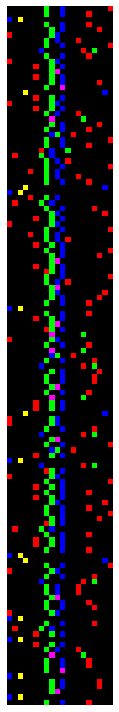

In [47]:
for c, i in enumerate(positive['shuffledVHH']):
    seq_onehot = AAseq(i, dictionary)
    charge_onehot = AAcharge(i, antigenseq, dictionary, charge_df)
    hydroph_onehot = AAhydroph(i, antigenseq, dictionary, hydroph_df)
    RGBimage(seq_onehot, charge_onehot, hydroph_onehot)
    plt.savefig('/Users/adriankaufmann/Desktop/RGBimages_trainingset/negative_all/%s_negative.png' %training['Name'][c], 
                bbox_inches='tight', pad_inches=0)
    

# negatives ABs

In [11]:
# negative meaning non-binding
negative_ABs = pd.read_excel('/Users/adriankaufmann/Desktop/negatives.xlsx')

In [16]:
for c,i in enumerate(negative_ABs['VHH']):
    negative_ABs['VHH'][c] = i.replace(u'\xa0', u'')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


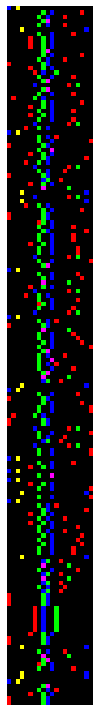

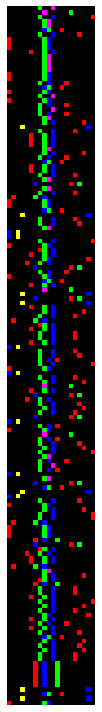

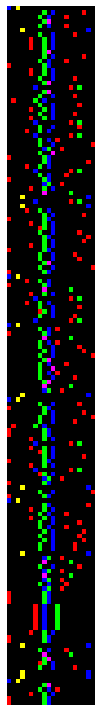

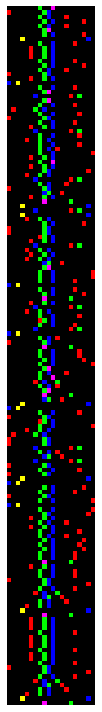

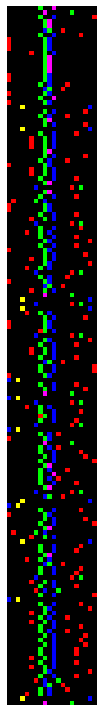

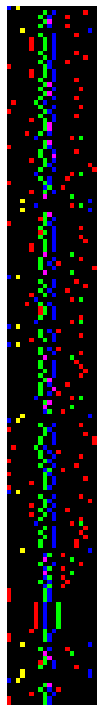

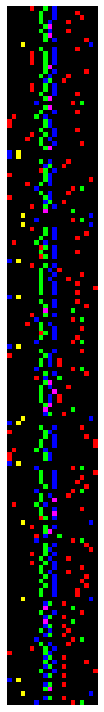

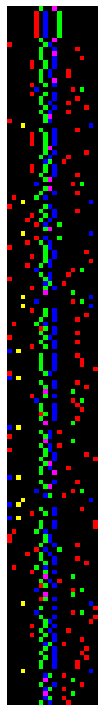

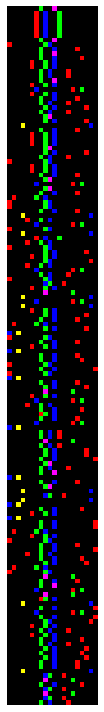

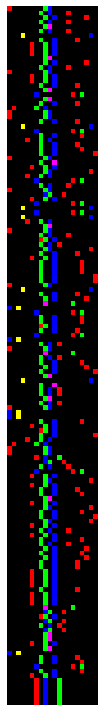

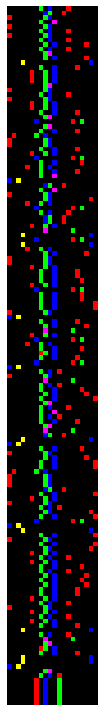

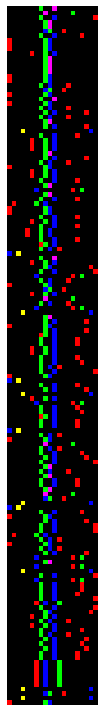

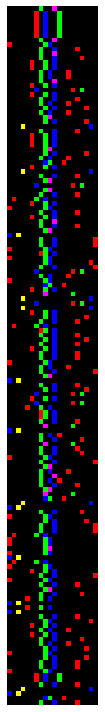

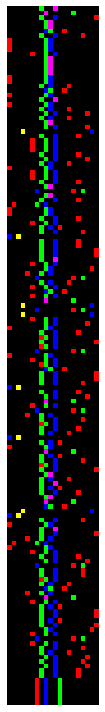

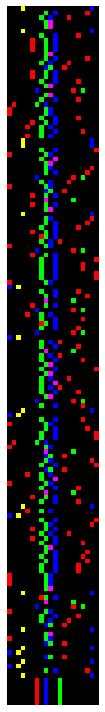

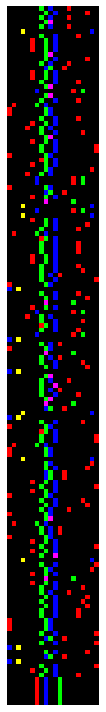

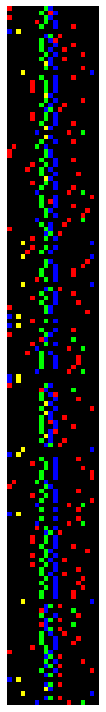

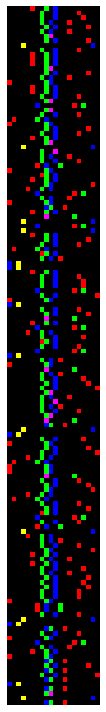

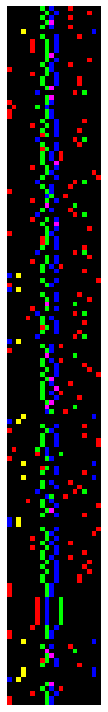

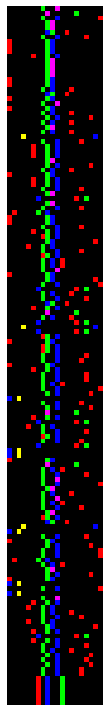

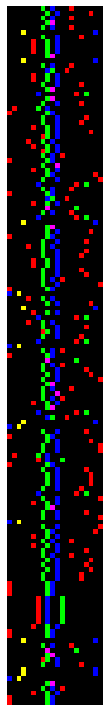

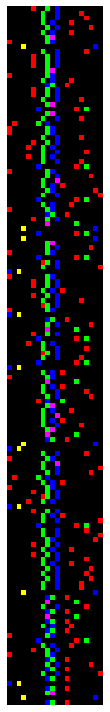

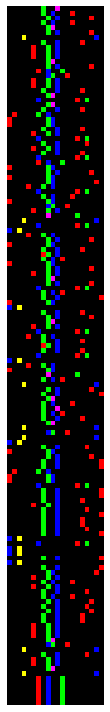

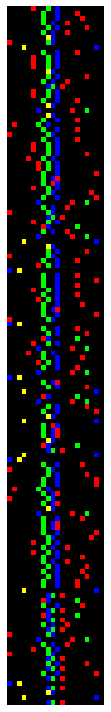

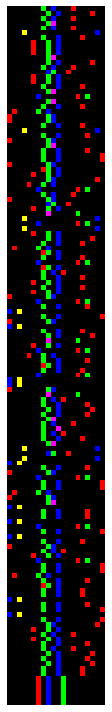

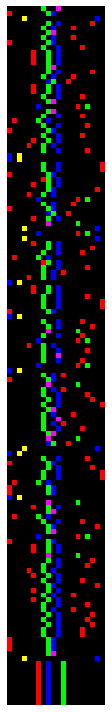

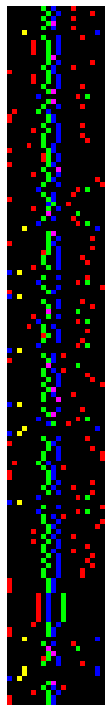

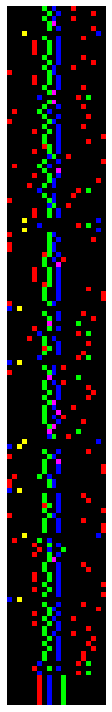

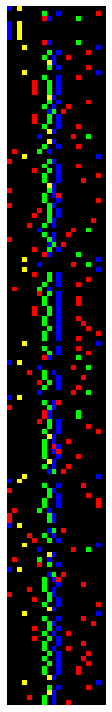

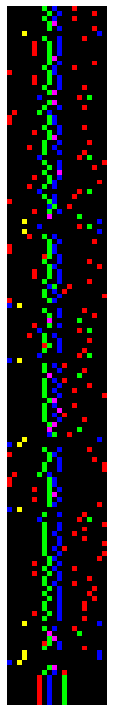

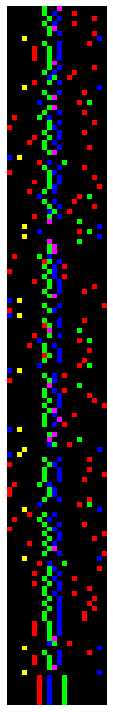

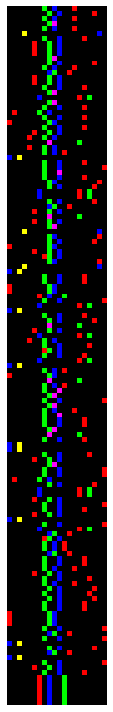

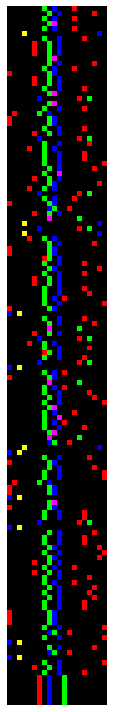

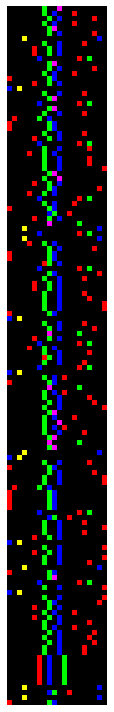

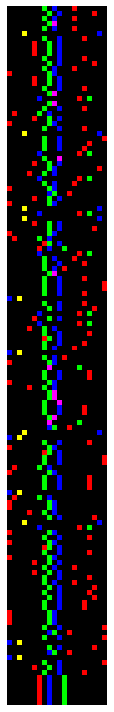

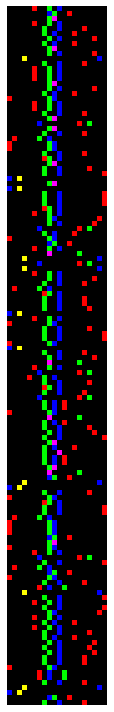

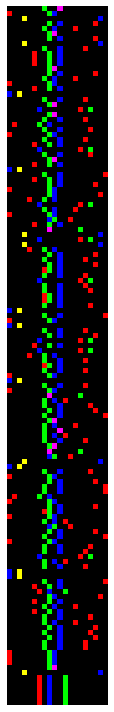

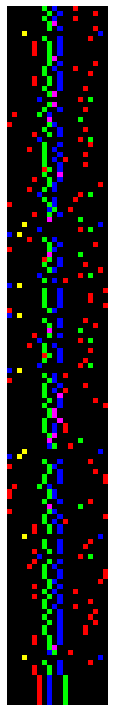

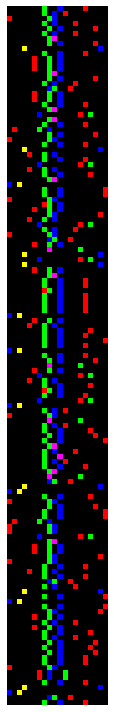

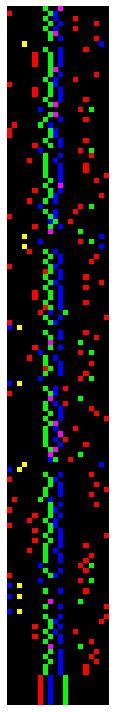

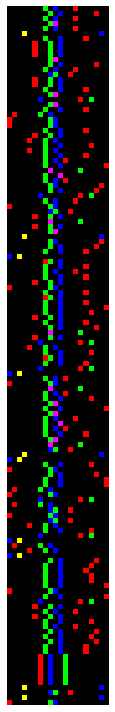

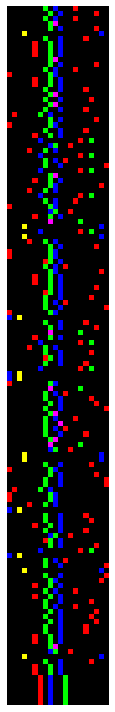

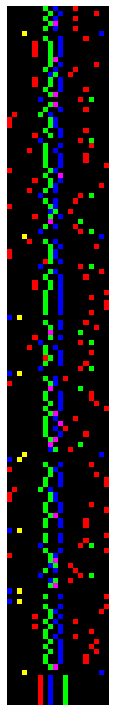

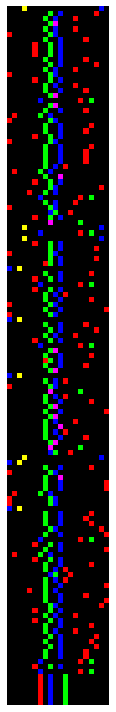

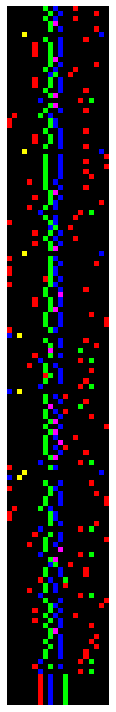

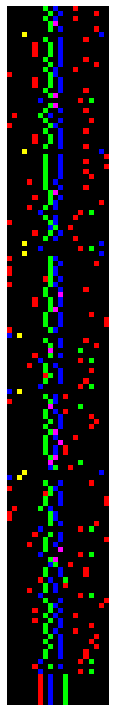

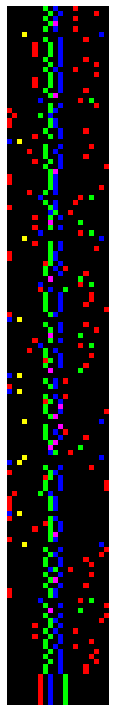

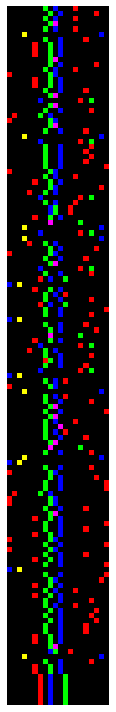

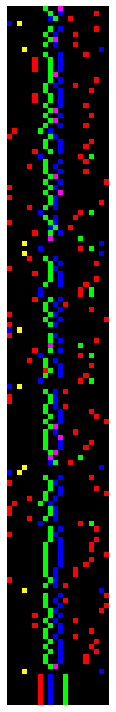

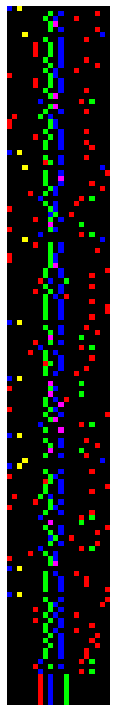

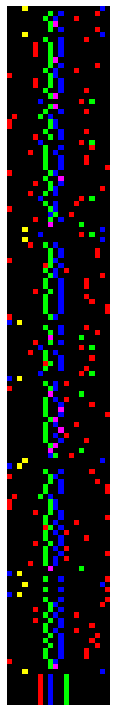

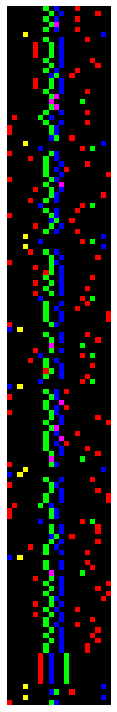

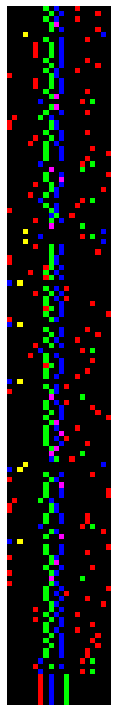

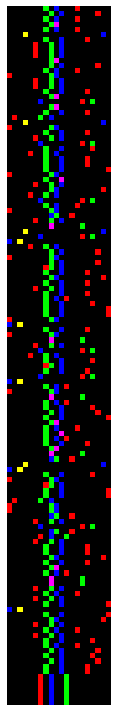

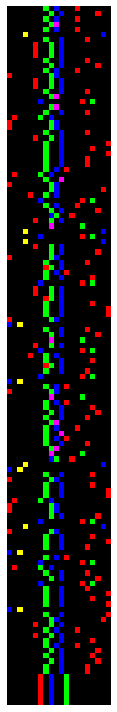

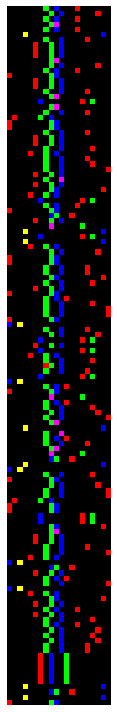

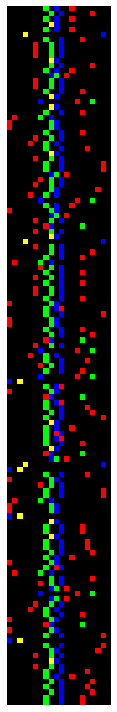

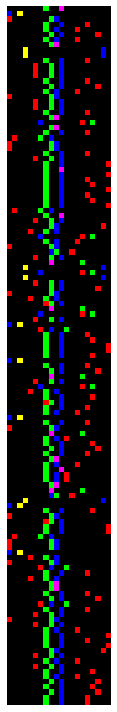

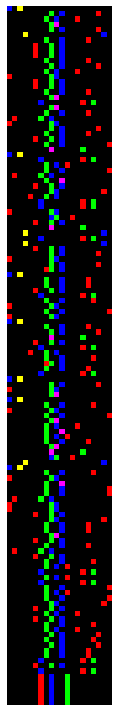

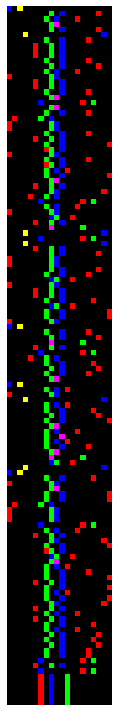

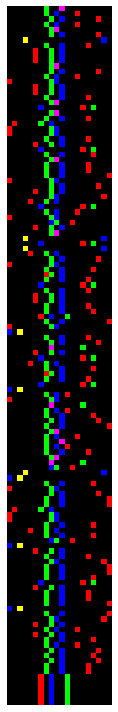

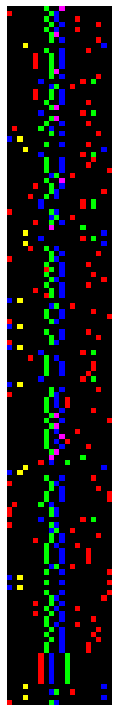

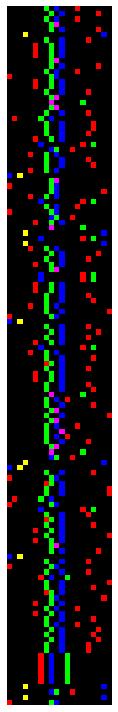

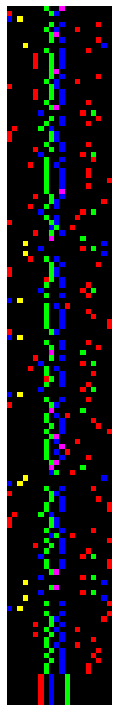

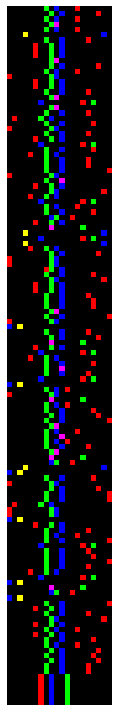

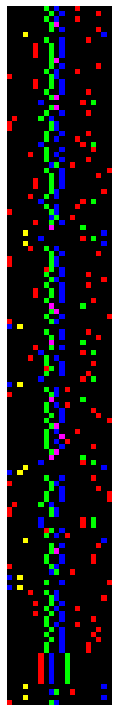

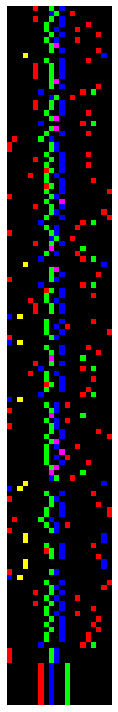

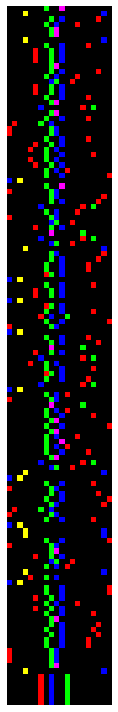

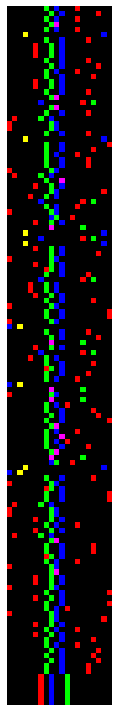

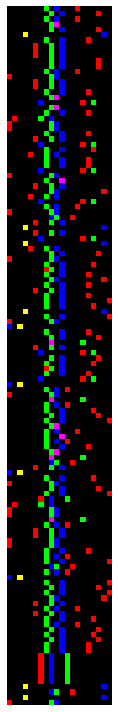

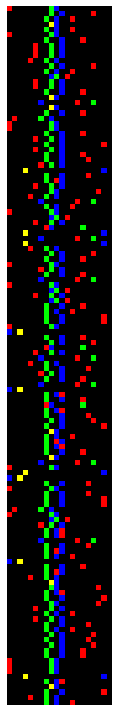

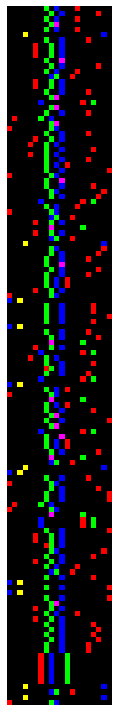

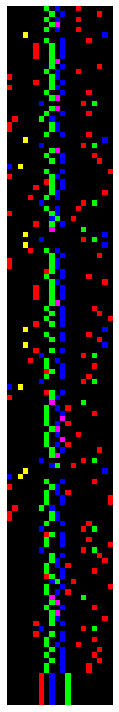

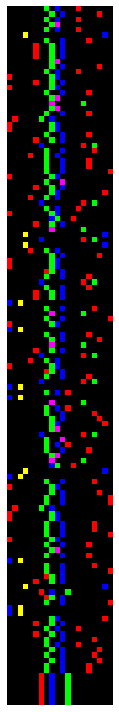

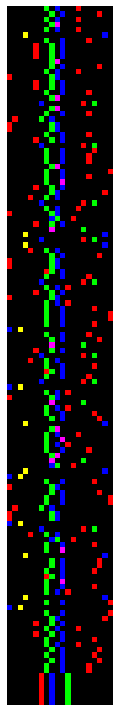

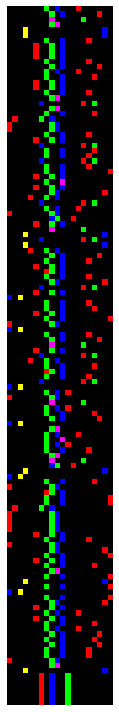

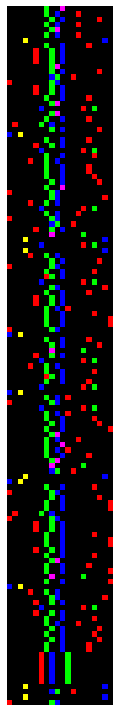

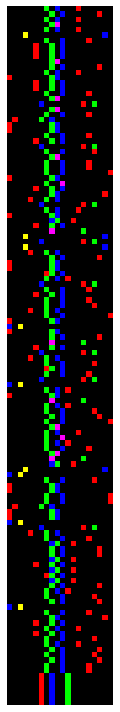

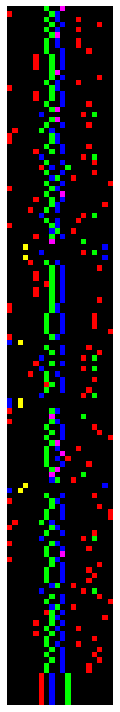

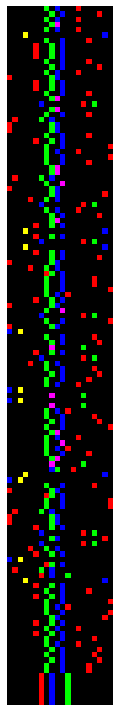

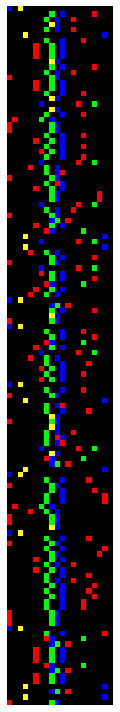

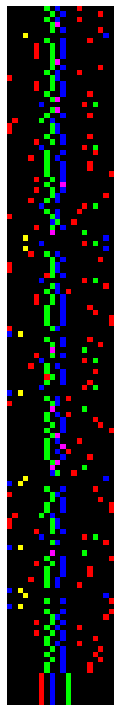

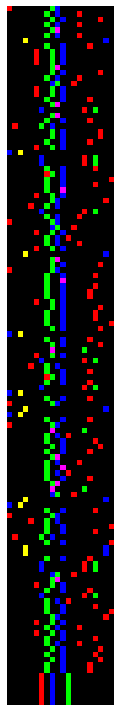

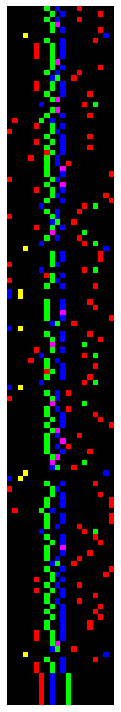

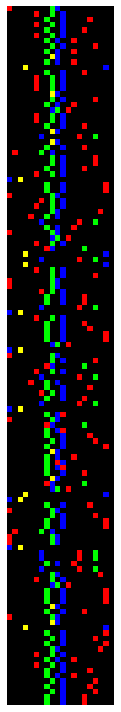

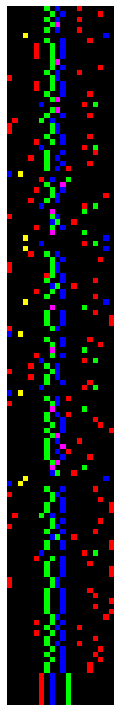

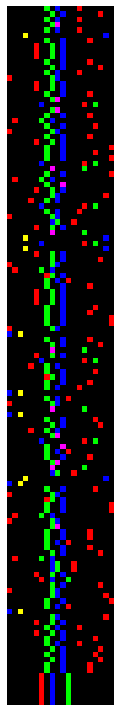

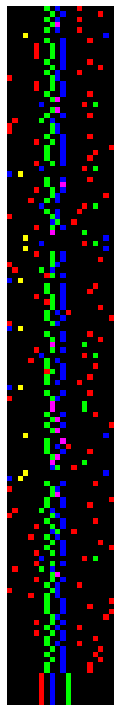

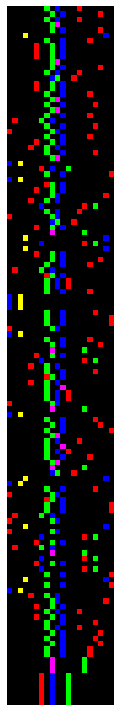

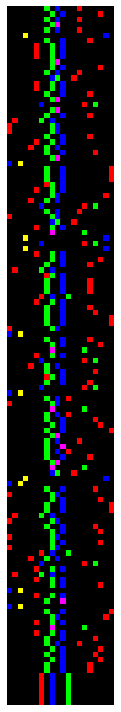

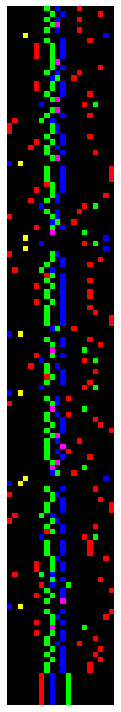

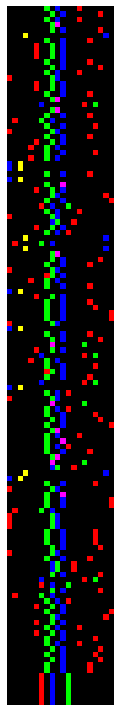

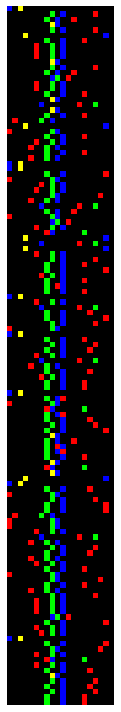

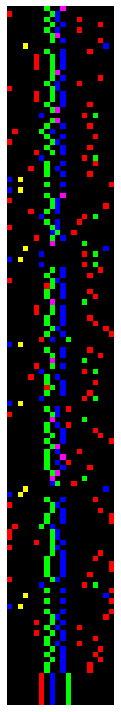

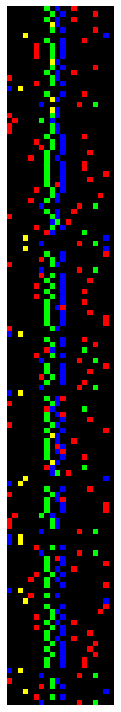

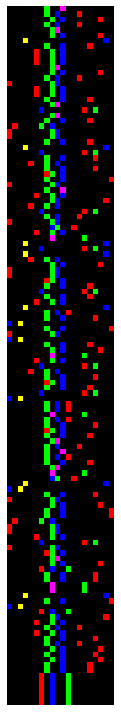

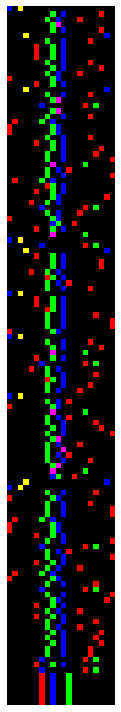

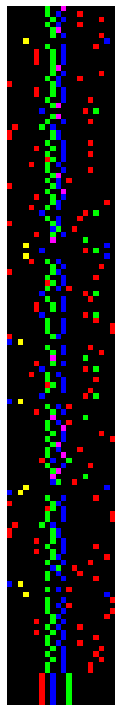

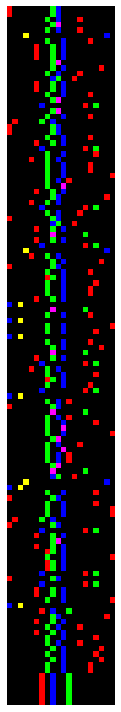

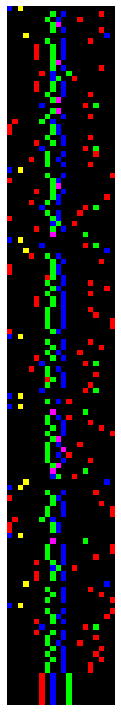

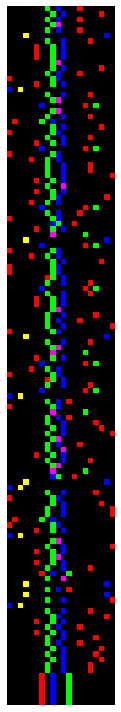

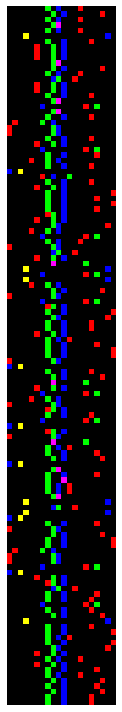

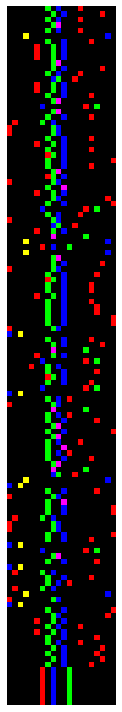

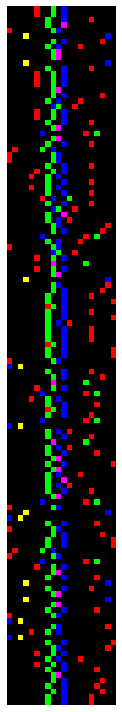

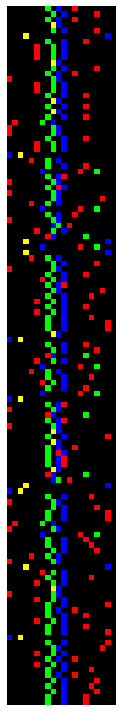

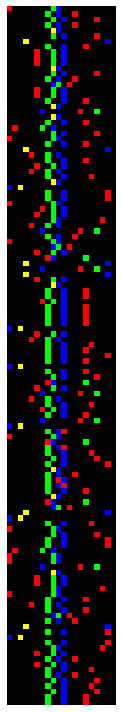

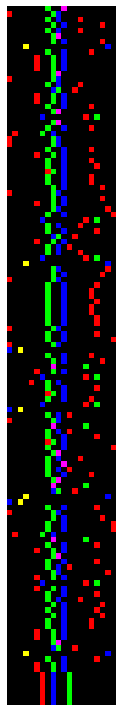

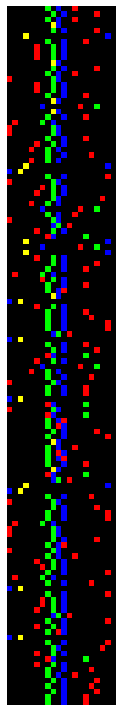

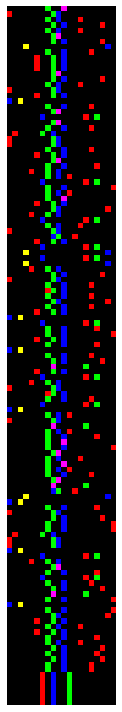

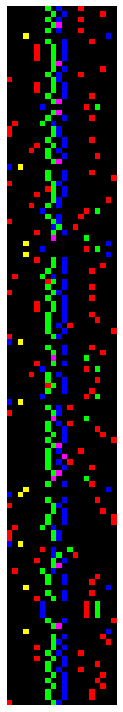

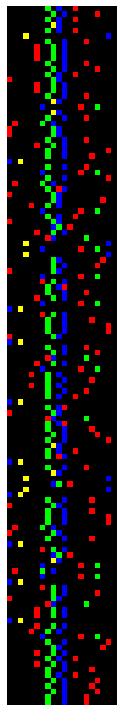

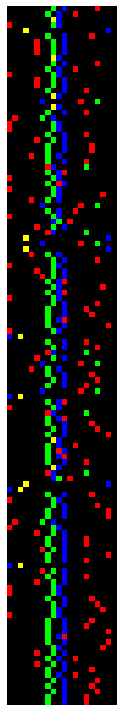

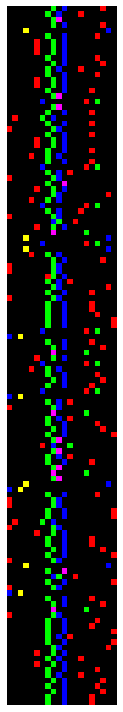

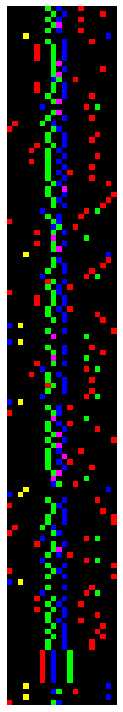

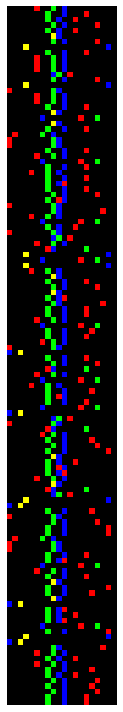

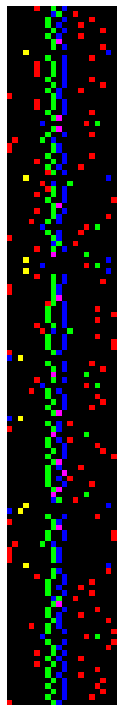

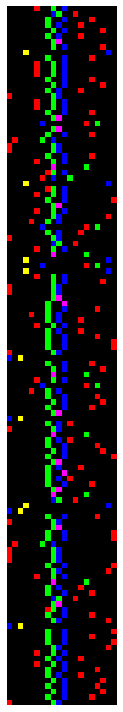

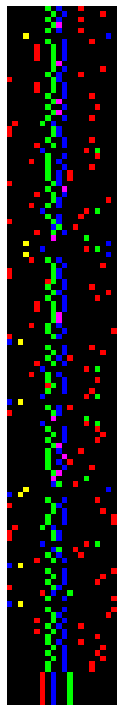

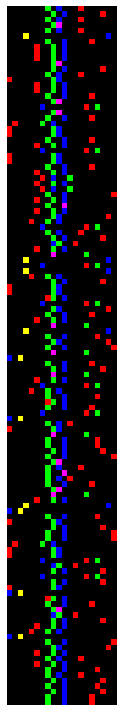

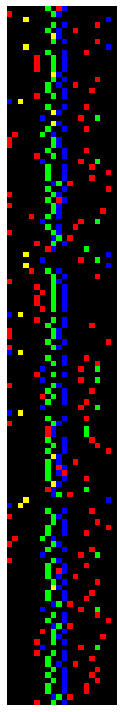

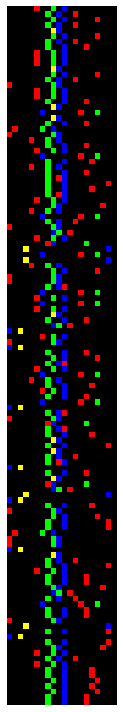

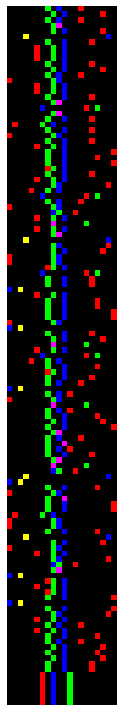

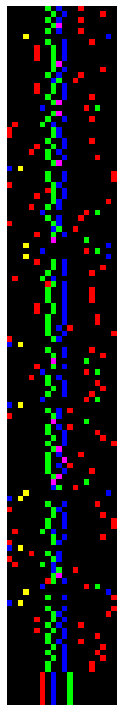

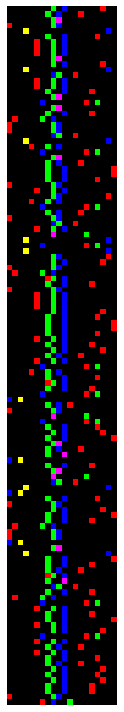

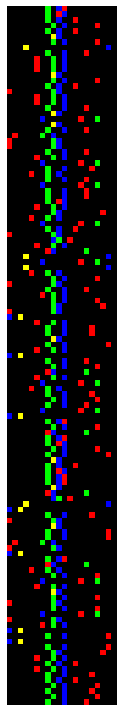

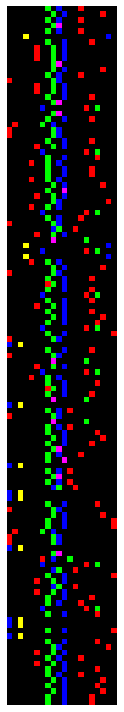

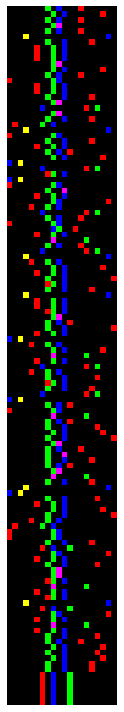

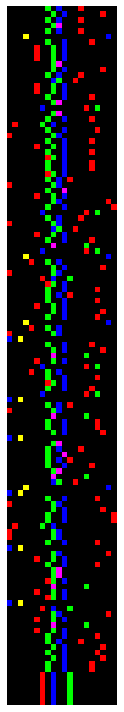

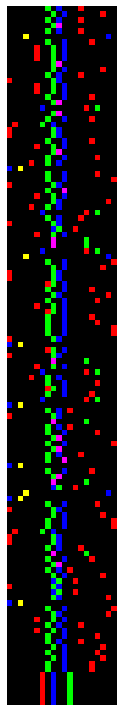

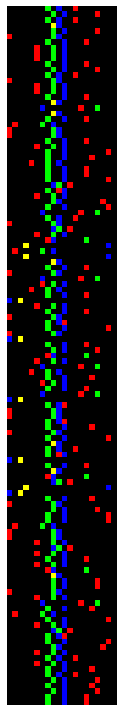

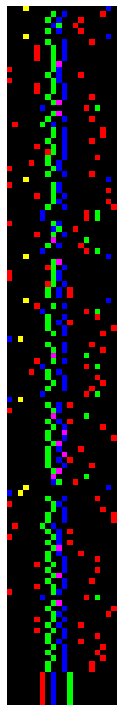

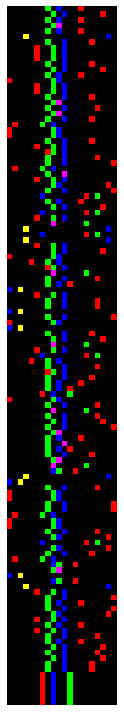

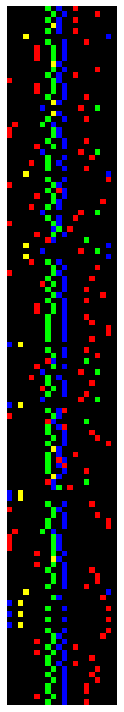

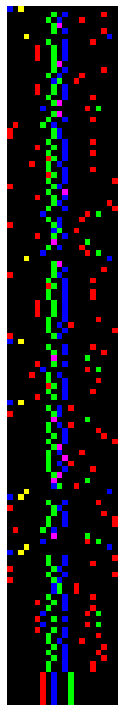

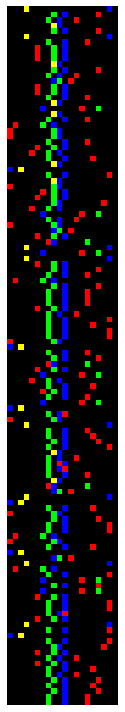

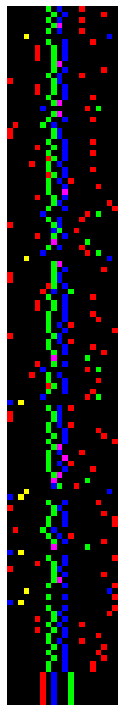

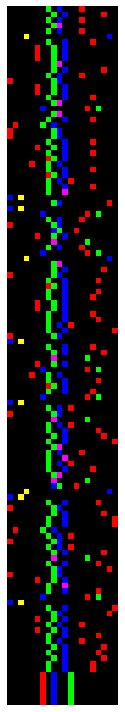

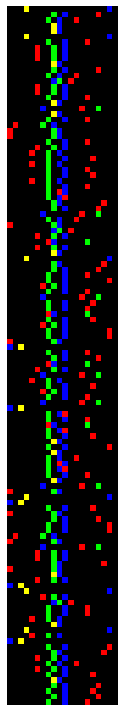

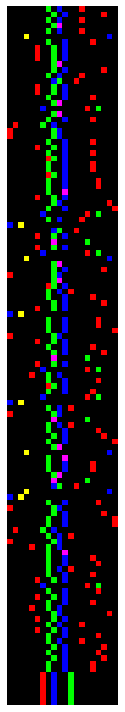

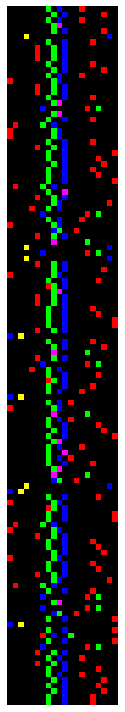

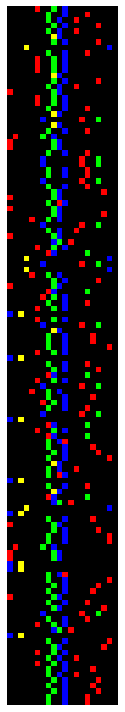

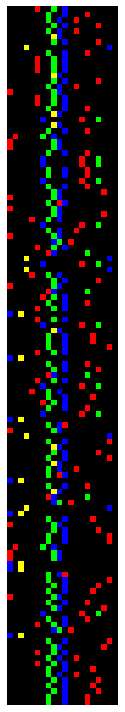

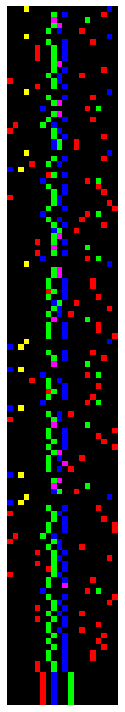

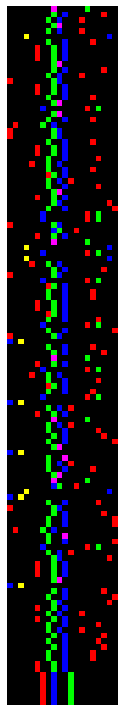

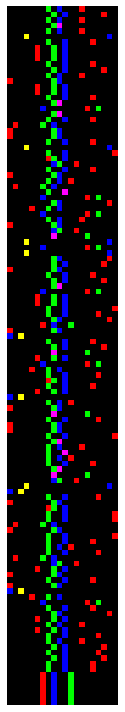

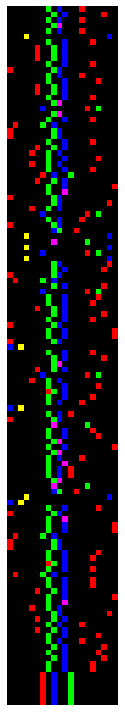

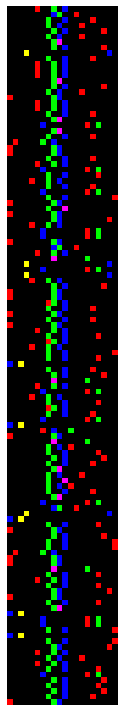

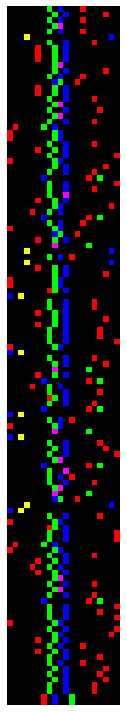

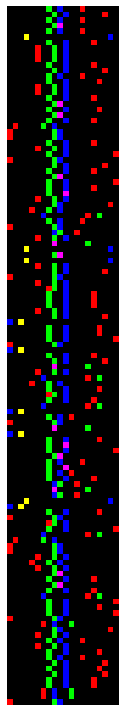

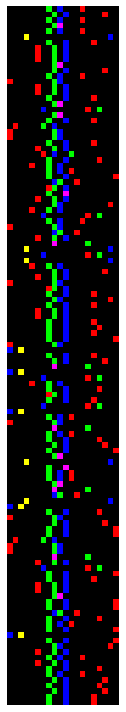

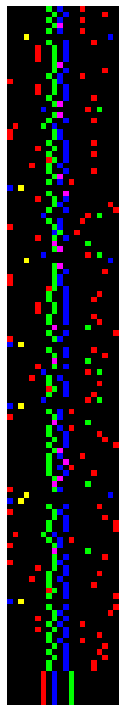

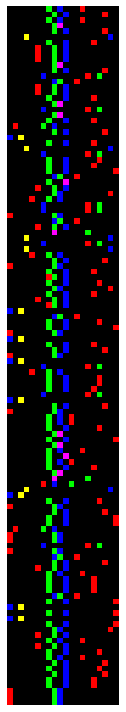

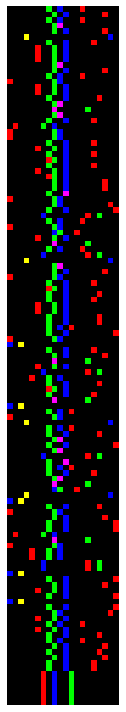

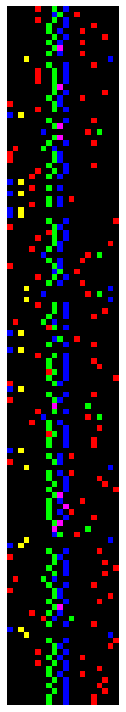

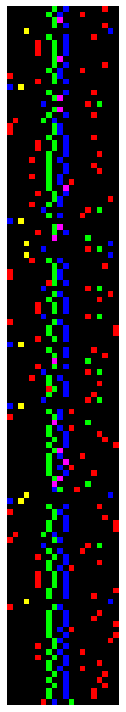

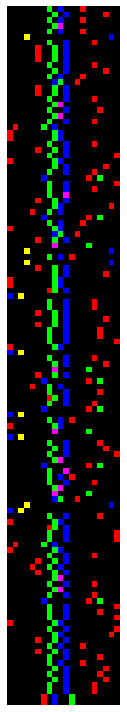

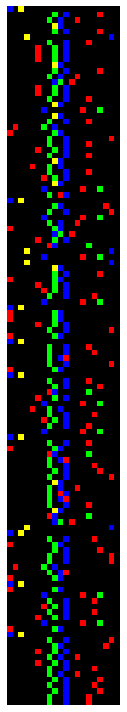

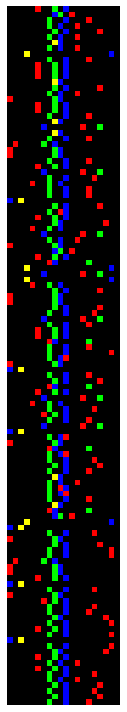

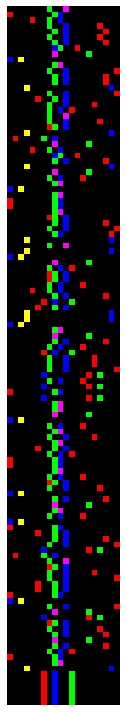

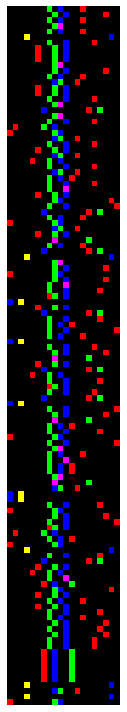

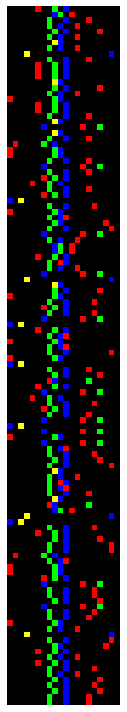

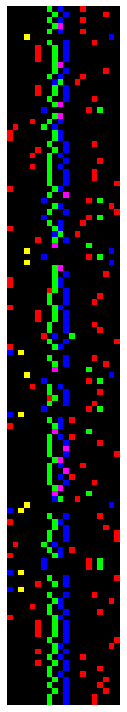

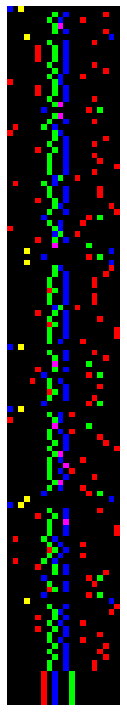

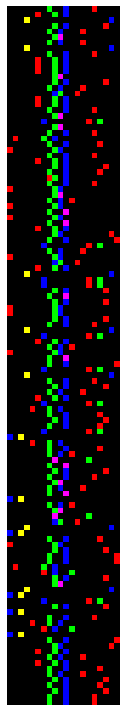

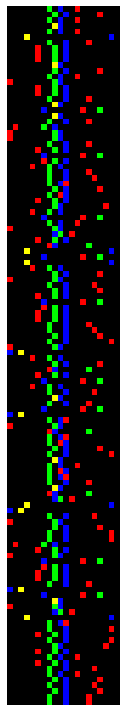

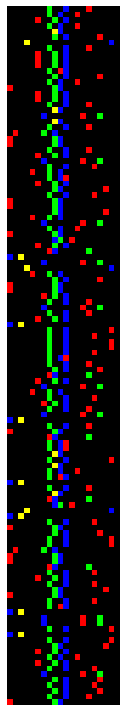

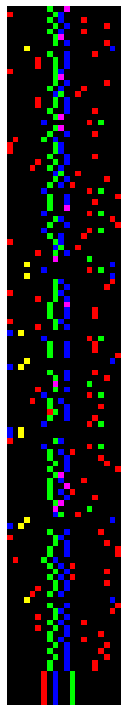

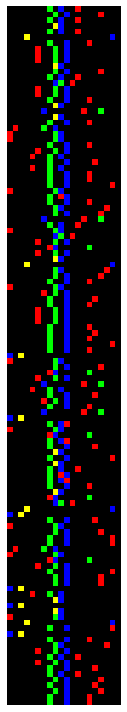

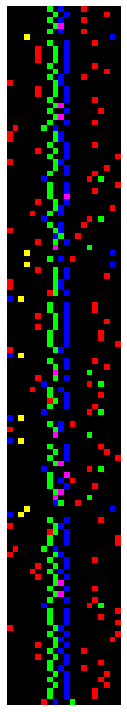

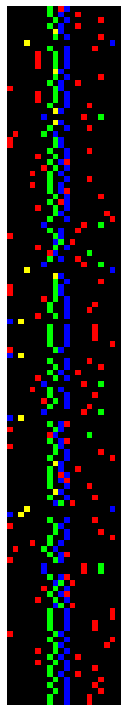

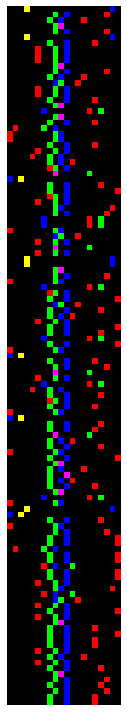

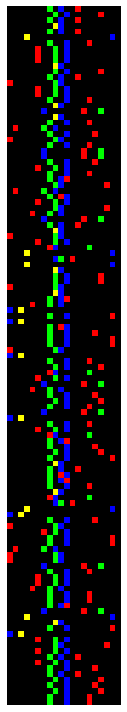

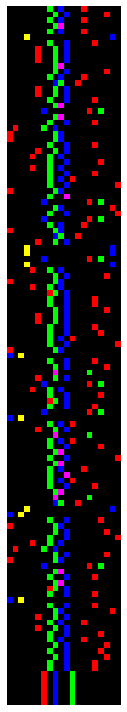

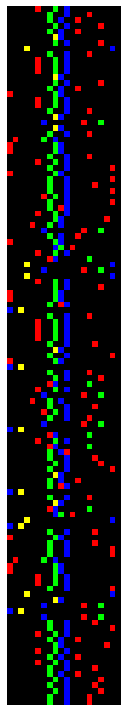

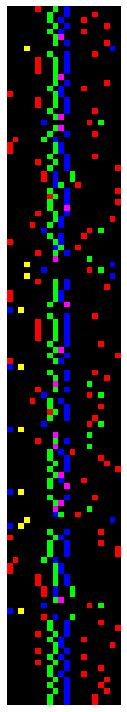

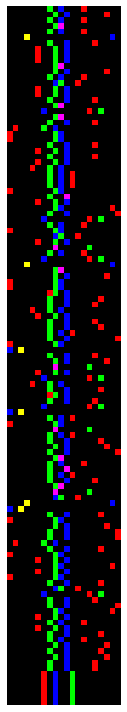

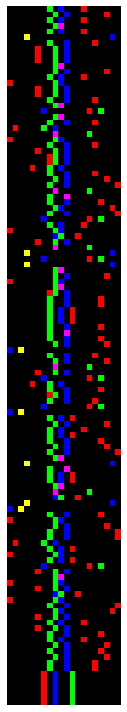

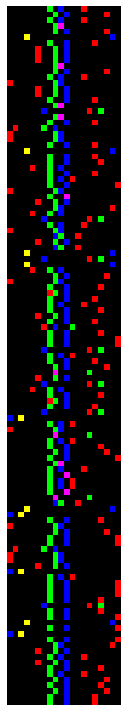

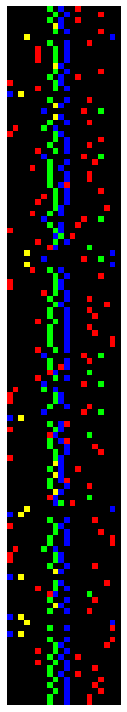

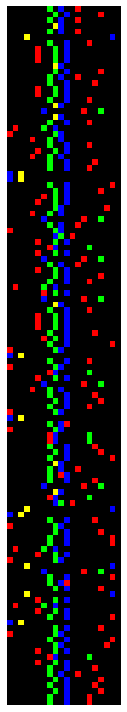

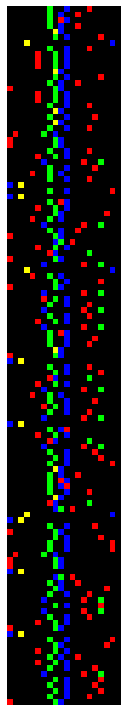

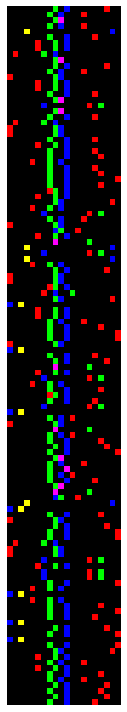

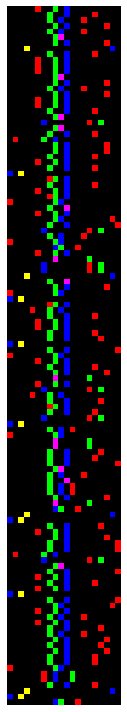

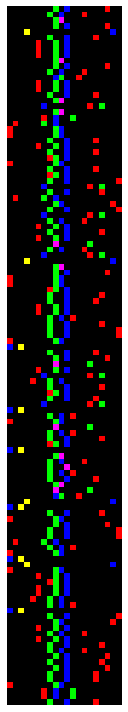

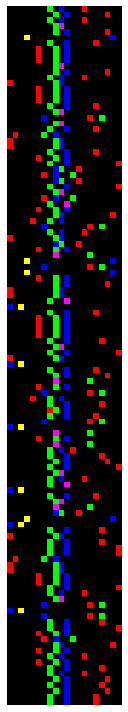

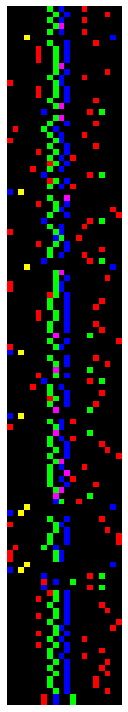

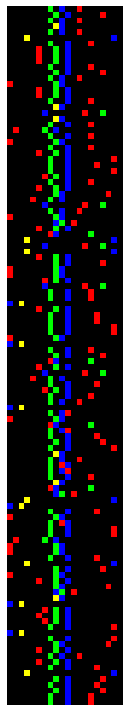

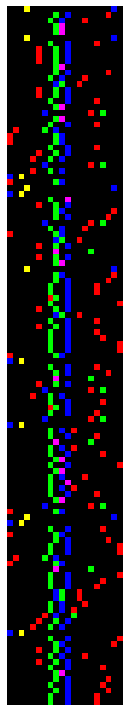

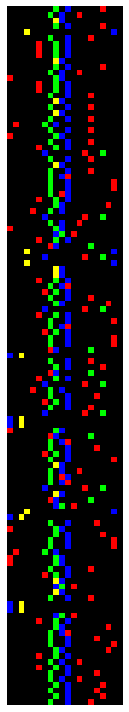

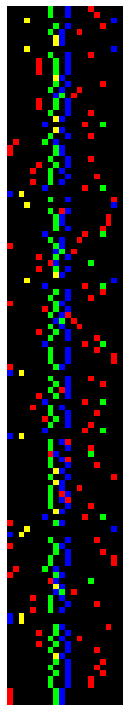

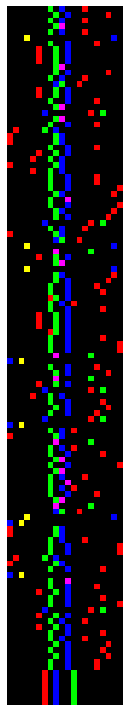

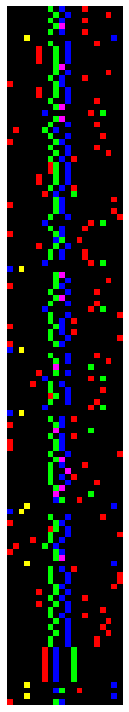

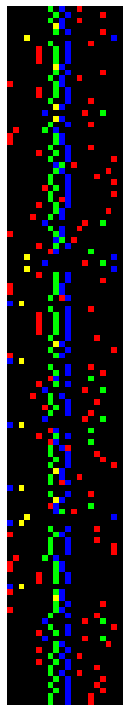

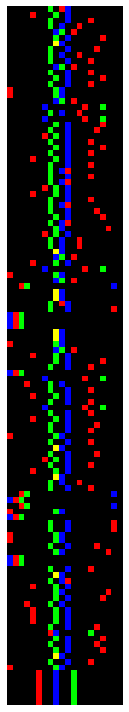

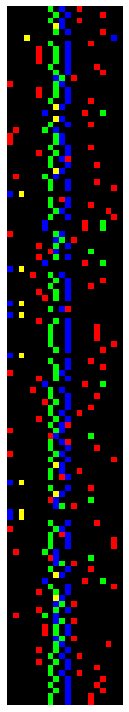

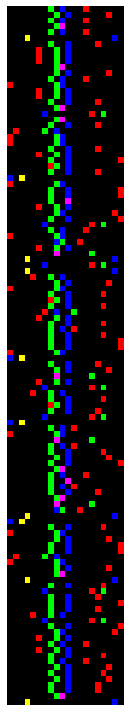

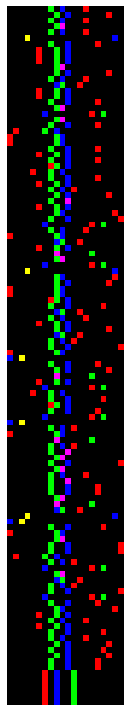

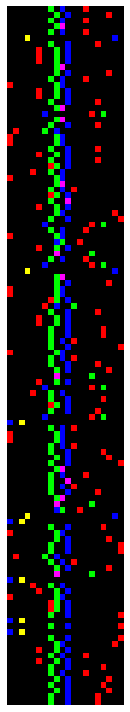

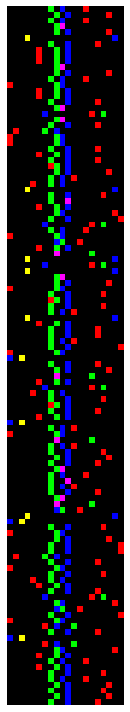

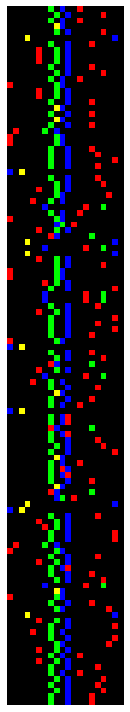

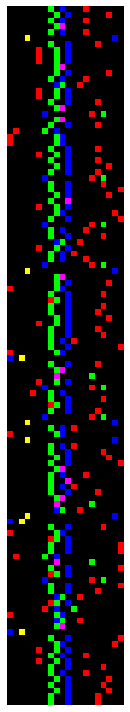

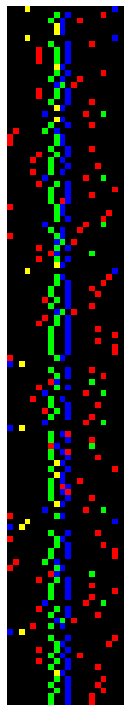

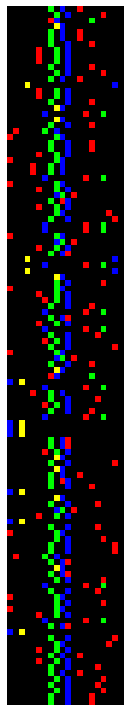

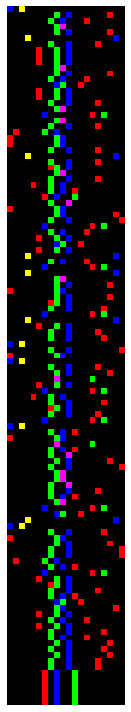

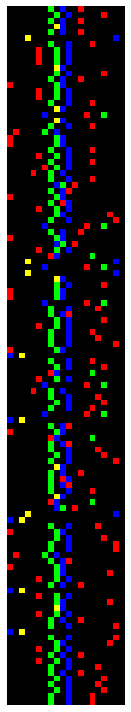

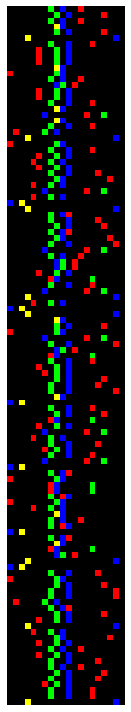

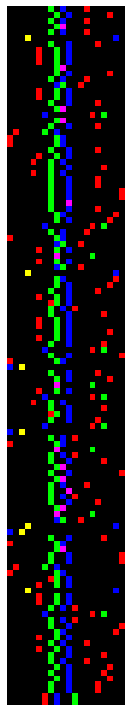

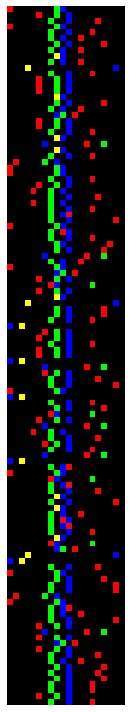

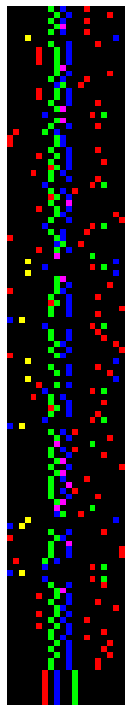

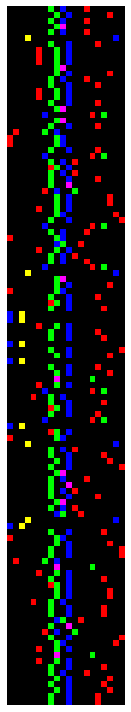

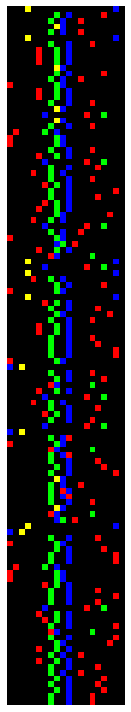

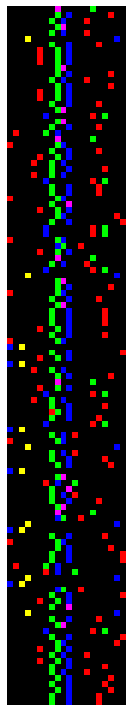

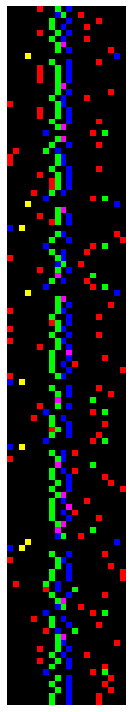

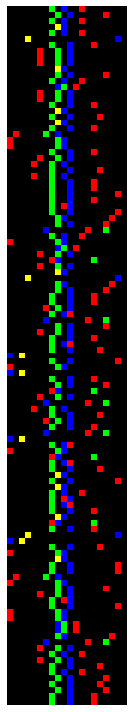

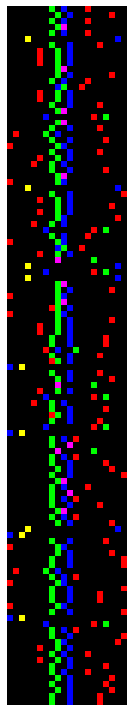

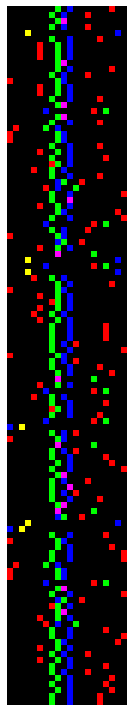

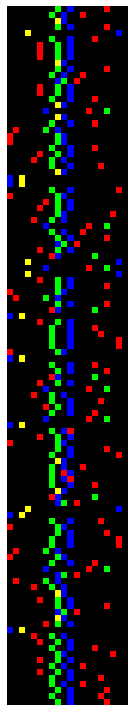

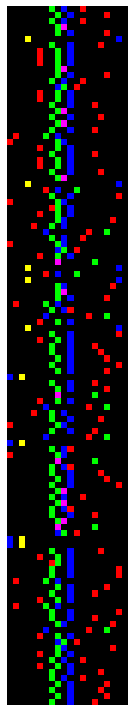

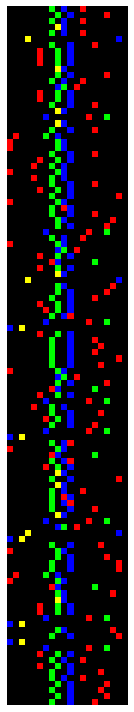

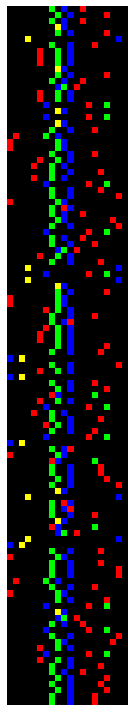

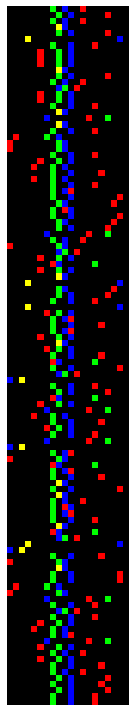

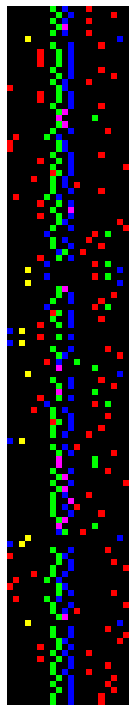

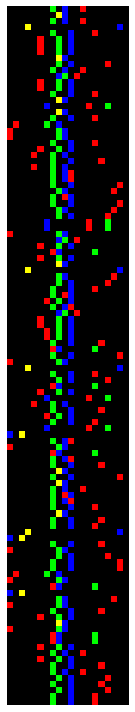

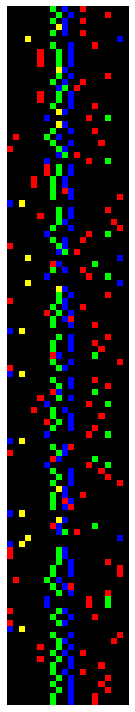

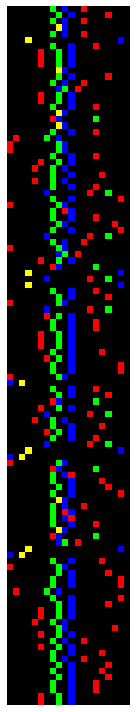

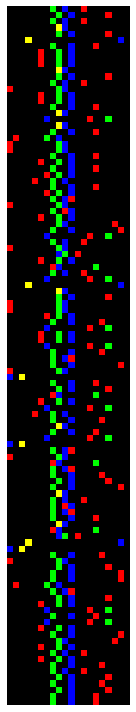

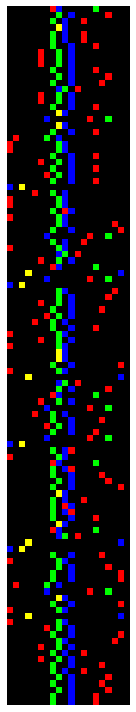

In [20]:
for c, i in enumerate(negative_ABs['VHH']):
    seq_onehot = AAseq(i, dictionary)
    charge_onehot = AAcharge(i, antigenseq, dictionary, charge_df)
    hydroph_onehot = AAhydroph(i, antigenseq, dictionary, hydroph_df)
    RGBimage(seq_onehot, charge_onehot, hydroph_onehot)
    plt.savefig('/Users/adriankaufmann/Desktop/RGBimages_trainingset/negative_ABs/%s' %c, 
                bbox_inches='tight', pad_inches=0)
    